<a name="TOC"></a>
# Tutorial 1: Constructing the Exact TD-SE Integration Methods

In this tutorial we will learn several methods of integrating TD-SE on a grid:

* Split-operator Fourier transform (SOFT) method of Kosloff and Kosloff
* Direct, Verlet-like integrator
* Direct, but using Colbert-Miller DVR
* Colbert-Miller DVR + SOFT

TOC

* [1. Plotting](#plotting) Main and auxiliary functions for plotting 


* [2. Models](#models) Definition of the models


* [3. Dynamics Methods](#methods) Definition of the integration schemes 

  * [3.1.](#soft) Split-operator Fourier transform (SOFT) method of Kosloff and Kosloff - works best in diabatic representation
  * [3.2.](#direct-dia) Direct, Diabatic representation
  * [3.3.](#direct-adi) Direct, Adiabatic representation
  * [3.4.](#direct-colbert-miller-dia) Direct but using Colbert-Miller DVR for representing kinetic energy operator in the real space for Diabatic representation
  * [3.5.](#direct-colbert-miller-adi) Direct but using Colbert-Miller DVR for representing kinetic energy operator in the real space for Adiabatic representation  
  * [3.6.](#soft-colbert-miller) Combination of the SOFT method with the real-space representation of the kinetic energy operator approach. Again, only diabatic represntation
  
  
* [4. Calculations: almost adiabatic case](#calcs) The results of the simulations

  * [4.1.](#res-soft) Split-operator Fourier transform (SOFT) method of Kosloff and Kosloff - works best in diabatic representation
  * [4.2.](#res-direct-dia) Direct, Diabatic representation
  * [4.3.](#res-direct-adi) Direct, Adiabatic representation  
  * [4.4.](#res-direct-colbert-miller-dia) Diabatic representation
  * [4.5.](#res-direct-colbert-miller-adi) Adiabatic representation
  * [4.6.](#res-soft-colbert-miller) Combination of the SOFT method with the real-space representation of the kinetic energy operator approach. Again, only diabatic represntation


* [5. Calculations: more non-adiabaticity](#calcs-2) The results of the simulations

  * [5.1.](#res-soft-2) Split-operator Fourier transform (SOFT) method of Kosloff and Kosloff - works best in diabatic representation
  * [5.2.](#res-direct-dia-2) Direct, Diabatic representation
  * [5.3.](#res-direct-adi-2) Direct, Adiabatic representation  
  * [5.4.](#res-direct-colbert-miller-dia-2) Diabatic representation
  * [5.5.](#res-direct-colbert-miller-adi-2) Adiabatic representation
  * [5.6.](#res-soft-colbert-miller-2) Combination of the SOFT method with the real-space representation of the kinetic energy operator approach. Again, only diabatic represntation


* [6. HDF5 plotting](#hdf5_plotting) The results of the simulations

The methods will be studied on the case of n-sites Holstein Hamiltonians


In [1]:
import sys
import cmath
import math
import os
import time
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata
%matplotlib inline 


if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.models.Holstein as Holstein
from libra_py import tsh
from libra_py import tsh_stat
from libra_py.data_outs import bin2list, list2bin
from libra_py import data_conv
from libra_py import data_savers
import libra_py.dynamics.exact.compute as compute
import libra_py.dynamics.exact.save as save
import util.libutil as comn



plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::all

<a name="plotting"></a> [Back to TOC](#TOC)
## 1. Plotting

Below, we define 2 functions:

1. `plot_surfaces` - for plotting the model potentials (adiabatic and diabatic energies). This is need just to visualize the models we deal with

2. `plot_case` - this function reads the properties saved along the run (in binary files) and plots them. The properties include stuff like adiabatic/diabatic populations, kinetic/potential/total energies, phase space diagram ( < q > - < p > ) as well as the norm of the wavefunctions. 

   Note: this function should be adjusted according to the format assumed by the dynamics functions


In [2]:
def plot_surfaces(_compute_model, _param_sets, states_of_interest):
    """
    Args:
        _compute_model ( PyObject ): the function that returns the class with Hamiltonian properties
        _param_sets ( list of lists of dictionaries): parameters of the models
        states_of_interest ( list of ints ): indices of the states we want to plot 
        
    """
    
    xmin = -7.5
    xmax = 15.0
    dx = 0.01

    X = []
    nsteps = int((xmax - xmin) / dx) + 1

    for i in range(nsteps):
        X.append(xmin + i * dx)
    
    

    plt.rc('axes', titlesize=38)      # fontsize of the axes title
    plt.rc('axes', labelsize=38)      # fontsize of the x and y labels
    plt.rc('legend', fontsize=36)     # legend fontsize
    plt.rc('xtick', labelsize=28)     # fontsize of the tick labels
    plt.rc('ytick', labelsize=28)     # fontsize of the tick labels

    plt.rc('figure.subplot', left=0.2)
    plt.rc('figure.subplot', right=0.95)
    plt.rc('figure.subplot', bottom=0.13)
    plt.rc('figure.subplot', top=0.88)
    

    sz = len(_param_sets)
    for iset in range(sz):
        
        n = len(_param_sets[iset]["E_n"])
        
        ham = nHamiltonian(n, n, 1) # ndia, nadi, nnucl
        ham.init_all(2)

        
        hdia, hadi  = [], []  
        uij = []              # projecitions of the MOs onto elementary basis
    
        for k1 in range(n):
            hadi.append([])
            hdia.append([])
            uij_k1 = []
            for k2 in range(n):
                uij_k1.append([])
            uij.append(uij_k1)
                
    
        for i in range(nsteps):
                 
            q = MATRIX(1,1); q.set(0, 0, X[i])        
        
            # Diabatic properties
            ham.compute_diabatic(_compute_model, q, _param_sets[iset])
            
            # Adiabatic properties
            ham.compute_adiabatic(1);       
        
            U = ham.get_basis_transform()
            #P = U * U.H()  # population matrix
        
            for k1 in range(n):
                hadi[k1].append(ham.get_ham_adi().get(k1,k1).real)
                hdia[k1].append(ham.get_ham_dia().get(k1,k1).real)
            
                for k2 in range(n):
                    uij[k1][k2].append(U.get(k1,k2).real**2 + U.get(k1,k2).imag**2)
                    

                    
        plt.figure(2*iset, figsize=(36, 18)) # dpi=300, frameon=False)
                
        plt.subplot(1, 2, 1)    
        plt.ylim(-0.005, 0.025)
        plt.xlim(-7.5, 15)
    
        #plt.title('Params set %i: Ham_dia' % (iset) )
        plt.xlabel('Coordinate, a.u.')
        plt.ylabel('Energy, a.u.')
        for k1 in range(n):
            plt.plot(X, hdia[k1], label='$H_{%i%i}$' % (k1,k1), linewidth=7, color = colors[clrs_index[k1]])     
        plt.legend()    
    
        plt.subplot(1, 2, 2)
        plt.ylim(-0.005, 0.025)
        plt.xlim(-7.5, 15)
        #plt.title('Params set %i: Ham_adi' % (iset))
        plt.xlabel('Coordinate, a.u.')
        plt.ylabel('Energy, a.u.')
        for k1 in range(n):
            plt.plot(X, hadi[k1], label='$E_{%i}$' % (k1), linewidth=7, color = colors[clrs_index[k1]])     
        plt.legend()    
            
            
          
        plt.figure(2*iset+1, figsize=(36, 18)) # dpi=300, frameon=False)            
        sz1 = len(states_of_interest)
    
        for k2 in states_of_interest:
            indx = states_of_interest.index(k2)
            plt.subplot(1, sz1, 1+indx)
            #plt.title('Params set %i: Adi state %i' % (iset, k2) )
            plt.xlabel('Coordinate, a.u.')
            plt.ylabel('Projection')
    
            for k1 in range(n):            
                plt.plot(X, uij[k1][k2], label='$<%i|%i>$' % (k1, k2), linewidth=7, color = colors[clrs_index[k1]])         
            plt.legend()               
    

        plt.show()
        plt.close()          

In [3]:
def plot_case(prefix, _params, model_params):
    """
    Args:
        prefix ( string ): the name of the run, which is also the name of the folder 
            that will contain the results (all the needed filed) produced by the dynamics 
            and the ones that we want to read in and plot
        _params ( dict ): simulation control parameters
        model_params ( dict ): the parameters of the model we compute
        
    """
    
    params = dict(_params)
    
    nsteps = params["nsteps"]
    nstates = len(model_params["E_n"])
 
    t = bin2list("%s/t" % (prefix), nsteps)
    
    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(2, 2, 1)
    plt.title('Adiabatic population dynamics' )
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population')
    for i in range(nstates):
        Pi = bin2list("%s/adi_P%i" % (prefix, i), nsteps)
        plt.plot(t, Pi, label='$P_%i$' % (i), linewidth=2, color = colors[clrs_index[i]])   
        plt.legend()
    
    
    plt.subplot(2, 2, 2)
    plt.title('Phase space' )
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Momentum, a.u.')
    q = bin2list("%s/q" % (prefix), nsteps)
    p = bin2list("%s/p" % (prefix), nsteps)
    plt.plot(q, p, label='', linewidth=2, color = colors["11"])   
    plt.legend()
    
    #print(p)

    plt.savefig("%s/Fig1.png" % (prefix), dpi=300)
    plt.savefig("%s/Fig1.pdf" % (prefix), dpi=300)

    
    
    plt.figure(2, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(2, 2, 1)
    plt.title('Diabatic population dynamics' )
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population')
    for i in range(nstates):
        Pi = bin2list("%s/dia_P%i" % (prefix, i), nsteps)
        plt.plot(t, Pi, label='$P_%i$' % (i), linewidth=2, color = colors[clrs_index[i]])   
        plt.legend()
        
    plt.subplot(2, 2, 2)
    plt.title('Energies' )
    plt.xlabel('t, a.u.')
    plt.ylabel('Energy, a.u.')
    Ekin = bin2list("%s/Ekin" % (prefix), nsteps)
    Epot = bin2list("%s/Epot" % (prefix), nsteps)
    Etot = bin2list("%s/Etot" % (prefix), nsteps)
    plt.plot(t, Etot, label='Etot', linewidth=2, color = colors["11"])   
    plt.plot(t, Ekin, label='Ekin', linewidth=2, color = colors["21"])   
    plt.plot(t, Epot, label='Epot', linewidth=2, color = colors["31"])   
    plt.legend()

    plt.savefig("%s/Fig2.png" % (prefix), dpi=300)
    plt.savefig("%s/Fig2.pdf" % (prefix), dpi=300)
    
    
    plt.figure(3, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(2, 2, 1)
    plt.title('Norm' )
    plt.xlabel('Time, a.u.')
    plt.ylabel('Norm')
    nrm0 = bin2list("%s/nrm0" % (prefix), nsteps)
    nrm1 = bin2list("%s/nrm1" % (prefix), nsteps)
        
        
    plt.plot(t, nrm0, label='Diabatic', linewidth=2, color = colors["11"])   
    plt.plot(t, nrm1, label='Adiabatic', linewidth=2, color = colors["21"])   
    plt.legend()

    plt.savefig("%s/Fig3.png" % (prefix), dpi=300)
    plt.savefig("%s/Fig3.pdf" % (prefix), dpi=300)
    
    
    
    plt.show()
    plt.close()


In [4]:
def plot_mem(res, _params, model_params):
    """
    Args:
        res ( mem_saver ): the object with all the suitable parameters
        _params ( dict ): simulation control parameters
        model_params ( dict ): the parameters of the model we compute
        
    """
    
    
    params = dict(_params)
    
    nsteps = params["nsteps"]    
    nstates = len(model_params["E_n"])
    prefix = params["prefix"]
    properties_to_save = params["properties_to_save"]
 
    
    t = None
    if "time" in properties_to_save:
        #t = res.data["time"]
        t = list(res.np_data["time"][:])
    
    #=============== Populations ======================
    
    plt.figure(1, figsize=(36, 12)) # dpi=300, frameon=False)    
    plt.subplot(1, 2, 1)
    plt.title('Adiabatic population dynamics' )
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population')
    
    if "pop_adi" in properties_to_save and t != None:
        for i in range(nstates):        
            #Pi = data_conv.unpack1(res.data["pop_adi"], i, 0, 0)                
            Pi = list(res.np_data["pop_adi"][:, i, 0])
            plt.plot(t, Pi, label='$P_%i$' % (i), linewidth=10, color = colors[clrs_index[i]])   
            plt.legend()
    
    
    plt.subplot(1, 2, 2)
    plt.title('Diabatic population dynamics' )
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population')
    
    if "pop_dia" in properties_to_save and t != None:
        for i in range(nstates):
            #Pi = data_conv.unpack1(res.data["pop_dia"], i, 0, 0)                        
            Pi = list(res.np_data["pop_dia"][:, i, 0])
            plt.plot(t, Pi, label='$P_%i$' % (i), linewidth=10, color = colors[clrs_index[i]])   
            plt.legend()
            
    plt.savefig("%s/Fig1.png" % (prefix), dpi=300)
    plt.savefig("%s/Fig1.pdf" % (prefix), dpi=300)
            
                
    #============= Energies =====================
    plt.figure(2, figsize=(36, 12)) # dpi=300, frameon=False)           
    
    plt.subplot(1, 2, 1)
    plt.title('Energies' )
    plt.xlabel('t, a.u.')
    plt.ylabel('Energy, a.u.')
    if "Ekin_dia" in properties_to_save \
       and "Epot_dia" in properties_to_save \
       and "Etot_dia" in properties_to_save \
       and t != None:
        
        #Ekin_dia = res.data["Ekin_dia"]  
        #Epot_dia = res.data["Epot_dia"]  
        #Etot_dia = res.data["Etot_dia"]  
        Ekin_dia = list(res.np_data["Ekin_dia"][:])
        Epot_dia = list(res.np_data["Epot_dia"][:])
        Etot_dia = list(res.np_data["Etot_dia"][:])
        plt.plot(t, Etot_dia, label='$Etot_{dia}$', linewidth=10, color = colors["11"])   
        plt.plot(t, Ekin_dia, label='$Ekin_{dia}$', linewidth=10, color = colors["21"])   
        plt.plot(t, Epot_dia, label='$Epot_{dia}$', linewidth=10, color = colors["31"])   
        plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Energies' )
    plt.xlabel('t, a.u.')
    plt.ylabel('Energy, a.u.')
    
    if "Ekin_adi" in properties_to_save \
       and "Epot_adi" in properties_to_save \
       and "Etot_adi" in properties_to_save \
       and t != None:
        
        #Ekin_adi = res.data["Ekin_adi"]  
        #Epot_adi = res.data["Epot_adi"]  
        #Etot_adi = res.data["Etot_adi"]  
        Ekin_adi = list(res.np_data["Ekin_adi"][:])
        Epot_adi = list(res.np_data["Epot_adi"][:])
        Etot_adi = list(res.np_data["Etot_adi"][:])
        
        plt.plot(t, Etot_adi, label='$Etot_{adi}$', linewidth=10, color = colors["11"])   
        plt.plot(t, Ekin_adi, label='$Ekin_{adi}$', linewidth=10, color = colors["21"])   
        plt.plot(t, Epot_adi, label='$Epot_{adi}$', linewidth=10, color = colors["31"])   
        plt.legend()

    plt.savefig("%s/Fig2.png" % (prefix), dpi=300)
    plt.savefig("%s/Fig2.pdf" % (prefix), dpi=300)
    
  
    #============= Phase spaces & Norms  =====================
    plt.figure(3, figsize=(36, 12)) # dpi=300, frameon=False)           
                
    plt.subplot(1, 2, 1)
    plt.title('Phase space' )
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Momentum, a.u.')   
    
    if "q_dia" in properties_to_save and "p_dia" in properties_to_save:
        #ndof = res.data["q_dia"][0].num_of_rows
        
        ndof = res.np_data["q_dia"].shape[1]
        
        
    
        for idof in range(ndof):
            #qi = data_conv.unpack1(res.data["q_dia"], idof, 0, 0)
            #pi = data_conv.unpack1(res.data["p_dia"], idof, 0, 0)
            qi = list(res.np_data["q_dia"][:, idof, 0])
            pi = list(res.np_data["p_dia"][:, idof, 0])
    
            plt.plot(qi, pi, label='', linewidth=10, color = colors[clrs_index[i]])   
            plt.legend()
                    

    plt.subplot(1, 2, 2)
    plt.title('Norms' )
    plt.xlabel('Time, a.u.')
    plt.ylabel('Norm')
    
    if "norm_dia" in properties_to_save and "norm_adi" in properties_to_save and t != None:
        
        #nrm_dia = res.data["norm_adi"]
        #nrm_adi = res.data["norm_dia"]
        nrm_dia = list(res.np_data["norm_dia"][:])
        nrm_adi = list(res.np_data["norm_adi"][:])
                
        plt.plot(t, nrm_dia, label='Diabatic', linewidth=10, color = colors["11"])   
        plt.plot(t, nrm_adi, label='Adiabatic', linewidth=10, color = colors["21"])   
        plt.legend()

    plt.savefig("%s/Fig3.png" % (prefix), dpi=300)
    plt.savefig("%s/Fig3.pdf" % (prefix), dpi=300)
    
        
    plt.show()
    plt.close()


<a name="models"></a> [Back to TOC](#TOC)
## 2. Models: Model Hamiltonian, parameters, and PES profiles 

Here, we define 2 functions:

1. `compute_mode` - it define how to compute the diabatic Hamiltonians to be called by the nHamiltonian object. 
    In the current tutorial, we simply call the Holstein Hamiltonians defined in the Libra collection of model
    Hamiltonians, but we could have defined it ourselves (to be called or to be computed diectly here).
    
    Note that this function should follow certain conventions - see the description of the input and output
    
2. `potential` - the function called by the `Wfcgrid2` class to compute (and store internally) diabatic or adiabatic
    Hamiltonians on the grid. The funciton's API is also to be followed strictly.
              

In [5]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:
        #res = test1(q, params, full_id)
        res = Holstein.Holstein2(q, params, full_id)
    elif model==2:
        pass

    return res


In [6]:
def potential(q, params):
    """
    Thin wrapper of the model Hamiltonians that can be used in 
    the fully-quantum calculations
    """

    # Diabatic properties
    obj = compute_model(q, params, Py2Cpp_int([0,0]))
    
    # Adiabatic properties
    nadi = len(params["E_n"])
    ndof = 1
    ham = nHamiltonian(nadi, nadi, ndof) # ndia, nadi, nnucl
    ham.init_all(2)
        

    ham.compute_diabatic(compute_model, q, params)    
    ham.compute_adiabatic(1);   
    
    
    obj.ham_adi = ham.get_ham_adi()    
    obj.dc1_adi = CMATRIXList() 
    
    for n in range(ndof):    
        x = ham.get_dc1_adi(n)
        for i in range(nadi):
            for j in range(nadi):
                if i!=j:
                    #pass
                    if math.fabs(x.get(i,j).real)>1e+10:
                        x.set(i,j, 0.0+0.0j)                    
                        x.set(j,i, 0.0+0.0j)
                        
        obj.dc1_adi.append( x )    
    
    
    return obj
    

Here, we define a collection of potential models to study. As a result, we define the variable `param_sets` with some potential model parameters. 

In [7]:
param_sets = [ {"model":1,
                "E_n":[0.0, -0.001],
                "x_n":[4.0, 0.0],
                "k_n":[0.001, 0.001],
                "V":0.005
               },      
              
               {"model":1,
                "E_n":[0.0, -0.001],
                "x_n":[4.0, 0.0],
                "k_n":[0.001, 0.001],
                "V":0.0005
               },     
    
               {"model":1,
                "E_n":[0.0, -0.001, -0.001, -0.001],
                "x_n":[0.0, -4.0, 4.0, 4.0],
                "k_n":[0.001, 0.001, 0.001, 0.001],
                "V":0.001
               },                                          
              
              {"model":1,
                "E_n":[0.0, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001],
                "x_n":[0.0, -4.0, 4.0, 4.0, 8.0, 8.0, 8.0, 12.0, 12.0, 12.0],
                "k_n":[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                "V":0.001
               }                                          
             ]


However, in this tutorial, we will only examine the first model, so we plot only it below. 

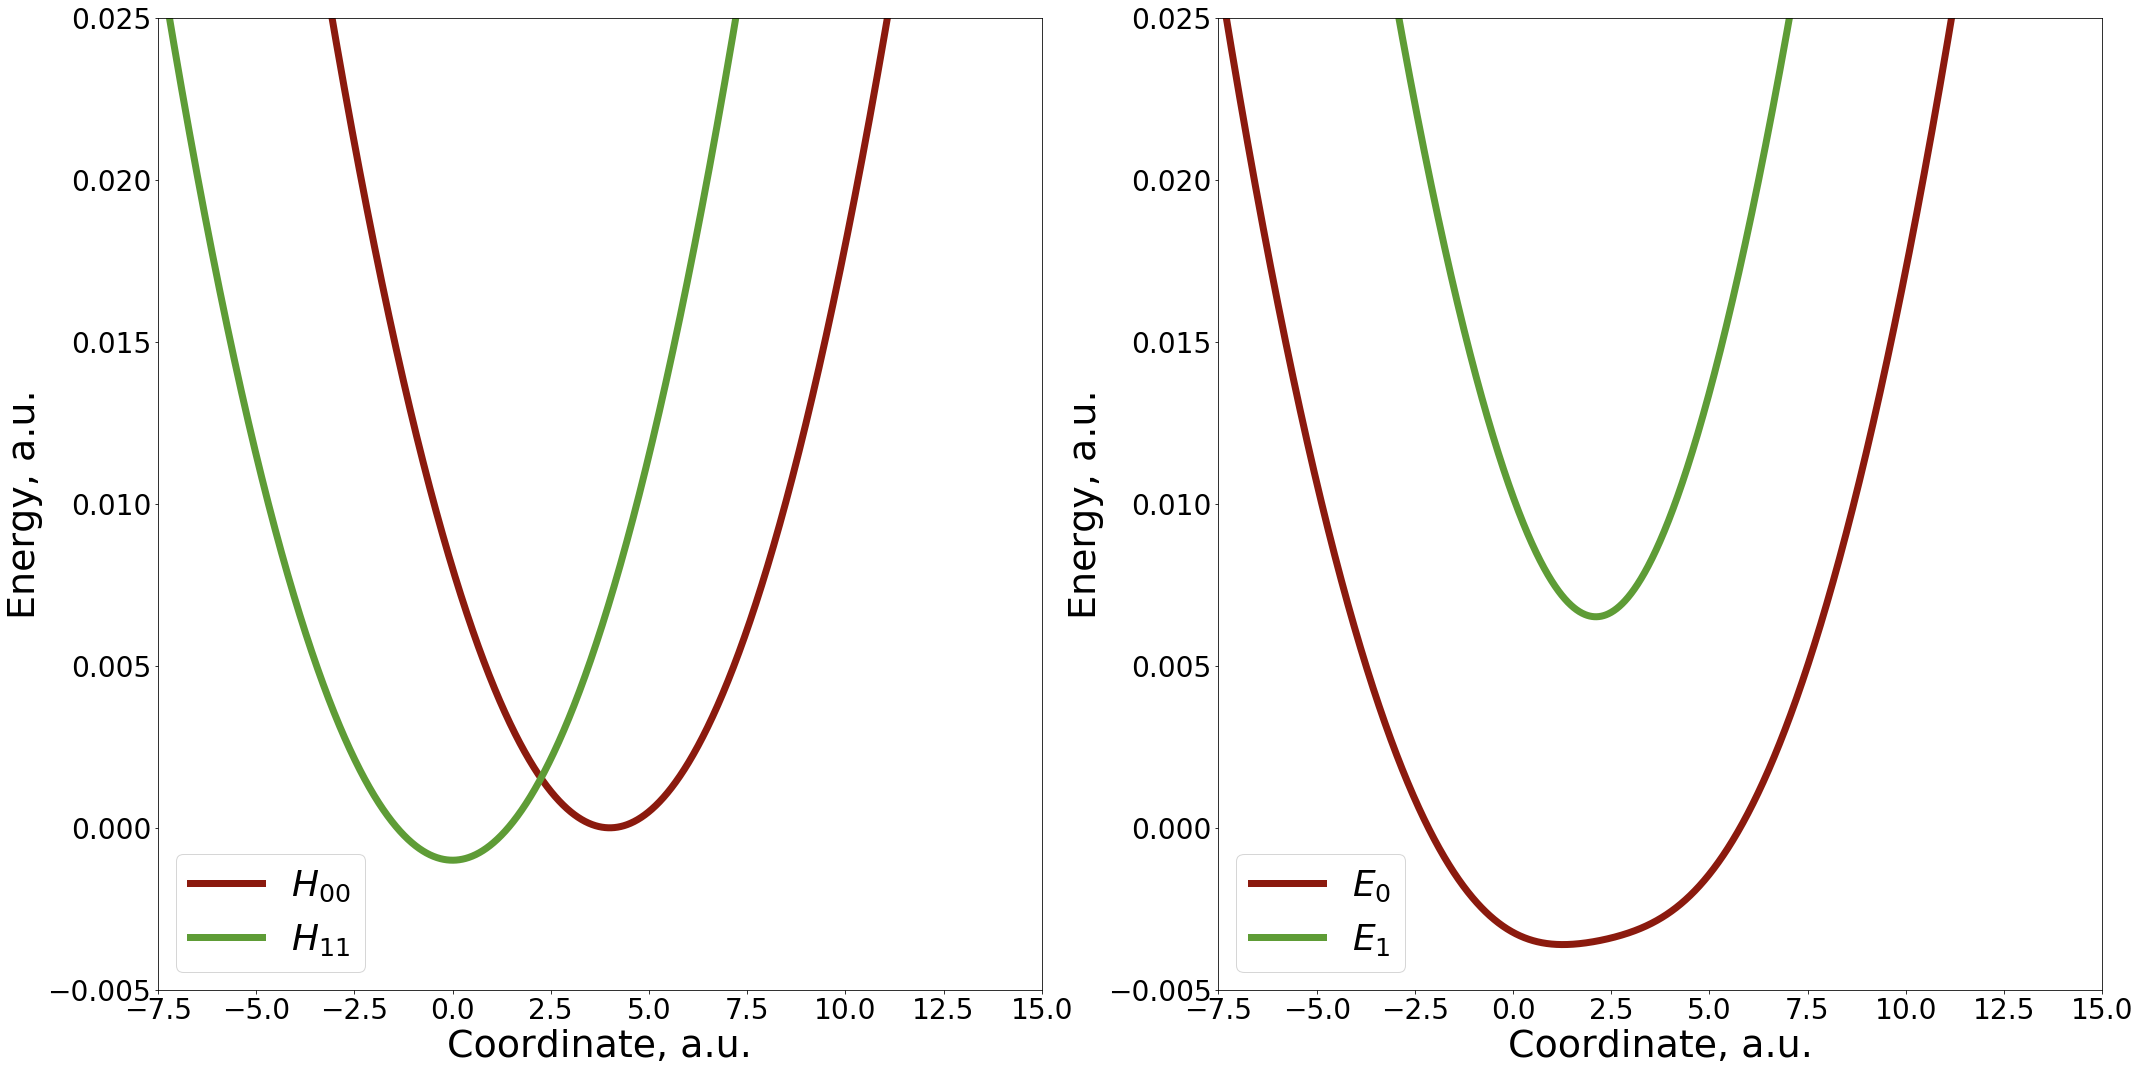

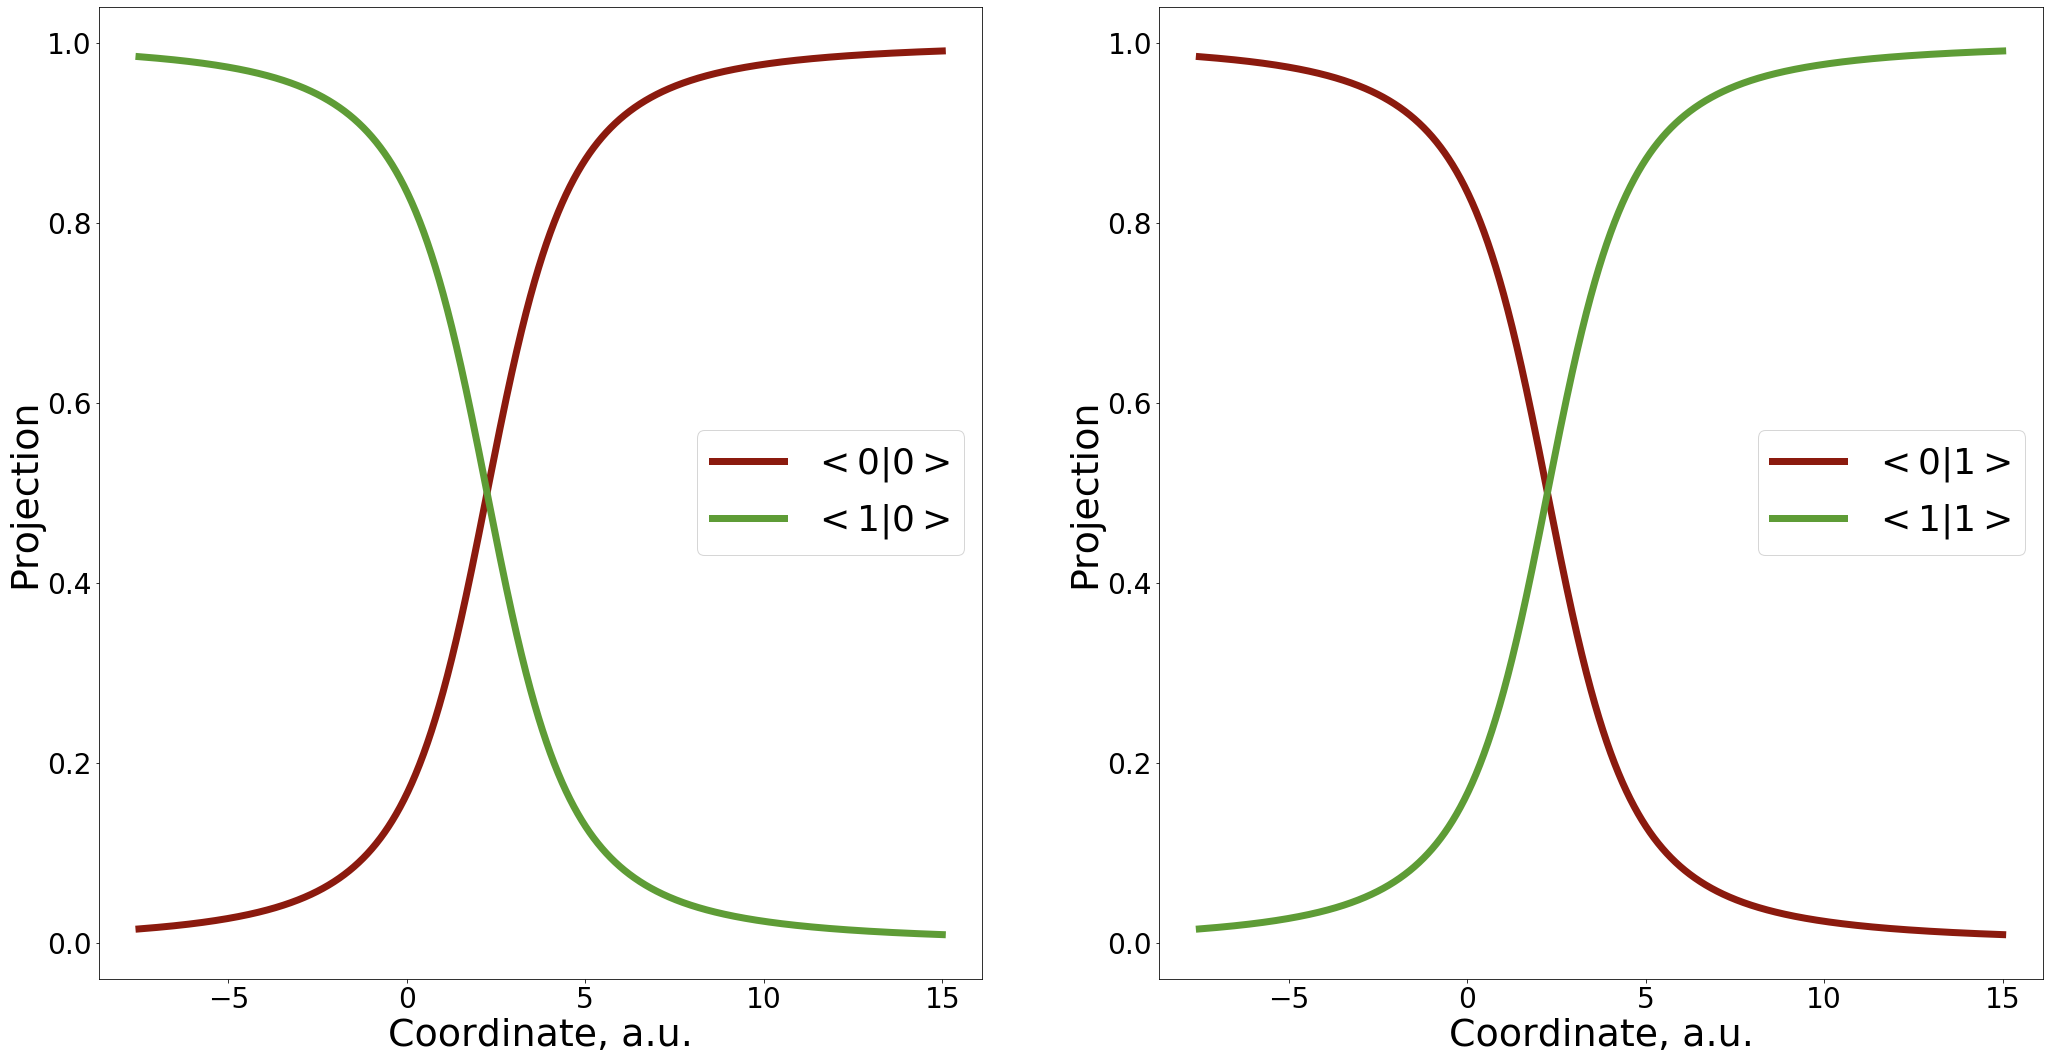

In [8]:
plot_surfaces(compute_model, [ param_sets[0] ], [0,1])

<a name="methods"></a> [Back to TOC](#TOC)

## 3. Methods for integrating the TD-SE dynamics


All the methods defined below share many common parts 

In all calculations below, we start with the wavefunction defined as a single Gaussian wavepacket defined by:

$\psi(x) = (\frac{1}{2.0 \pi (\Delta x)^2}) ^\frac{1}{4} exp[ -(\frac{(x-x_0)}{2\Delta x})^2 + i (x-x_0) p_{x,0} ]$

This wavefunction corresponds to the probability density:

$P(x) = |\psi(x)|^2 = (\frac{1}{2.0 \pi (\Delta x)^2}) ^\frac{1}{2} exp[ -\frac{(x-x_0)^2}{2(\Delta x)^2} ] = \
  \frac{1}{ \Delta x \sqrt {2.0\pi } } exp[ -\frac{1}{2} (\frac{x-x_0} {\Delta x} )^2 ]
$


That is according to [this article](https://en.wikipedia.org/wiki/Normal_distribution):  

$(\Delta x)^2$ - variance (in the classical distribution)

$2 \Delta x$ - is the standard deviation: the full width at the half-maximum (FWHM)

In classical simulations, this distribution can be sampled using the normally-distributed random numbers like:

    x_i = x_ * dx * rnd.normal()
    
Don't confuse the variable `dx` used here with the grid spacing, which will be discussed later.


Now, recall the solution of the quantum-mechanical harmonic oscillator problem. For the Hamiltonian of the form:

$ H = \frac{p^2}{2m} + \frac{k x^2}{2} $

the ground state wavefunction will be of the form:

$\psi(x) \approx exp(-\frac{a}{2}x^2)$

with 

$a = \frac{m\omega}{\hbar}$, with $\omega = \sqrt{\frac{k}{m}}$

or 
$a = \frac{(km)^{1/2}}{\hbar}$

Then, one can find that:

$\sigma_x^2 = \frac{\hbar}{2} (km)^{-1/2}$

$\sigma_p^2 = \frac{\hbar}{2} (km)^{1/2}$

Finally, we obtain:

$\sigma_x^2 = \frac{1}{2a}$

$\sigma_p^2 = \frac{a\hbar^2}{2}$

The property $\sigma_x$ is the same as the parameter $\Delta x$ introduced above.

In other words, if we want to select the width of the initial wavepacket to be that of the HO's ground state wavefunction, we can compute it based on the mass of the particle `m` and the HO force constant `k`. 

This is done in the instruction:

    sigmax2 = 0.5*math.sqrt(1.0/(k*mass))        
    dx0 = Py2Cpp_double([math.sqrt(sigmax2)])        
    
Keep in mind, we always work in a.u., so $\hbar = 1$ and it doesn't appear in our instructions.

Both the `mass` and `k` are the parameters given in the input.

We can set up the initial position and the group momentum of the wavepacket via the instructions:

    x0 = Py2Cpp_double([0.0])
    p0 = Py2Cpp_double([0.0])

____

Other common instructions, which appear in all methods below:

1. **Initialization of the grid** We select the lower and upper boundaries of the grid and the frid spacing. But keep in mind, that the grid is always adjusted to have $2^n$ points, so the actual upper bound may be larger than the one we setup, but the lower boundary stays the same. In the initialization, we also define for how many quantum states will the grid be initialized:

        wfc = Wfcgrid2(Py2Cpp_double([-15.0]), Py2Cpp_double([15.0]),  Py2Cpp_double([dx]), nstates)
    
    
2. **Compute the Hamiltonian on the grid** This method calls the function `potential` that computes adiabatic/diabatic Hamiltonian matrix elements (and related properties, such as derivative couplings) for all grid points. The parameter `model_params` is passed here to be passed to the `potential` function, to control how to do those calculations. Finally, the last parameter defines the representation for which we want to update the matrix elements: 0 - diabatic, 1 - adiabatic. Depending on the type of calculations (e.g. what type of properties are used in the calculations/propagation), we may need one type of data or another. This function can be called before the actual wavefunction is added to the grid.

        wfc.update_Hamiltonian(potential, model_params, 0) 
    
3. **Compute diabatic-to-adiabatic transformation and $exp( -\frac{1}{2} i  H_{dia} * \Delta t)$** This function not only computes the exponential propagator (to be used in SOFT and Colbert-Miller-SOFT), but also the adiabatic Hamiltonian, $H_{adi}$, and the corresponding transformation matrix $U$ by solving the eigenvalue problem: $H_{dia} U = U * H_{adi}$ This function must be called, if we need to compute properties for another representation (e.g. diabatic), even if our propagation is done in another one (e.g. diabatic). Also, it is needed to properly initilize the wavefunctions, when it is given in another representation. For instance, in all cases, we initialize the wavefunction to be a Gaussian wavepacket in the adiabatic representation, but in methods like SOFT, we need to know wfc in the diabatic representation. 

        wfc.update_propagator_H(0.5*dt)    
        
4. **Initializing (adding) the wavefunction** Or adding it to the grid. There are several types of elementary wavefunctions to add, such as any HO eigenvalues or simply the the Gaussian wavepacket. All of them can be "running" that is may have the group momentum term. The reason it is called "adding" is because, we can call the "add_" function several time to initialize more and more complex initial wavefunction. One would provide the weights needed for such a superposition as well as one would state to which state (adiabatic or diabatic) the corresponding function is added. The last argument controls the type of representation: 0 - diabatic, 1 - adiabatic. 

        wfc.add_wfc_Gau(x0, p0, dx0, istate, 1.0+0.0j, 1)   # Add to the adiabatic state

5. **Updating other representation** This can be done with the instructions like

        wfc.update_diabatic()
        wfc.update_adiabatic()
        
    In both cases, one would need to run the `wfc.update_propagator_H(0.5*dt)` function first, to compute the transormation matrix. In this example, we always set up the initial wavefunction as the adiabatic wavepacket, but if the propagation is done in the diabatic basis, we'd need to use the `wfc.update_diabatic()` first to initialize the diabatic wavefunction. Likewise, as we evolve the diabatic functions, we may want to compute properties that are properly defined in the adiabatic representation (e.g. kinetic energy), so we call the corresponding transformation to the adiabatic representation first via `wfc.update_adiabatic()`. In the current tutorial, this may be done after every timestep. 

6. **Updating the reciprocals** Technically speaking, when computing the properties like kinetic energy, we really deal with the wavefunctions in the reciprocal (Fourier) space, at least so far. This should not be really a requirement, but that's how things are coded so far. Thus, in order for the propagation of the real-space wavefunction to take effect in this type of calculations, we need to do the transforms:

        wfc.update_reciprocal(0)  # to update the reciprocal of the diabatic wavefunction
        wfc.update_reciprocal(1)  # to update the reciprocal of the adiabatic wavefunction

7. **Computing properties** We can also compute various types of properties, using the diabatic (parameter 0) or adiabatic (parameter 1) wavefunctions and their reciprocals (when suitable). Here is the list of the methods to compute these properties:

    * wavefunction norm
    
            wfc.norm(0)
            wfc.norm(1)

    * kinetic energy 
    
            wfc.e_kin(masses, 0)
            wfc.e_kin(masses, 1)
            
    * potential energy 
    
            wfc.e_pot(0)
            wfc.e_pot(1)
            
    * $<q^n>$
     
            wfc.get_pow_q(0, n).get(idof).real   # in diabatic rep
            wfc.get_pow_q(1, n).get(idof).real   # in adiabatic rep
            
    * $<p^n>$
     
            wfc.get_pow_p(0, n).get(idof).real   # in diabatic rep
            wfc.get_pow_p(1, n).get(idof).real   # in adiabatic rep            

    * density matrix
    
            wfc.get_den_mat(0)
            wfc.get_den_mat(1)


Below, we will also illustrate a few other methods of the the `Wfcgrid2` class, which are needed for more specific integration methods.

In [9]:
def init_wfc(params, _potential, model_params ):
    """
    This is a generic and a bit excessive initialization procedure - some of the parameters
    may not be needed for some of the methods, but it allows us to have a simple structure of the program
    
    istate = [rep, index_of_the_state]
    
    """
            
    critical_params = []
    default_params = { "nsteps":200, "dt":10.0, "progress_frequency":0.1,
                       "rmin":[-15.0], "rmax":[15.0], "dx":[0.1], "nstates":2,
                       "x0":[0.0], "p0":[0.0], "istate":[1,0], "masses":[2000.0], "k":[0.001]
                      }
    comn.check_input(params, default_params, critical_params)
    
    # Grid properties 
    dx = Py2Cpp_double(params["dx"])
    rmin = Py2Cpp_double(params["rmin"])
    rmax = Py2Cpp_double(params["rmax"])
    nstates = params["nstates"]  

    # Dynamical properties 
    nsteps = params["nsteps"]
    dt = params["dt"]    
    
    # Properties of the initial wavefunction
    istate = params["istate"]          
    k = params["k"]
    masses = Py2Cpp_double(params["masses"])
    

    x0 = Py2Cpp_double(params["x0"])
    p0 = Py2Cpp_double(params["p0"])
    ndof = len(x0)
    
    dx0_tmp = []
    for idof in range(ndof):
        sigmax2 = 0.5*math.sqrt(1.0/(k[idof]*masses[idof]))        
        dx0_tmp.append(math.sqrt(sigmax2))
    dx0 = Py2Cpp_double(dx0_tmp)    
        
        
    
    # Here we initialize the grid and wavefunction
    wfc = Wfcgrid2( rmin, rmax,  dx, nstates)
    
    wfc.direct_allocate_tmp_vars(0)    # last time-step wavefunction, diabatic rep
    wfc.direct_allocate_tmp_vars(1)    # last time-step wavefunction, adiabatic rep

    
    wfc.update_Hamiltonian(_potential, model_params, 0)  # update Hamiltonian: diabatic -
                                                        # need to compute diabatic-to-adiabatic transform
    wfc.update_Hamiltonian(_potential, model_params, 1)  # update Hamiltonian: adiabatic, NACs
        
    wfc.update_propagator_H(0.5*dt)                     # copute the dia-to-adi transform + exp(-i* V *dt/2)
    
    wfc.add_wfc_Gau(x0, p0, dx0, istate[1], 1.0+0.0j, istate[0])   # Add to the diabatic or adiabatic state
        
    if istate[0]==0:
        # If we added a diabatic state:
        wfc.update_adiabatic()        # update adiabatic wavefunction    
            
    elif istate[0]==1:
        # If we added an adiabatic state:
        wfc.update_diabatic()        # update diabatic wavefunction            
    
    
    wfc.update_propagator_K(dt, masses) # update reci space propagator in diabatic rep, exp(-iTdt) 
    wfc.update_reciprocal(1)     # update reci of adiabatic function        
    wfc.update_reciprocal(0)     # update reci of diabatic function
        
        
    print( "Norm (dia) = ", wfc.norm(0) )
    print( "Norm (adi) = ", wfc.norm(1) )
    print( "Ekin (dia) = ", wfc.e_kin(masses, 0) )
    print( "Ekin (adi) = ", wfc.e_kin(masses, 1) )
    print( "Epot (dia) = ", wfc.e_pot(0) )
    print( "Epot (adi) = ", wfc.e_pot(1) )

    
    return wfc

In [10]:
def save_data_hdf5(step, wfc, saver, params):
    
    dt = params["dt"]    
    masses = Py2Cpp_double(params["masses"])
    hdf5_output_level = params["hdf5_output_level"]
    
    if hdf5_output_level>=1:
        saver.save_scalar(step, "timestep", step) 
        saver.save_scalar(step, "time", step * dt)        
        saver.save_scalar(step, "Ekin_dia", wfc.e_kin(masses, 0)) 
        saver.save_scalar(step, "Ekin_adi", wfc.e_kin(masses, 1))         
        saver.save_scalar(step, "Epot_dia", wfc.e_pot(0)) 
        saver.save_scalar(step, "Epot_adi", wfc.e_pot(1))         
        saver.save_scalar(step, "Etot_dia", wfc.e_tot(masses, 0)) 
        saver.save_scalar(step, "Etot_adi", wfc.e_tot(masses, 1))                 
        saver.save_scalar(step, "norm_dia", wfc.norm(0) )
        saver.save_scalar(step, "norm_adi", wfc.norm(1) )
        
        
    if hdf5_output_level>=2:    
        saver.save_matrix(step, "pop_dia", wfc.get_pops(0) ) 
        saver.save_matrix(step, "pop_adi", wfc.get_pops(1) )     
        saver.save_matrix(step, "q_dia", wfc.get_pow_q(0, 1) ) 
        saver.save_matrix(step, "q_adi", wfc.get_pow_q(1, 1) )         
        saver.save_matrix(step, "q2_dia", wfc.get_pow_q(0, 2) ) 
        saver.save_matrix(step, "q2_adi", wfc.get_pow_q(1, 2) )         
        saver.save_matrix(step, "p_dia", wfc.get_pow_p(0, 1) ) 
        saver.save_matrix(step, "p_adi", wfc.get_pow_p(1, 1) )         
        saver.save_matrix(step, "p2_dia", wfc.get_pow_p(0, 2) ) 
        saver.save_matrix(step, "p2_adi", wfc.get_pow_p(1, 2) ) 
        
        
    if hdf5_output_level>=3:                
        saver.save_matrix(step, "denmat_dia", wfc.get_den_mat(0) ) 
        saver.save_matrix(step, "denmat_adi", wfc.get_den_mat(1) ) 
        
        
    if hdf5_output_level>=4:                
        """
        This is REALLY-REALLY bad option to go since it is soo time-consuming
        """
        
        for ipt in range(wfc.Npts):
            saver.save_multi_matrix(step, ipt, "PSI_dia", wfc.PSI_dia[ipt]) 
            
        for ipt in range(wfc.Npts):            
            saver.save_multi_matrix(step, ipt, "PSI_adi", wfc.PSI_adi[ipt]) 
            
        for ipt in range(wfc.Npts):
            saver.save_multi_matrix(step, ipt, "reciPSI_dia", wfc.reciPSI_dia[ipt]) 
            
        for ipt in range(wfc.Npts):            
            saver.save_multi_matrix(step, ipt, "reciPSI_adi", wfc.reciPSI_adi[ipt])             

            

def save_data_mem(step, wfc, saver, params):
    
    dt = params["dt"]    
    masses = Py2Cpp_double(params["masses"])
    mem_output_level = params["mem_output_level"]
    
    
    if mem_output_level>=1:         
        saver.add_data("timestep", step)
        saver.add_data("time", step * dt)
        saver.add_data("Ekin_dia", wfc.e_kin(masses, 0) )
        saver.add_data("Ekin_adi", wfc.e_kin(masses, 1) )
        saver.add_data("Epot_dia", wfc.e_pot(0) )
        saver.add_data("Epot_adi", wfc.e_pot(1) )
        saver.add_data("Etot_dia", wfc.e_tot(masses, 0) )
        saver.add_data("Etot_adi", wfc.e_tot(masses, 1) )
        saver.add_data("norm_dia", wfc.norm(0) )
        saver.add_data("norm_adi", wfc.norm(1) )

    if mem_output_level>=2:        
        saver.add_data("pop_dia", wfc.get_pops(0) ) 
        saver.add_data("pop_adi", wfc.get_pops(1) )     
        saver.add_data("q_dia", wfc.get_pow_q(0, 1) ) 
        saver.add_data("q_adi", wfc.get_pow_q(1, 1) )         
        saver.add_data("q2_dia", wfc.get_pow_q(0, 2) ) 
        saver.add_data("q2_adi", wfc.get_pow_q(1, 2) )         
        saver.add_data("p_dia", wfc.get_pow_p(0, 1) ) 
        saver.add_data("p_adi", wfc.get_pow_p(1, 1) )         
        saver.add_data("p2_dia", wfc.get_pow_p(0, 2) ) 
        saver.add_data("p2_adi", wfc.get_pow_p(1, 2) )         

    if mem_output_level>=3:        
        saver.add_data("denmat_dia", wfc.get_den_mat(0) )  
        saver.add_data("denmat_adi", wfc.get_den_mat(1) )         
        
    if mem_output_level>=4:                
        saver.add_data("PSI_dia", wfc.PSI_dia) 
        saver.add_data("PSI_adi", wfc.PSI_adi) 
        saver.add_data("reciPSI_dia", wfc.reciPSI_dia) 
        saver.add_data("reciPSI_adi", wfc.reciPSI_adi) 
        

______________

This function defines the common computational flow for all integrators.

Depending on particular integrator, we would select additional preparation and processing steps

In [11]:
def run_dynamics(wfc, params, model_params, savers):
    
    integrators_map = {"SOFT": 0,
                       "direct_dia": 1,
                       "direct_adi": 2,
                       "Colbert_Miller_dia":3,
                       "Colbert_Miller_adi":4,
                       "Colbert_Miller_SOFT":5
                      }
    integrator_id = integrators_map[ params["integrator"] ]
        
    nsteps = params["nsteps"]      
    print_freq = int(params["progress_frequency"]*nsteps)    
    dt = params["dt"]    
    masses = Py2Cpp_double(params["masses"])    
    
            
    
    #================ Special setups ===================
    expT, expV = None, None
    if integrator_id == 5:
       
        T = wfc.operator_T(Py2Cpp_int([1]), masses, 1.0+0.0j) 
    
        expT = CMATRIX(wfc.Npts, wfc.Npts)
        exp_matrix(expT, T, -dt*1.0j, 0)
    
        expV = CMATRIXList()
        for ipt in range(wfc.Npts):
            expv = CMATRIX(wfc.nstates, wfc.nstates)
            exp_matrix(expv, wfc.Hdia[ipt], -dt*0.5j, 0);        
            expV.append(CMATRIX(expv))
        
        
    #=============== Propagation ==========================
        
    for step in range(nsteps):
        
        #================ Saving the data ==================
        if step%print_freq==0:
            print(F" step= {step}")
            
        # Save properties
        if savers["hdf5_saver"] != None:            
            save_data_hdf5(step, wfc, savers["hdf5_saver"], params)
            
        if savers["txt_saver"] != None:            
            save_data_txt(step, wfc, savers["txt_saver"], params)
            
        if savers["mem_saver"] != None:            
            #save_data_mem(step, wfc, savers["mem_saver"], params)
            prms = dict(params)
            prms["hdf5_output_level"] = params["mem_output_level"]
            save_data_hdf5(step, wfc, savers["mem_saver"], prms)
    
        #================ Integration ==================
    
        if integrator_id==0:  # SOFT            
            wfc.SOFT_propagate()      # evolve the diabatic wfc 
            
        elif integrator_id == 1: # direct_dia
            if step==0:            
                wfc.direct_propagate_dia1(dt, masses)                           
            else:
                wfc.direct_propagate_dia2(dt, masses)                          
                
        elif integrator_id == 2: # direct_adi
            if step==0:            
                wfc.direct_propagate_adi1(dt, masses)                           
            else:
                wfc.direct_propagate_adi2(dt, masses)                                          
                
        elif integrator_id == 3: # Colbert-Miller_dia        
            if step==0:            
                wfc.Colbert_Miller_propagate_dia1(dt, masses)                           
            else:
                wfc.Colbert_Miller_propagate_dia2(dt, masses)                          

        elif integrator_id == 4: # Colbert-Miller_adi        
            if step==0:            
                wfc.Colbert_Miller_propagate_adi1(dt, masses)                           
            else:
                wfc.Colbert_Miller_propagate_adi2(dt, masses)                                          

        elif integrator_id == 5: # Colbert-Miller_SOFT        
            wfc.Colbert_Miller_SOFT(expT, expV, 0)    
            
            
        #============= Update other variables ================
        if integrator_id in [0, 1, 3, 5]:
            wfc.update_adiabatic()  
            
        if integrator_id in [2, 4]:
            wfc.update_diabatic()              
        
        wfc.update_reciprocal(0)  # update reci of diabatic function
        wfc.update_reciprocal(1)  # update reci of adiabatic function
        
          

Finally, lets define a function that would provide a common interface to all different types of integration

In [12]:
def run_case(_params, _potential, model_params):
    
        
    params = dict(_params)                
    nstates = len(model_params["E_n"])
    nsteps = params["nsteps"]
    print_freq = int(params["progress_frequency"]*nsteps)    
    params.update({"nstates":nstates})
            
    
    print("Run calculations with the dynamical parameters ", params)
    print("Run calculations with the model parameters ", model_params)    
    
        
    wfc = init_wfc(params, _potential, model_params )
    ndof = wfc.ndof
    ngrid = wfc.Npts
    
    
    #================ Create savers ==================    
    # Create an output directory, if not present  
    prefix = params["prefix"]
    
    if not os.path.isdir(prefix):
        os.mkdir(prefix)
            
    # Simulation parameters                    
    f = open(F"{prefix}/_dyn_params.txt","w")
    f.write( str(params) );  f.close()
    
    f = open(F"{prefix}/_model_params.txt","w")
    f.write( str(model_params) );  f.close()    

    
    
    properties_to_save = params["properties_to_save"]
    
    #====== HDF5 ========
    hdf5_saver = None
    hdf5_output_level = params["hdf5_output_level"]
    
    if hdf5_output_level > 0:                
        hdf5_saver = data_savers.hdf5_saver(F"{prefix}/data.hdf", properties_to_save) 
        hdf5_saver.set_compression_level(params["use_compression"], params["compression_level"])
        save.exact_init_hdf5(hdf5_saver, hdf5_output_level, nsteps, ndof, nstates, ngrid)

    #====== TXT ========
    txt_saver = None
    if params["txt_output_level"] > 0:
        pass
    
    #====== MEM =========
    mem_saver = None
    if params["mem_output_level"] > 0:
        mem_saver =  data_savers.mem_saver(properties_to_save)        
        save.exact_init_hdf5(mem_saver, params["mem_output_level"], nsteps, ndof, nstates, ngrid)
        #save.exact_init_custom_hdf5(params["mem_output_level"], nsteps, ncustom_pops, nstates)  # boxed populations on adiabatic/diabatic states

                         
    savers = {"hdf5_saver":hdf5_saver, "txt_saver":txt_saver, "mem_saver":mem_saver }
    

    #==================== Dynamics ======================    
    start = time.time()                               
    
    res = run_dynamics(wfc, params, model_params, savers)                     
    
    end = time.time()    
    print(F"Calculation time = {end - start} seconds")

    
    
    if mem_saver != None:        
        return mem_saver

        
    """
    t, q, p, Ddia, Dadi, Ekin, Epot, Etot = None, None, None,  None, None,  None, None, None
    nrm0, nrm1 = None, None
    start = time.time()
    if method=="SOFT":
        t, q, p, Ddia, Dadi, Ekin, Epot, Etot, nrm0, nrm1 = run_exact_SOFT(wfc, params, model_params)
    elif method=="direct_dia":
        t, q, p, Ddia, Dadi, Ekin, Epot, Etot, nrm0, nrm1 = run_exact_direct_dia(wfc, params, model_params)
    elif method=="direct_adi":
        t, q, p, Ddia, Dadi, Ekin, Epot, Etot, nrm0, nrm1 = run_exact_direct_adi(wfc, params, model_params)
    elif method=="Colbert_Miller_dia":
        t, q, p, Ddia, Dadi, Ekin, Epot, Etot, nrm0, nrm1 = run_exact_Colbert_Miller_dia(wfc, params, model_params)
    elif method=="Colbert_Miller_adi":
        t, q, p, Ddia, Dadi, Ekin, Epot, Etot, nrm0, nrm1 = run_exact_Colbert_Miller_adi(wfc, params, model_params)        
    elif method=="Colbert_Miller_SOFT":
        t, q, p, Ddia, Dadi, Ekin, Epot, Etot, nrm0, nrm1 = run_exact_Colbert_Miller_SOFT(wfc, params, model_params)                
    end = time.time()
    
    print(F"Calculation time = {end - start} seconds")
    """

    """
    if not os.path.isdir(prefix):
        os.mkdir(prefix)

    prms = dict(params)
    prms.update({"method":method})    
    prms.update(model_params)

    f = open("%s/params.txt" % (prefix),"w")
    f.write( str(prms) )
    f.close()

    list2bin(t, "%s/t" % (prefix) )
    list2bin(q, "%s/q" % (prefix) )
    list2bin(p, "%s/p" % (prefix) )
    list2bin(Ekin, "%s/Ekin" % (prefix) )
    list2bin(Epot, "%s/Epot" % (prefix) )
    list2bin(Etot, "%s/Etot" % (prefix) )
    list2bin(nrm0, "%s/nrm0" % (prefix) )
    list2bin(nrm1, "%s/nrm1" % (prefix) )

    # Adiabatic populations
    for i in range(nstates):
        Pi = data_conv.unpack1(Dadi, i, i, 0)
        list2bin(Pi, "%s/adi_P%i" % (prefix, i))
    
        Pi = data_conv.unpack1(Ddia, i, i, 0)
        list2bin(Pi, "%s/dia_P%i" % (prefix, i))
    """    

Below, we provide some more explanation on how each integrator works

<a name="soft"></a> [Back to TOC](#TOC)

### 3.1. Split-Operator-Fourier-Transform (SOFT) 

This is the famous method by Kosloff and Kosloff.

One starts with the Hamiltonian in a separable form: $ H = T + V $

The solution of the TD-SE, $i \hbar \frac{\partial \psi}{\partial t} = H\psi $ is given by:

$\psi (t) = exp(-i \hbar t \hat H) \psi (0)$

The exponent is then factorized as 

$exp(-i \hbar t \hat H) = exp(-i \frac{1}{2} \hbar t \hat V) exp(-i \hbar t \hat T) exp(-i \frac{1}{2} \hbar t \hat V) $

The action of the $exp(-i \frac{1}{2} \hbar t \hat V)$ operator is computed in the the real space. the corresponding propagator (for time interval $\frac{1}{2}\Delta t$) is computed by:

    wfc.update_propagator_H(0.5*dt)  
    
The action of the $exp(-i \frac{1}{2} \hbar t \hat T)$ operator is computed in the the reciprocal space, the corresponding propagator (for time interval $\Delta t$) is computed by:
    
    wfc.update_propagator_K(dt, masses)
 
The propagators are computed only once and can be re-used to evolve the dynamics for an indefinite time. 
The repeated application of these propagators (together with the updates of the real and reciprocal-space wavefunctions) constitutes the action of the integratior. One spet of the propagation is done by the function:
 
    wfc.SOFT_propagate()

<a name="direct-dia"></a> [Back to TOC](#TOC)

### 3.2. Direct, Verlet-like integrator for diabatic representation

<a name="direct-adi"></a> [Back to TOC](#TOC)

### 3.3. Direct, Verlet-like integrator for adiabatic representation

<a name="direct-colbert-miller-dia"></a> [Back to TOC](#TOC)

### 3.4. Direct, Verlet-like integrator + Colbert-Miller DVR for kinetic energy, for diabatic representation

<a name="direct-colbert-miller-adi"></a> [Back to TOC](#TOC)

### 3.5. Direct, Verlet-like integrator + Colbert-Miller DVR for kinetic energy, for adiabatic representation

<a name="soft-colbert-miller"></a> [Back to TOC](#TOC)

### 3.6. SOFT + Colbert-Miller DVR for kinetic energy in real space, for diabatic representation

<a name="calcs"></a> [Back to TOC](#TOC)
## 4. Calculations: almost adiabatic case

Here, we'll do the calculations. In this tutorial, we only consider 1D models, so the parameters will be 1D. 

First, lets set up common parameters controlling the dynamics and defining system's properties

* `dt` - integration time step, in a.u. of time
* `nsteps` - how many steps of the dynamics to do
* `dx` - points spacing on the grid, in a.u. of length (Bohr)
* `istate` - initial state, starting from 0
* `mass` - the mass of the particle, in a.u. of mass (so proton mass is about 2000 a.u.)
* `k` - force constant of the harmonic potential which defines the harmonic oscillator (HO) eigenstates that may be used in the sampling initial condition of our wavepacket

> **Note**: the choise of the parameters `dt` and `dx` is not totally independent - one needs to look at the magnitude of the property  $\frac{dt}{dx^2}$ for it determines the stability of the integration scheme. So, if you use finer spatial grids (smaller `dx`), you need to progressively decrease `dt` to keep the fraction constant. As follows from the formula, if you have the dynamics more-or-less stable for say `dt = 1.0` and `dx = 0.1`, to keep it at a comparable level of stability for `dx = 0.01`, one would need to decrease `dt` by a factor of 100, that is `dt = 0.01`

> The relation between `dt` and `dx` can be easily understood as follows: the `dx` determines the range of the grid in the reciprocal (momentum) space. Thus, the smaller `dx`, the larger momenta are accessible in the dynamics. Thus, similar to classical dynamics, where large momenta require smaller integration time-steps to be stable, the `dt` parameter should be decreased in quantum simulations as well.
  

In [13]:
model_params = dict(param_sets[0])

properties_to_save = [ "timestep", "time", "Ekin_dia", "Ekin_adi", "Epot_dia", 
                       "Epot_adi", "Etot_dia", "Etot_adi", "norm_dia", "norm_adi",
                       "pop_dia", "pop_adi", "q_dia", "q_adi", "q2_dia", "q2_adi", 
                       "p_dia", "p_adi", "p2_dia", "p2_adi",
                       "denmat_dia", "denmat_adi", 
                       "PSI_dia", "PSI_adi", "reciPSI_dia", "reciPSI_adi" ] 

params = { "nsteps":500, "dt":10.0, "progress_frequency":0.1,
           "rmin":[-15.0], "rmax":[15.0], "dx":[0.1], "nstates":2,
           "x0":[0.0], "p0":[0.0], "istate":[1,0], "masses":[2000.0], "k":[0.001],           
           "integrator":"SOFT",
          
           "prefix":"case1-1",
           "hdf5_output_level":0, "compression_level":[0,0,0], "use_compression":0,
           "mem_output_level":3, 
           "txt_output_level":0,
           "properties_to_save": properties_to_save
         }

Now, lets just run each type of integration and plot the corresponding results.

We can also customize the input parameters for each particular run, but for consistency of all test calculations, it may be preferable to have the parameters defined only once, here.

<a name="res-soft"></a> [Back to TOC](#TOC)
### 4.1. SOFT

Some estimates for the output size:

for the

    {hdf5_output_level":4, "compression_level":[4,4,9]}
    
it takes 290 sec to complete just 20 steps (less than 1 sec of that time is the actual calculation) and the data file is about 190 Mb of data - that's a lot!


for the 

    {hdf5_output_level":4, "compression_level":[0,0,0]}

it takes 248 sec to complete just 20 steps and the data file is now 1.5 Mb of data - that's a bit better, but not fast enough

In [14]:
params1 = dict(params)
params1.update({ "prefix":"case1-1",  "integrator":"SOFT"   })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 500, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'case1-1', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00018012185796967037
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  -0.00310967191719

In [15]:
print(res.np_data)

{'timestep': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177,

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


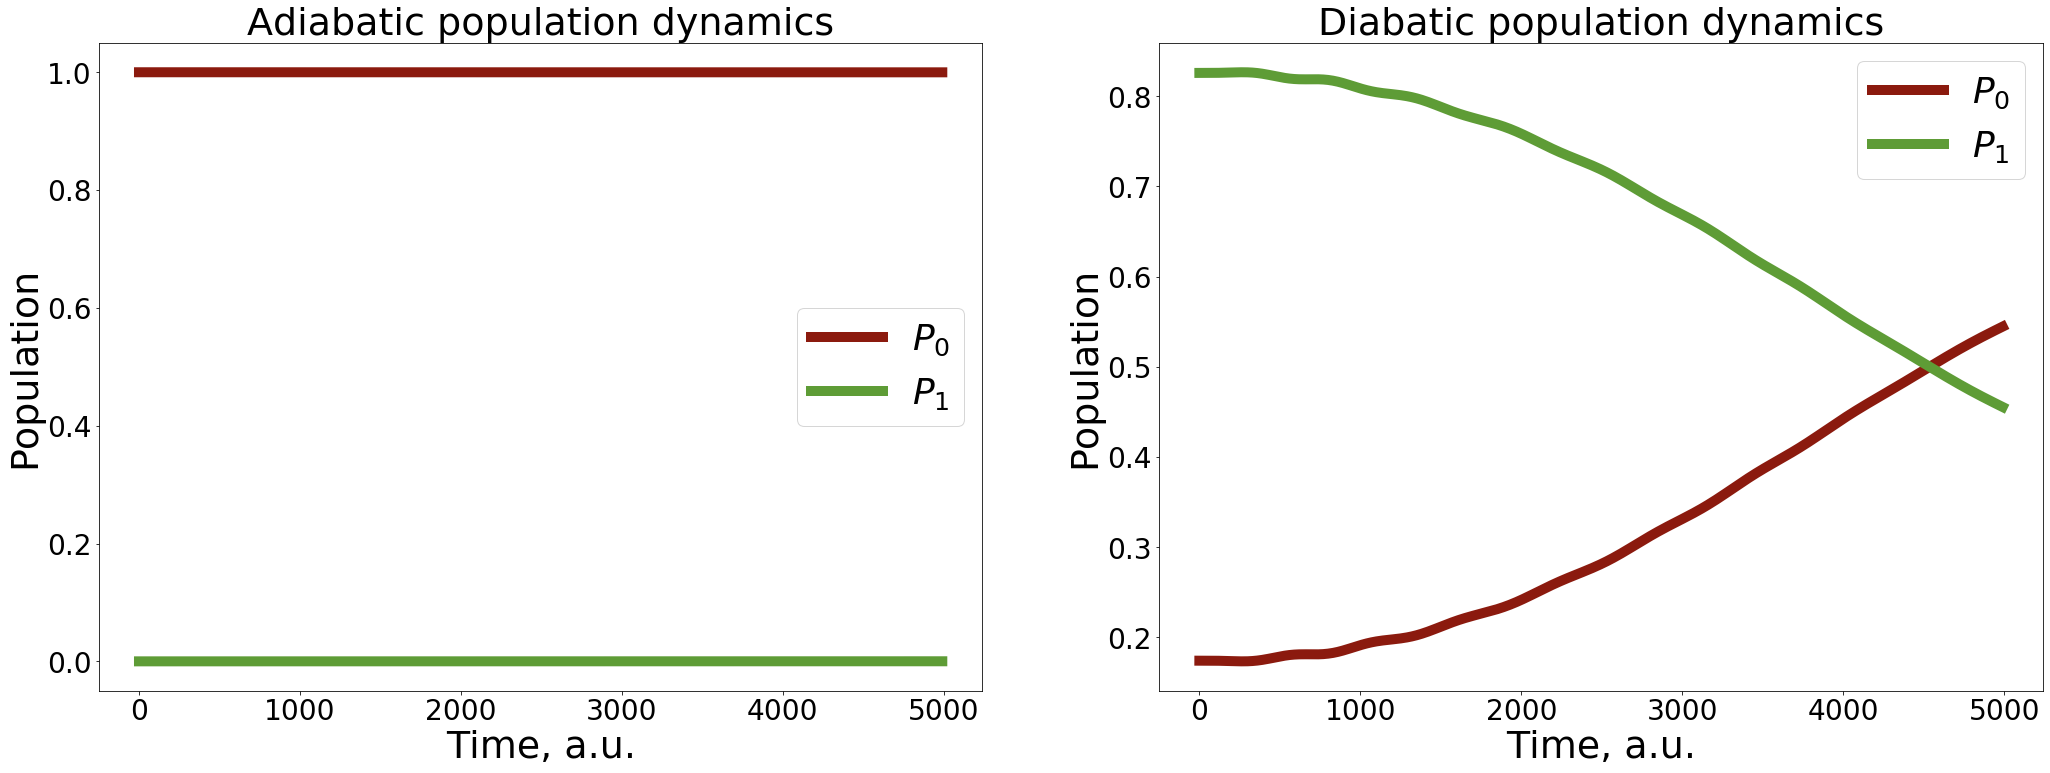

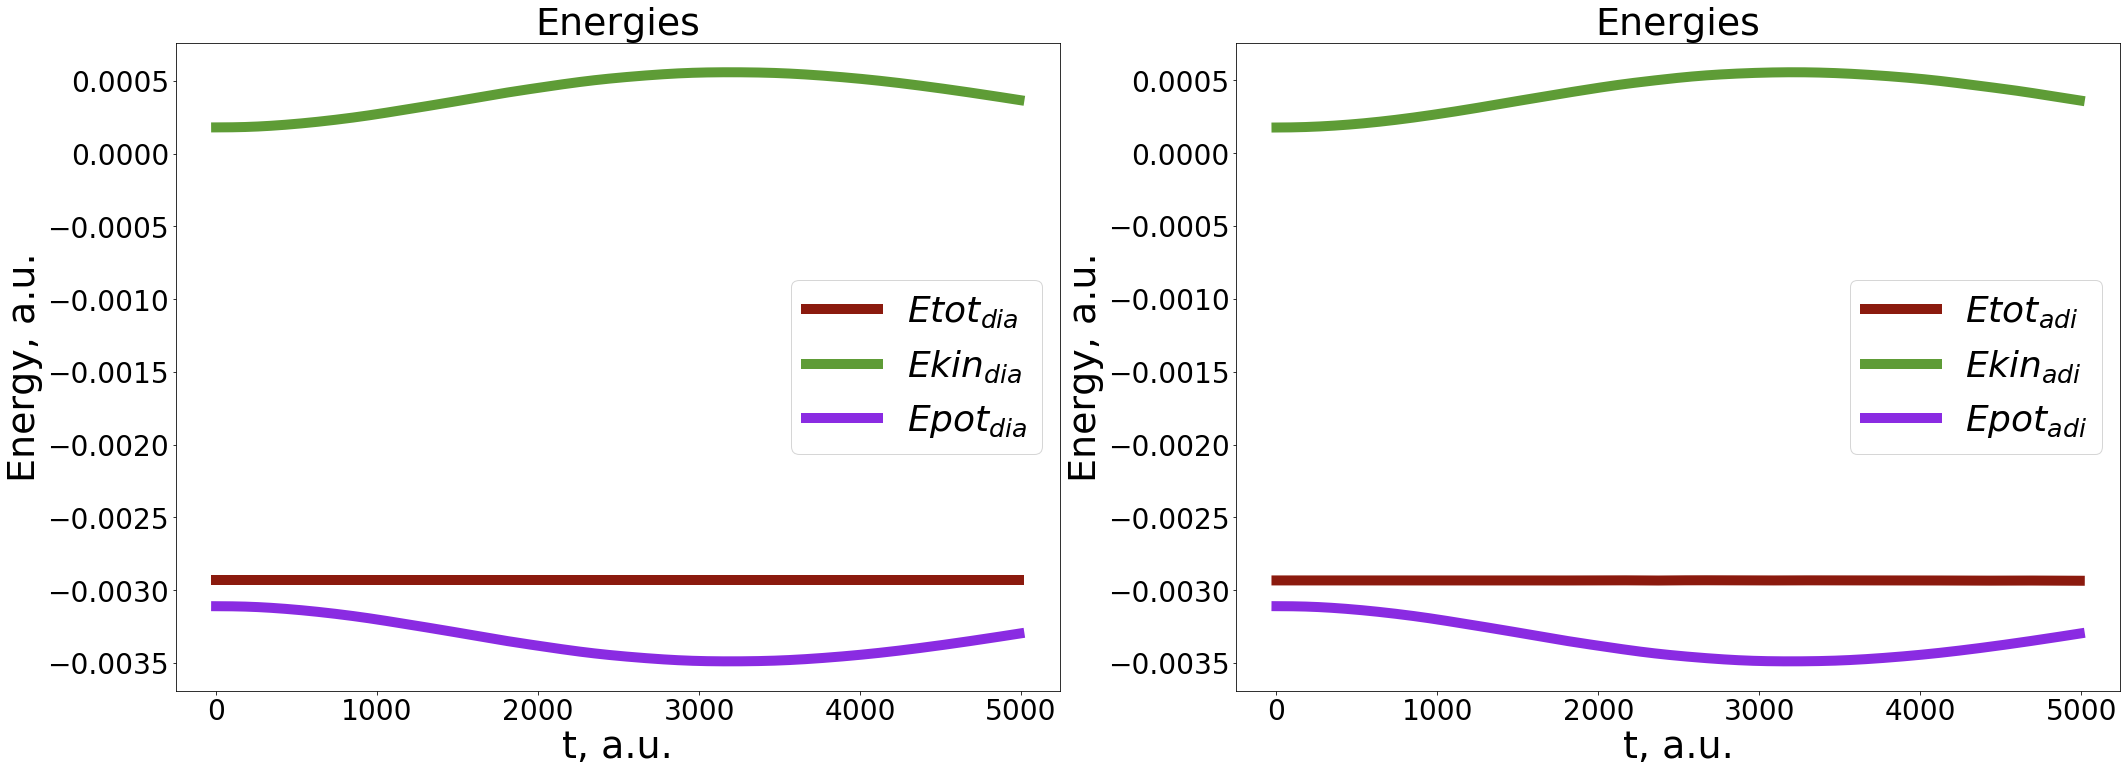

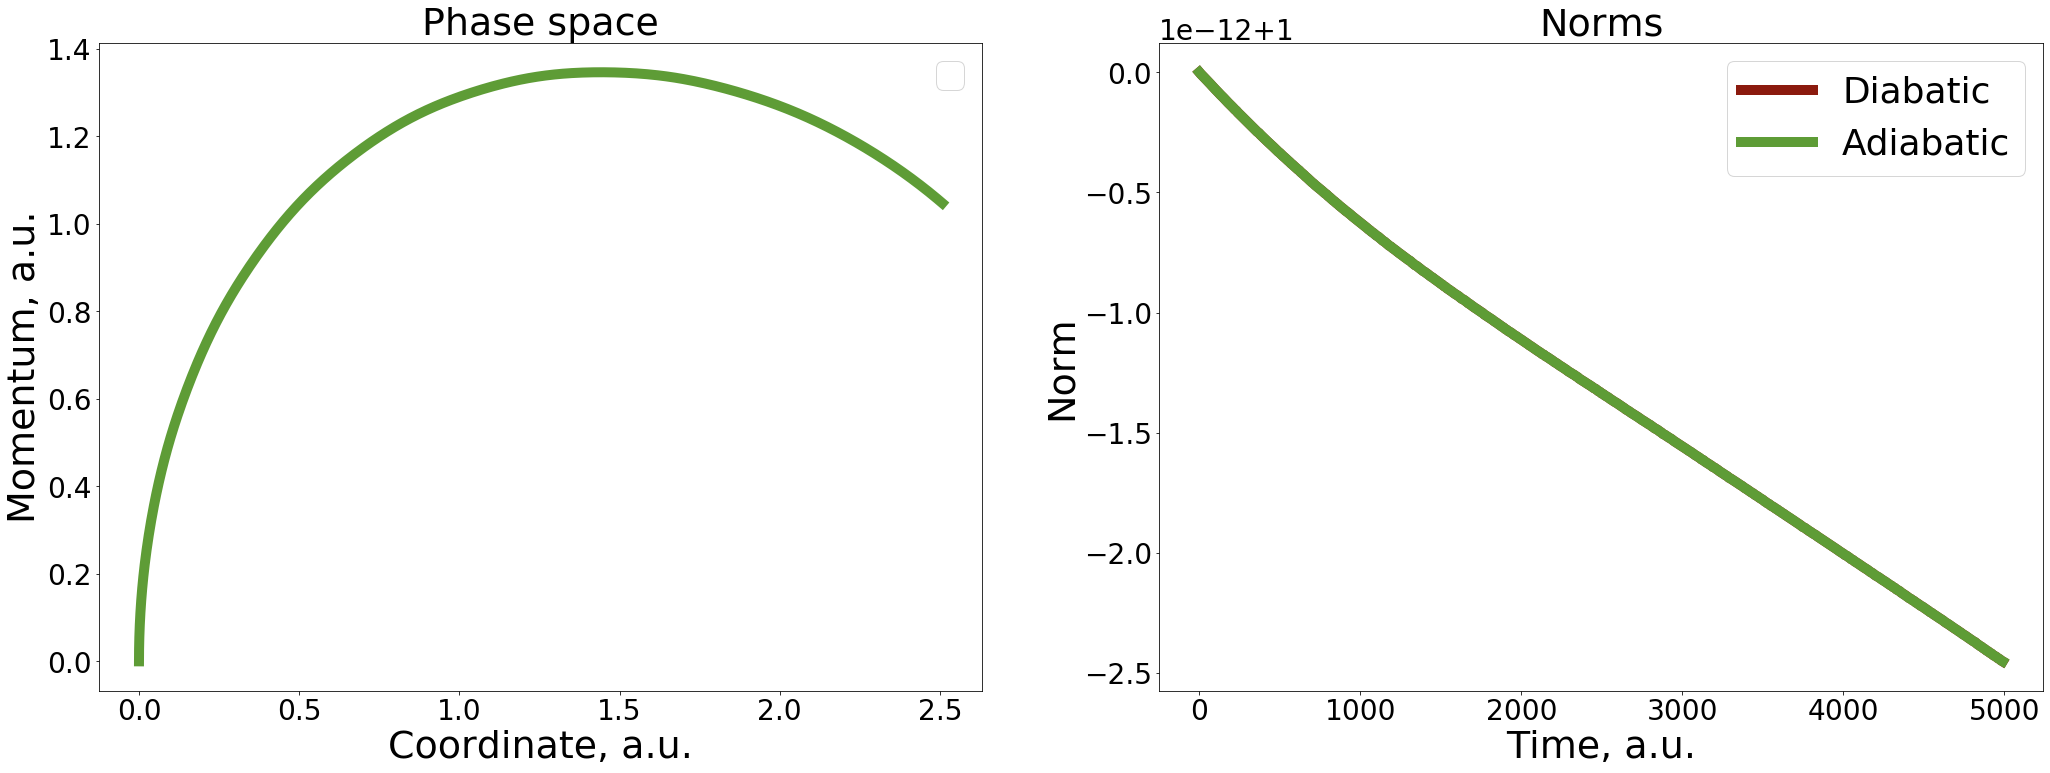

In [16]:
plot_mem(res, params1, model_params)

<a name="res-direct-dia"></a> [Back to TOC](#TOC)
### 4.2. Direct, Verlet-like, diabatic representation

In [17]:
params1 = dict(params)
params1.update({ "prefix":"case2-1",  "integrator":"direct_dia", "nsteps":5000, "dt":1.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 5000, 'dt': 1.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'direct_dia', 'prefix': 'case2-1', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00018012185796967037
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  -0.00310967

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


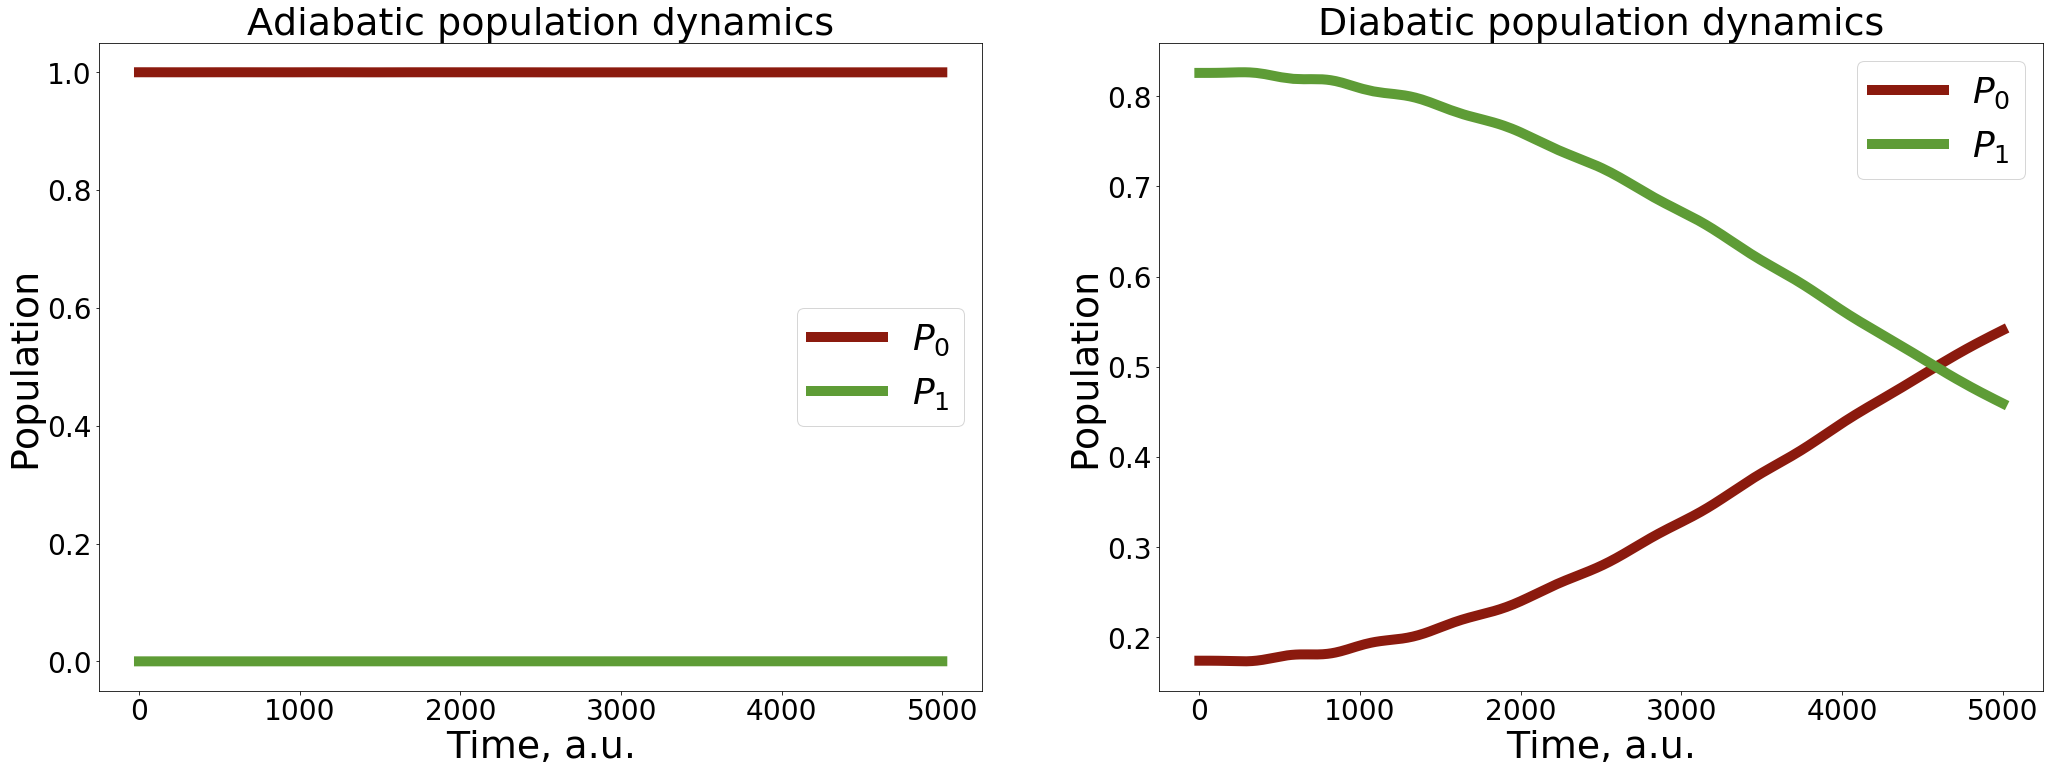

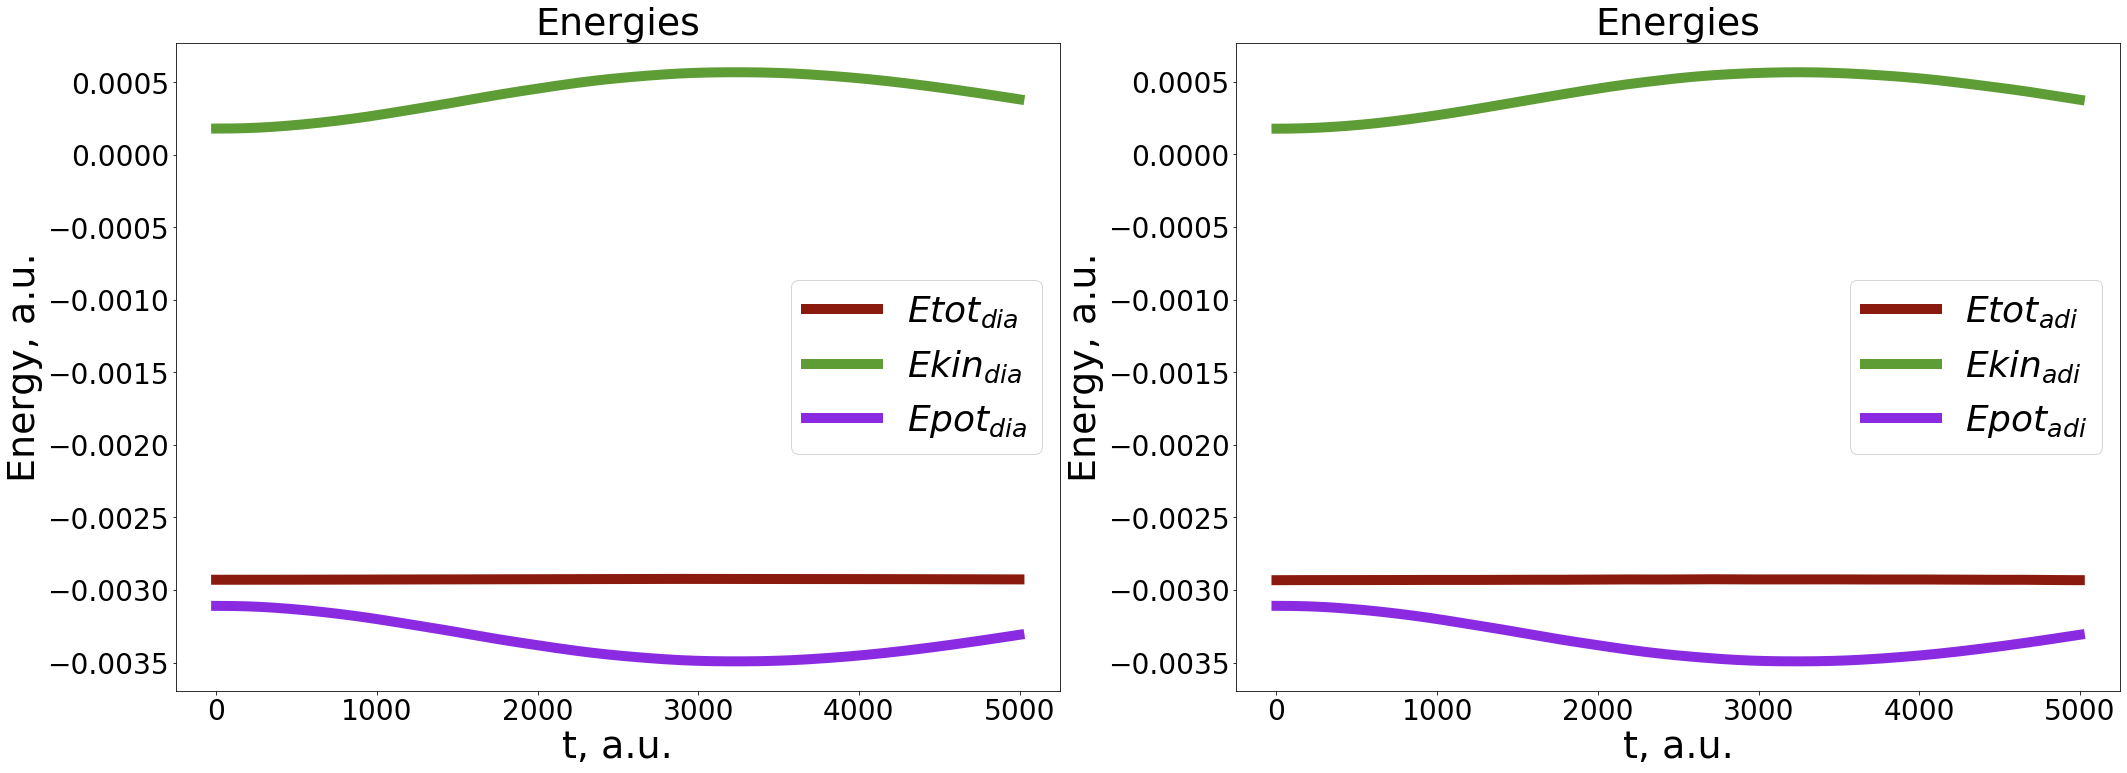

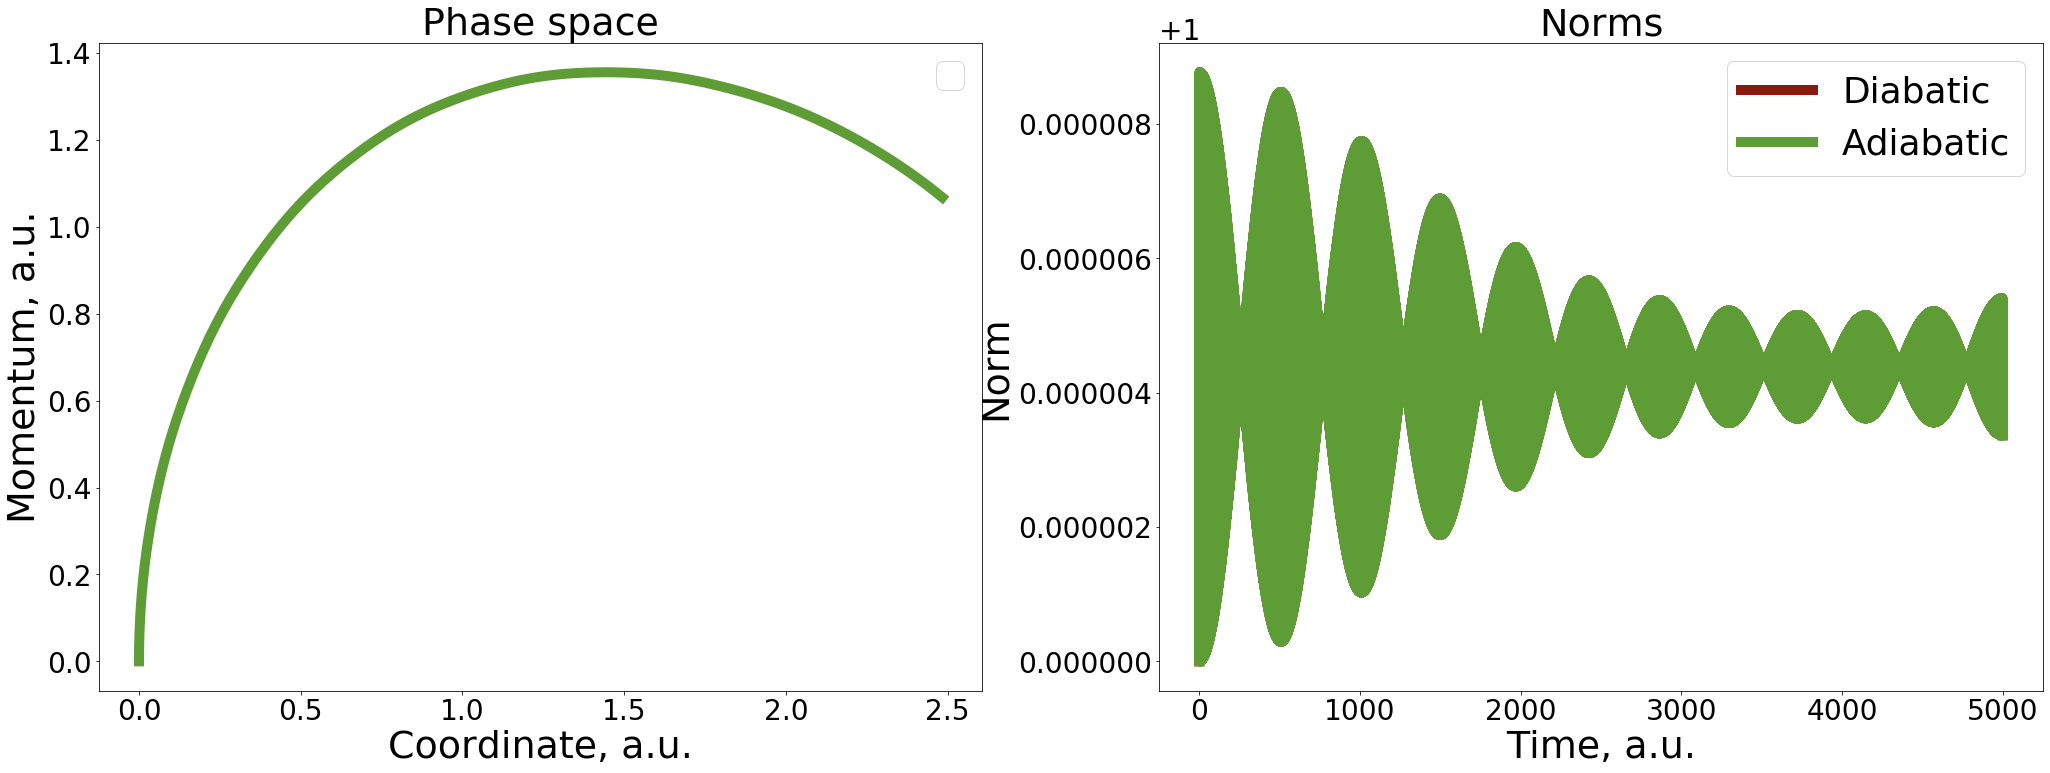

In [18]:
plot_mem(res, params1, model_params)

<a name="res-direct-adi"></a> [Back to TOC](#TOC)
### 4.3. Direct, Verlet-like, adiabatic representation

In [19]:
params1 = dict(params)
params1.update({ "prefix":"case3-1",  "integrator":"direct_adi", "nsteps":5000, "dt":1.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 5000, 'dt': 1.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'direct_adi', 'prefix': 'case3-1', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00018012185796967037
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  -0.00310967

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


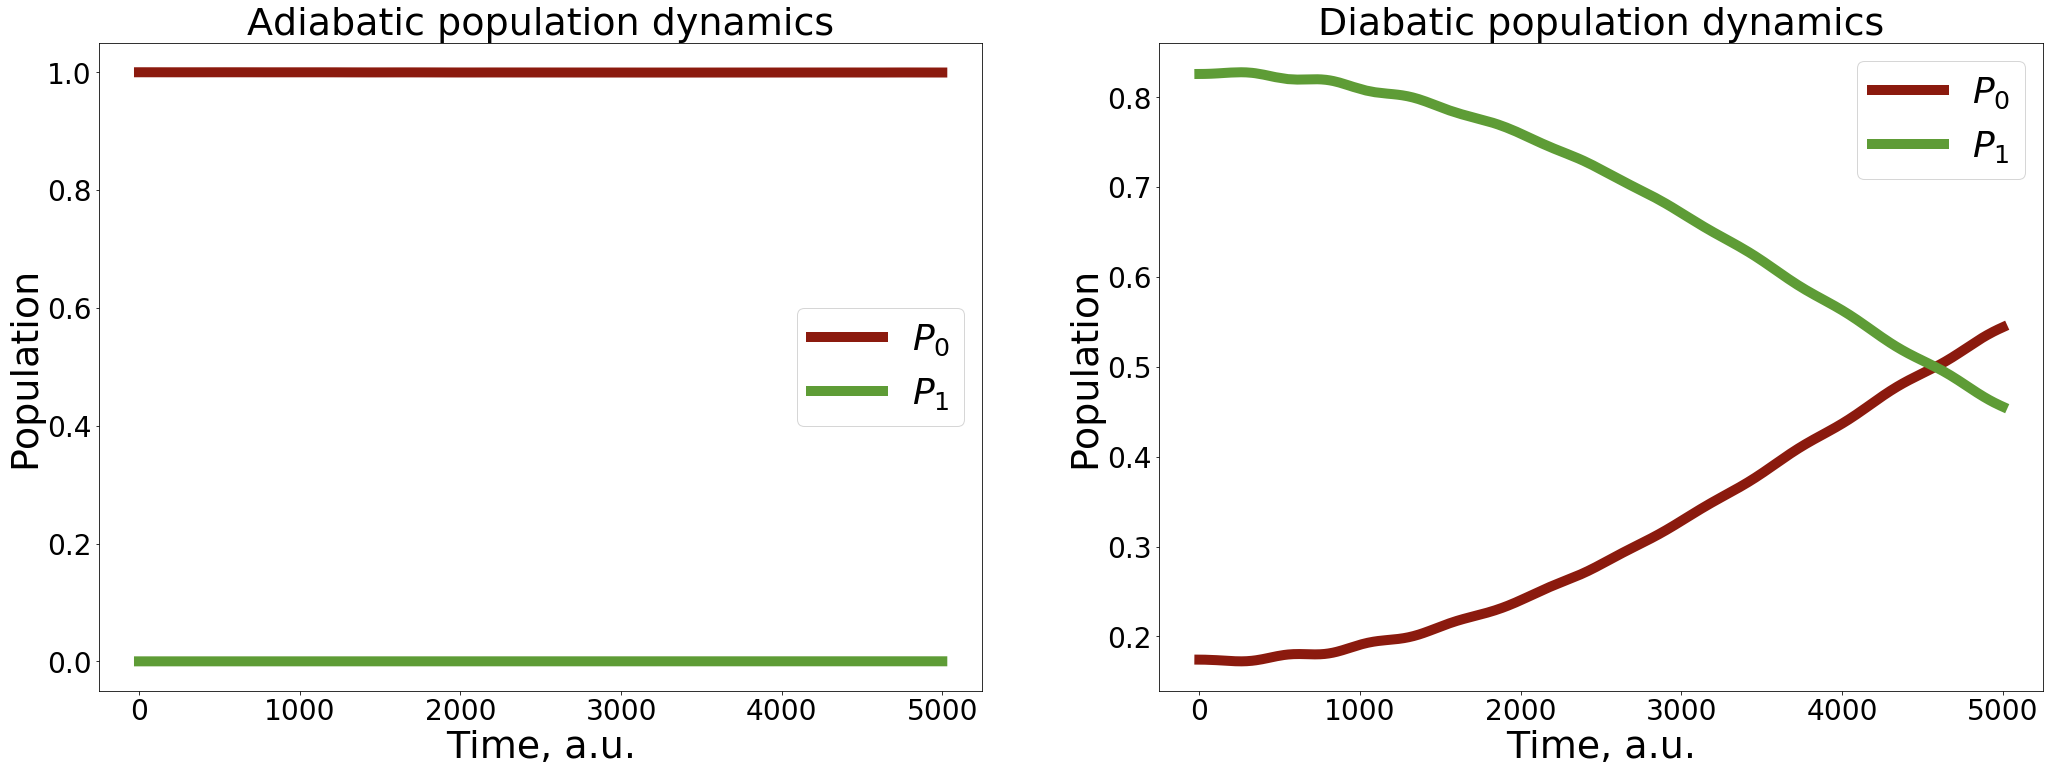

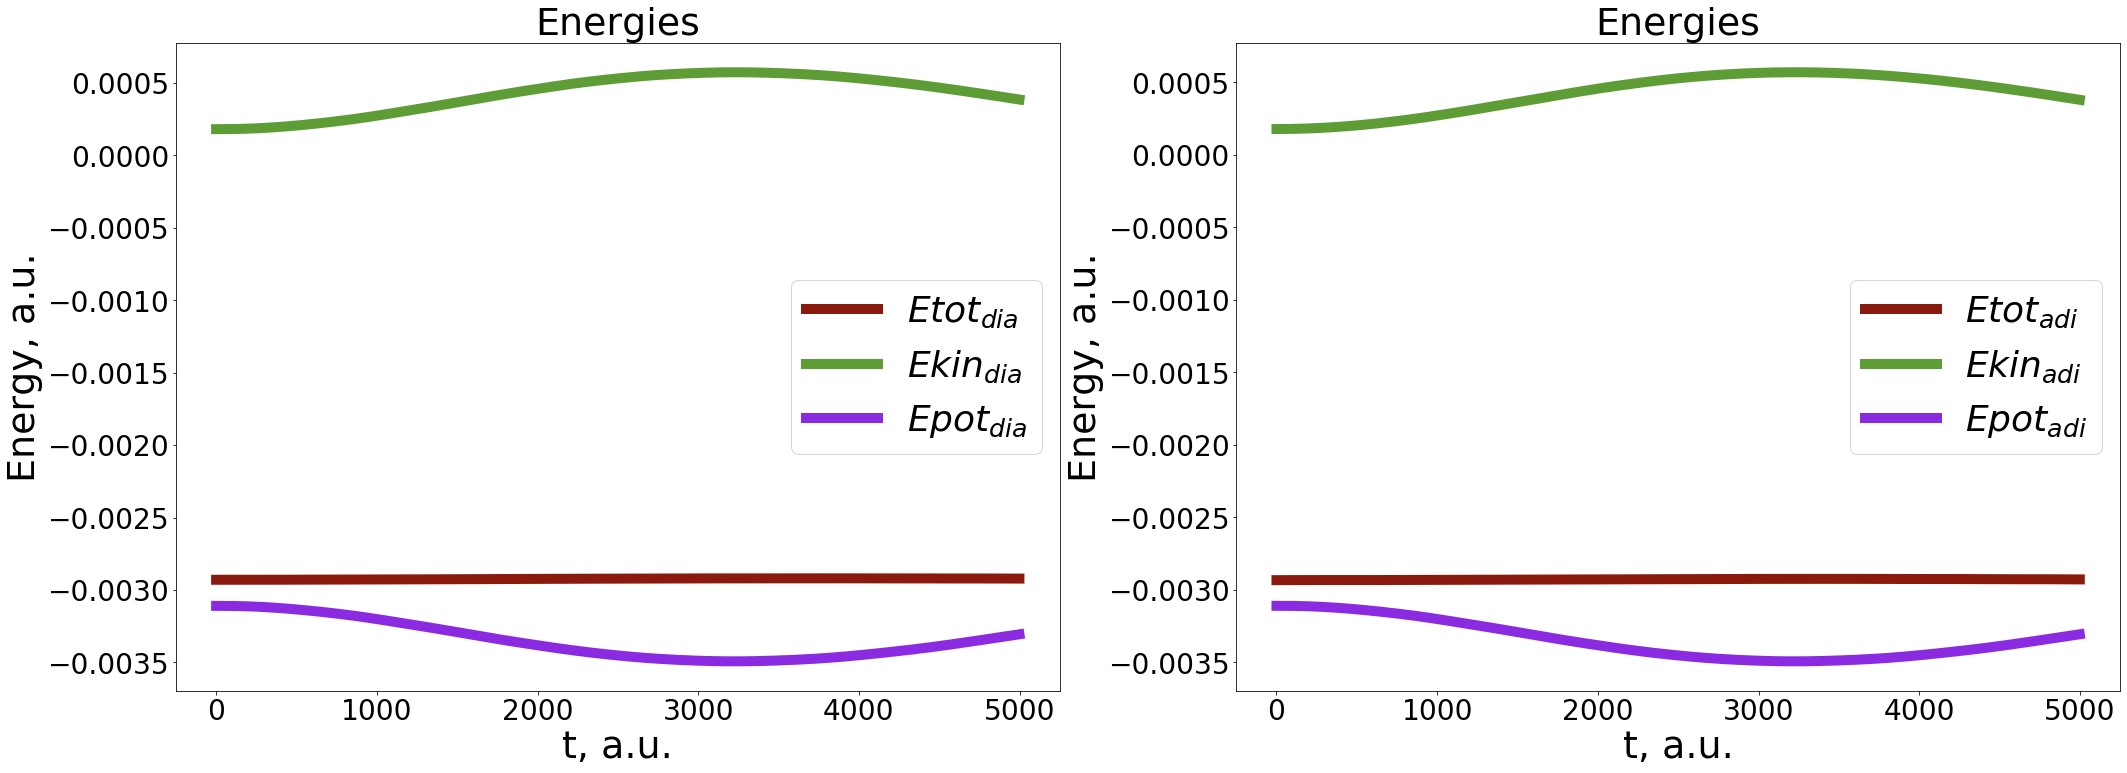

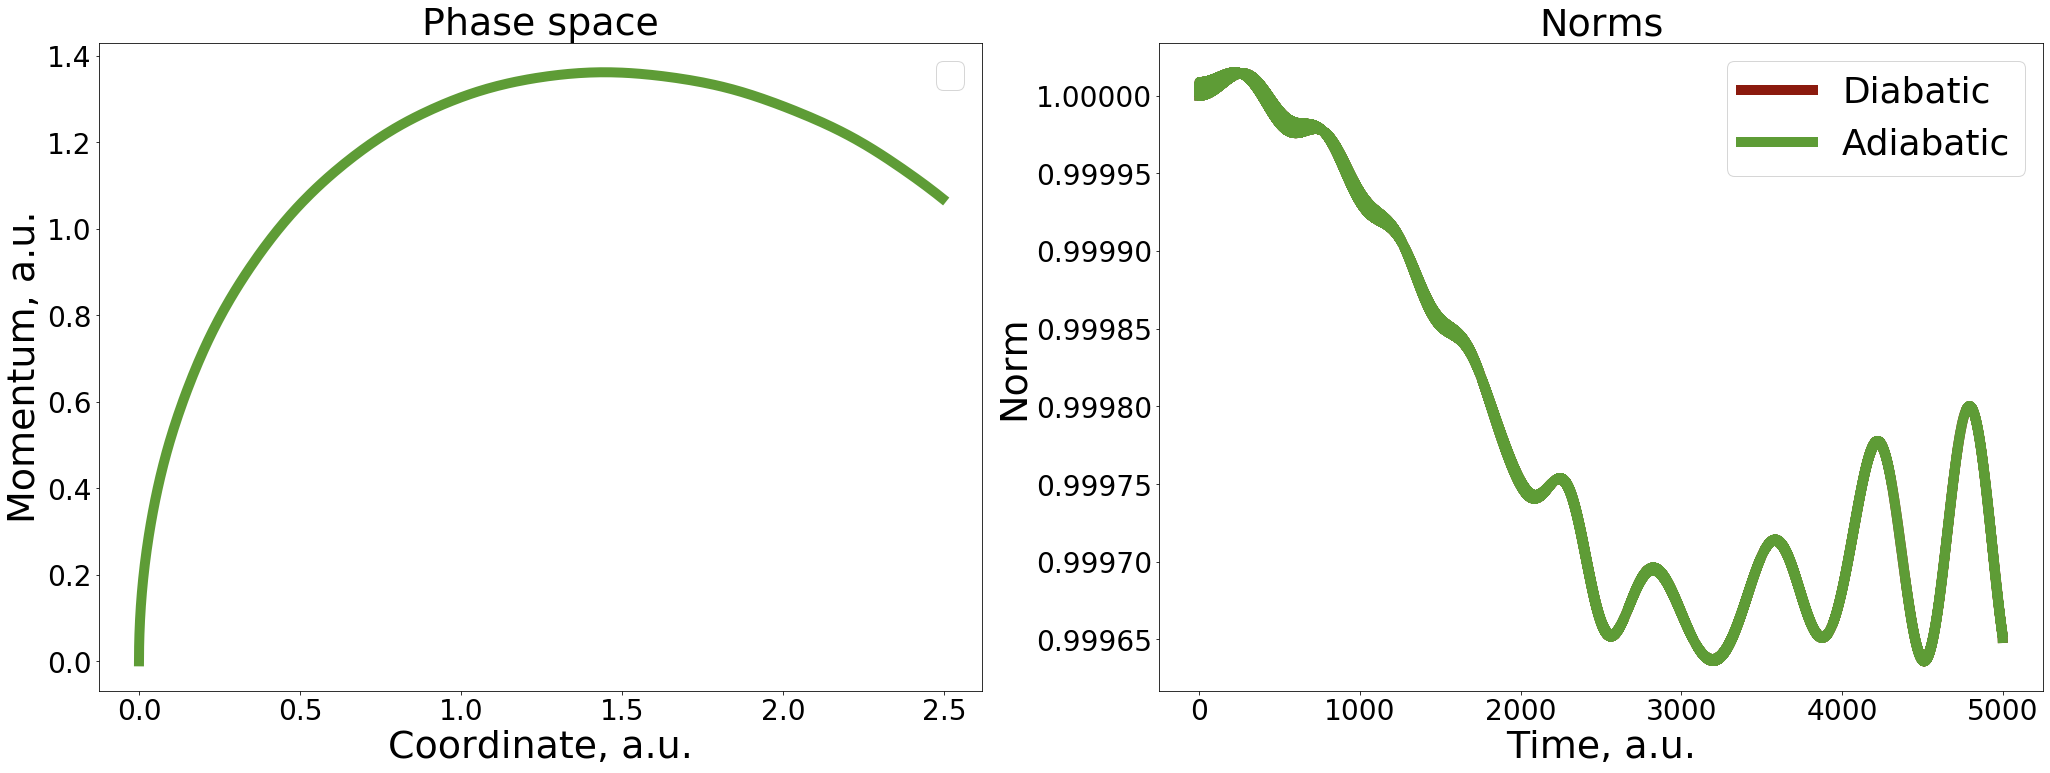

In [20]:
plot_mem(res, params1, model_params)

<a name="res-direct-colbert-miller-dia"></a> [Back to TOC](#TOC)
### 4.4. Direct, Verlet-like with Colbert-Miller DVR,  in diabatic representation

In [21]:
params1 = dict(params)
params1.update({ "prefix":"case4-1",  "integrator":"Colbert_Miller_dia", "nsteps":5000, "dt":1.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 5000, 'dt': 1.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'Colbert_Miller_dia', 'prefix': 'case4-1', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00018012185796967037
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  -0.

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


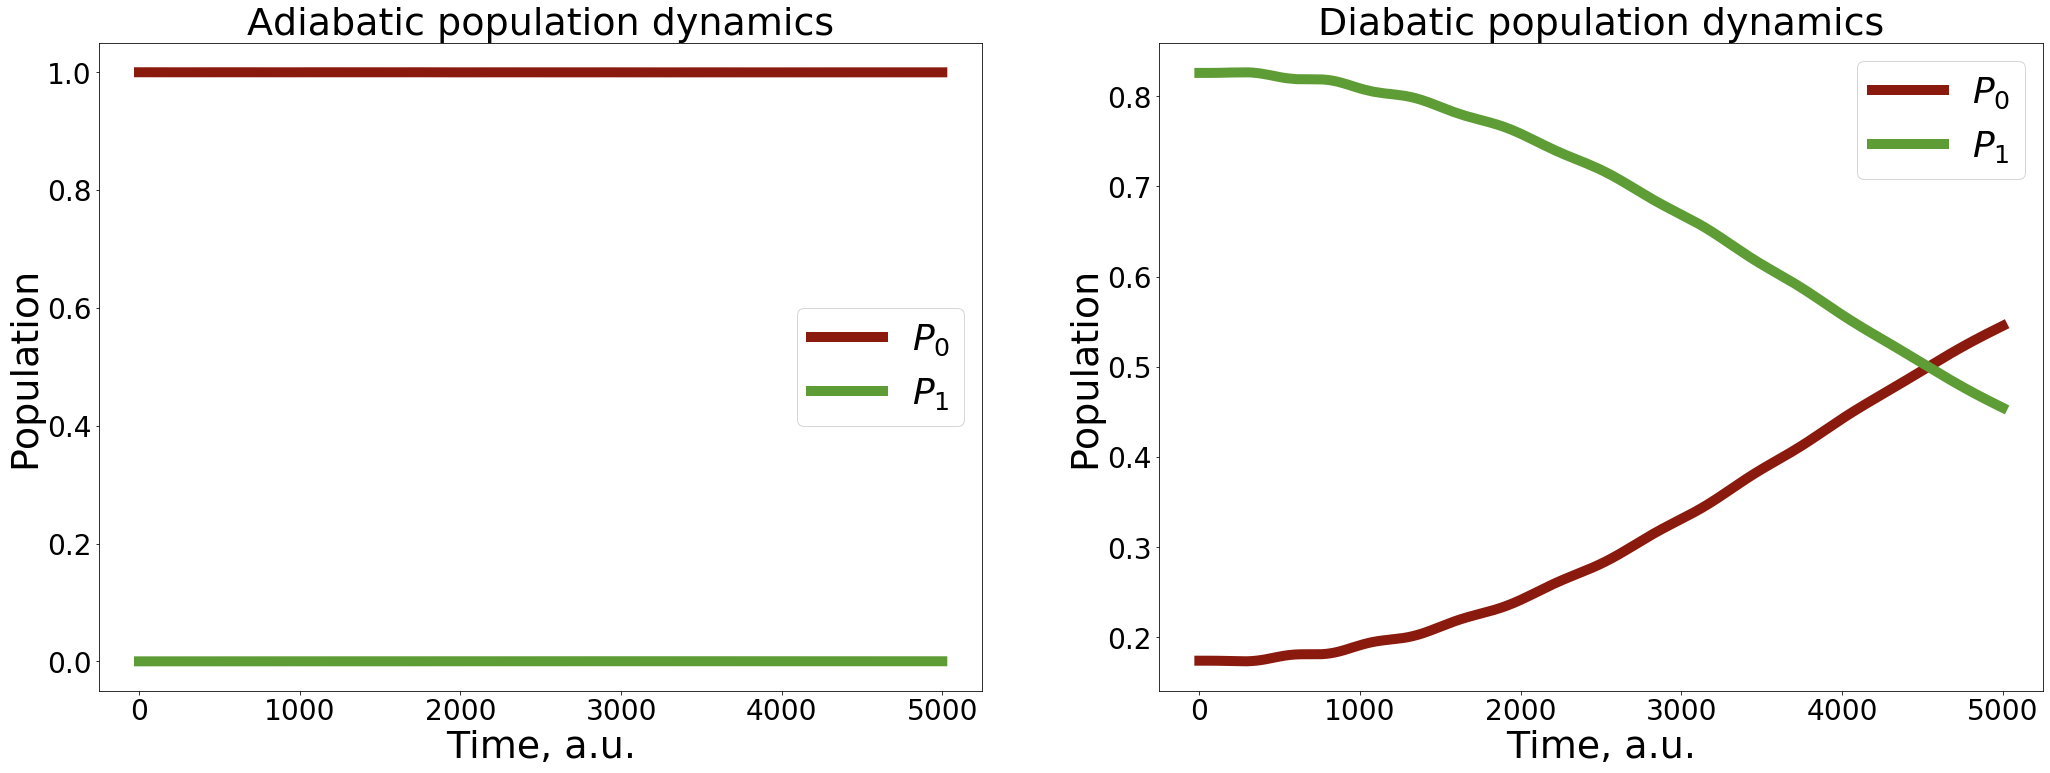

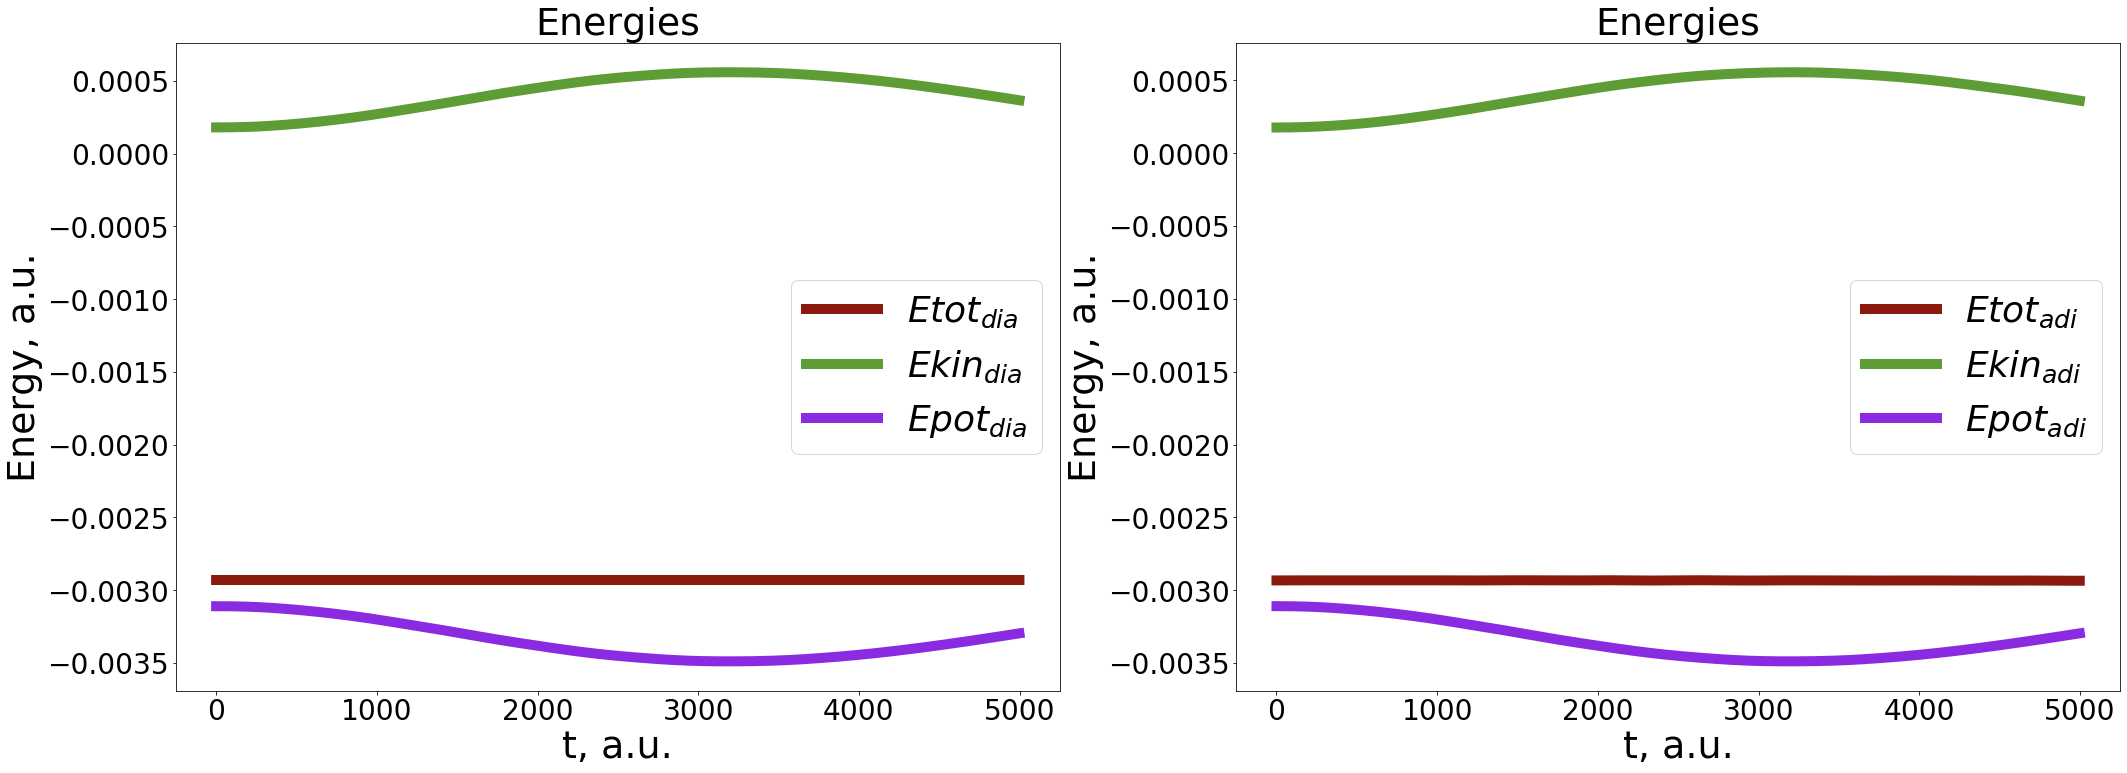

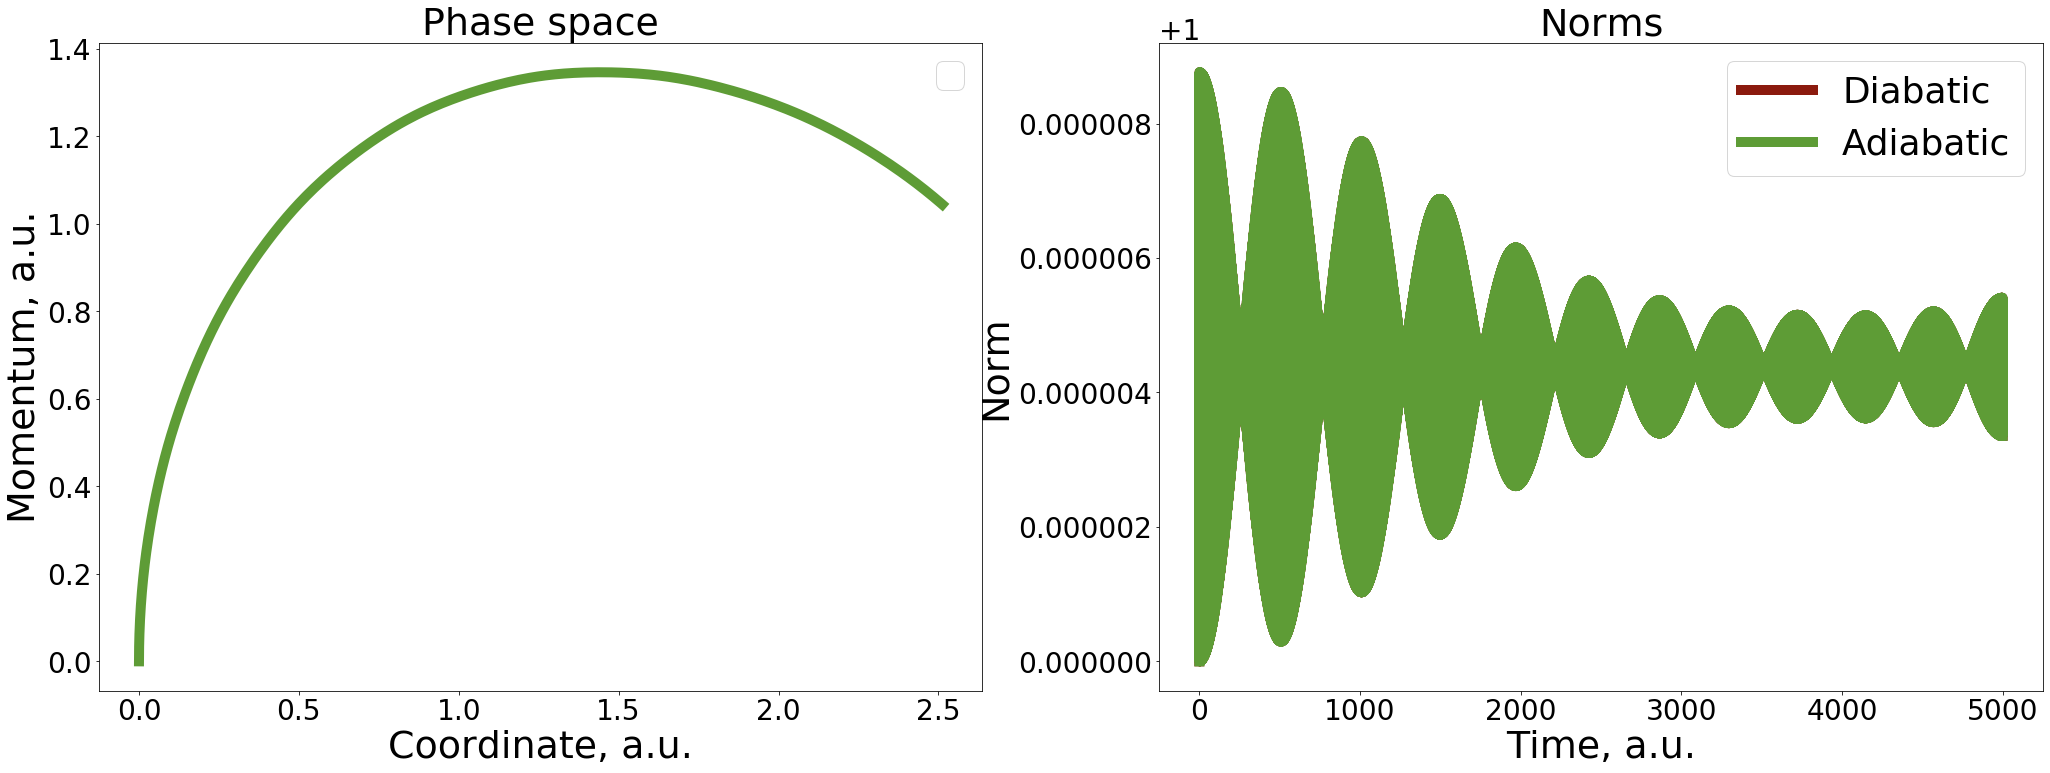

In [22]:
plot_mem(res, params1, model_params)

<a name="res-direct-colbert-miller-adi"></a> [Back to TOC](#TOC)
### 4.5. Direct, Verlet-like with Colbert-Miller DVR,  in adiabatic representation

In [23]:
params1 = dict(params)
params1.update({ "prefix":"case5-1",  "integrator":"Colbert_Miller_adi", "nsteps":5000, "dt":1.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 5000, 'dt': 1.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'Colbert_Miller_adi', 'prefix': 'case5-1', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00018012185796967037
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  -0.

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


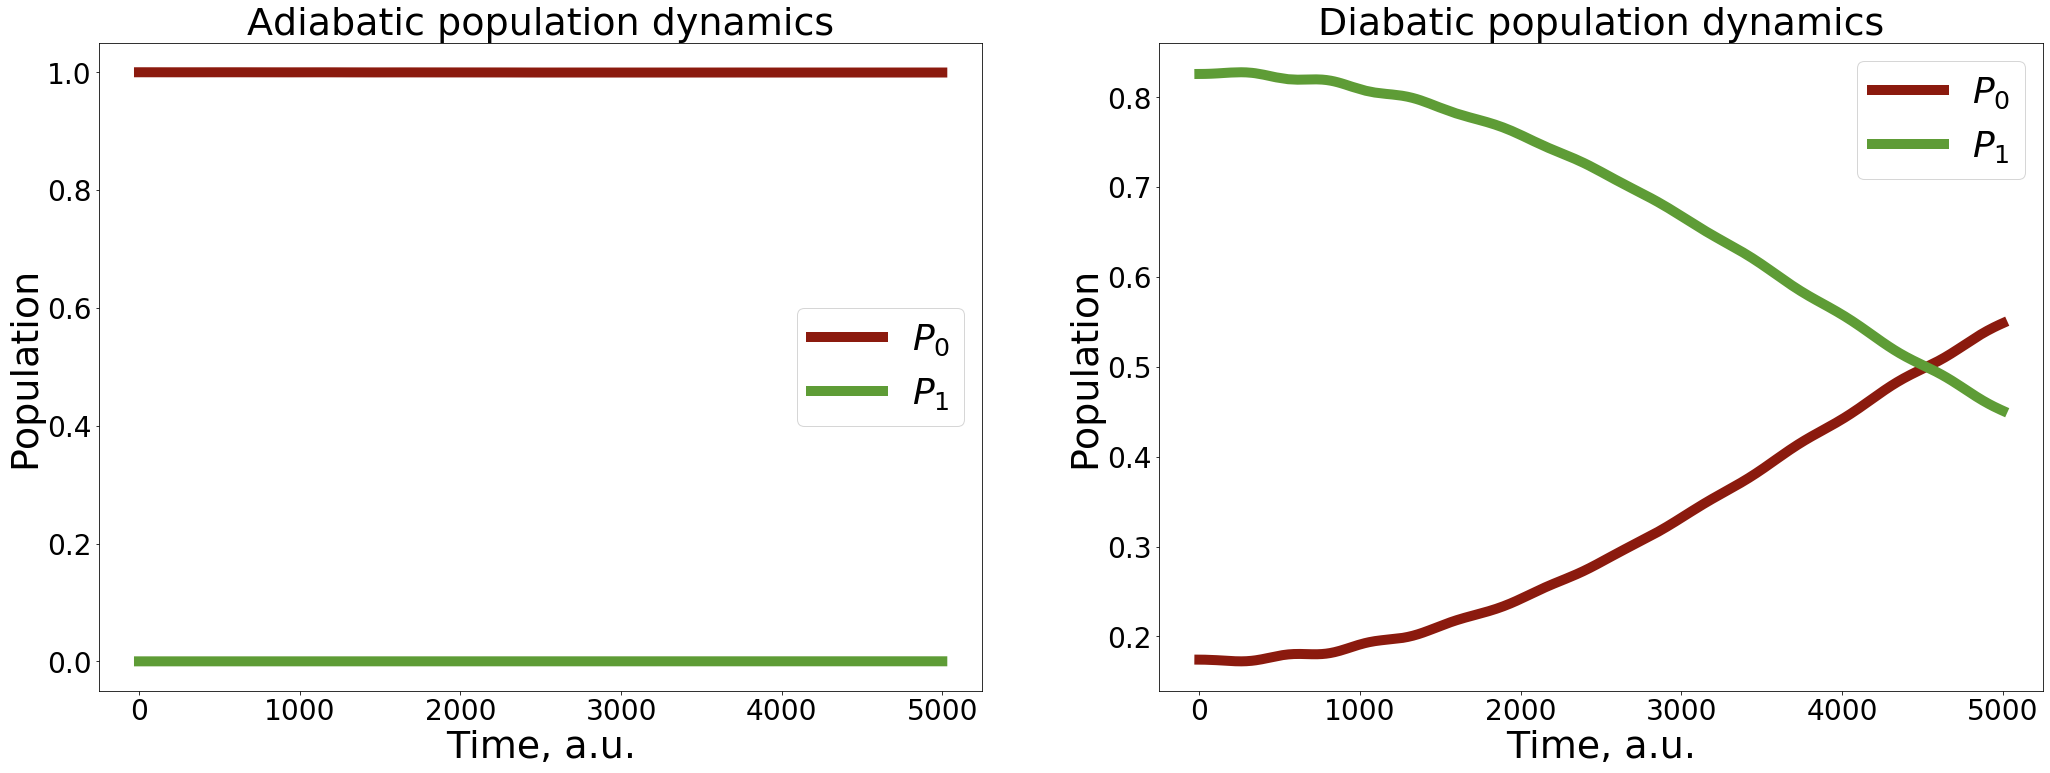

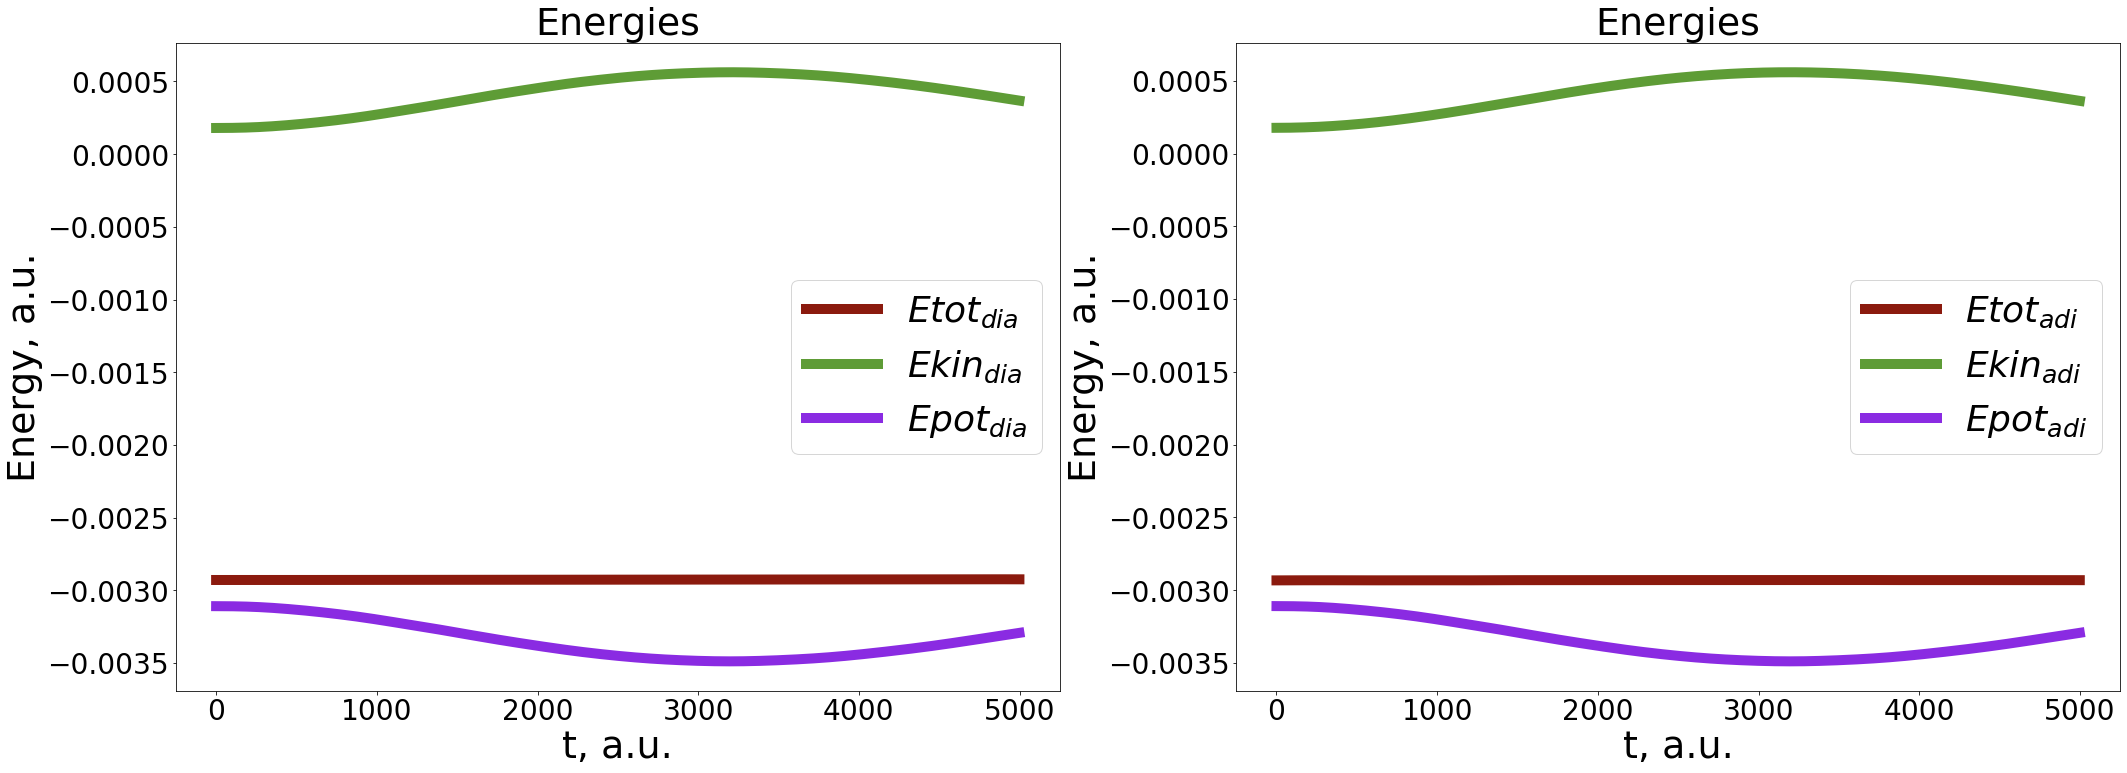

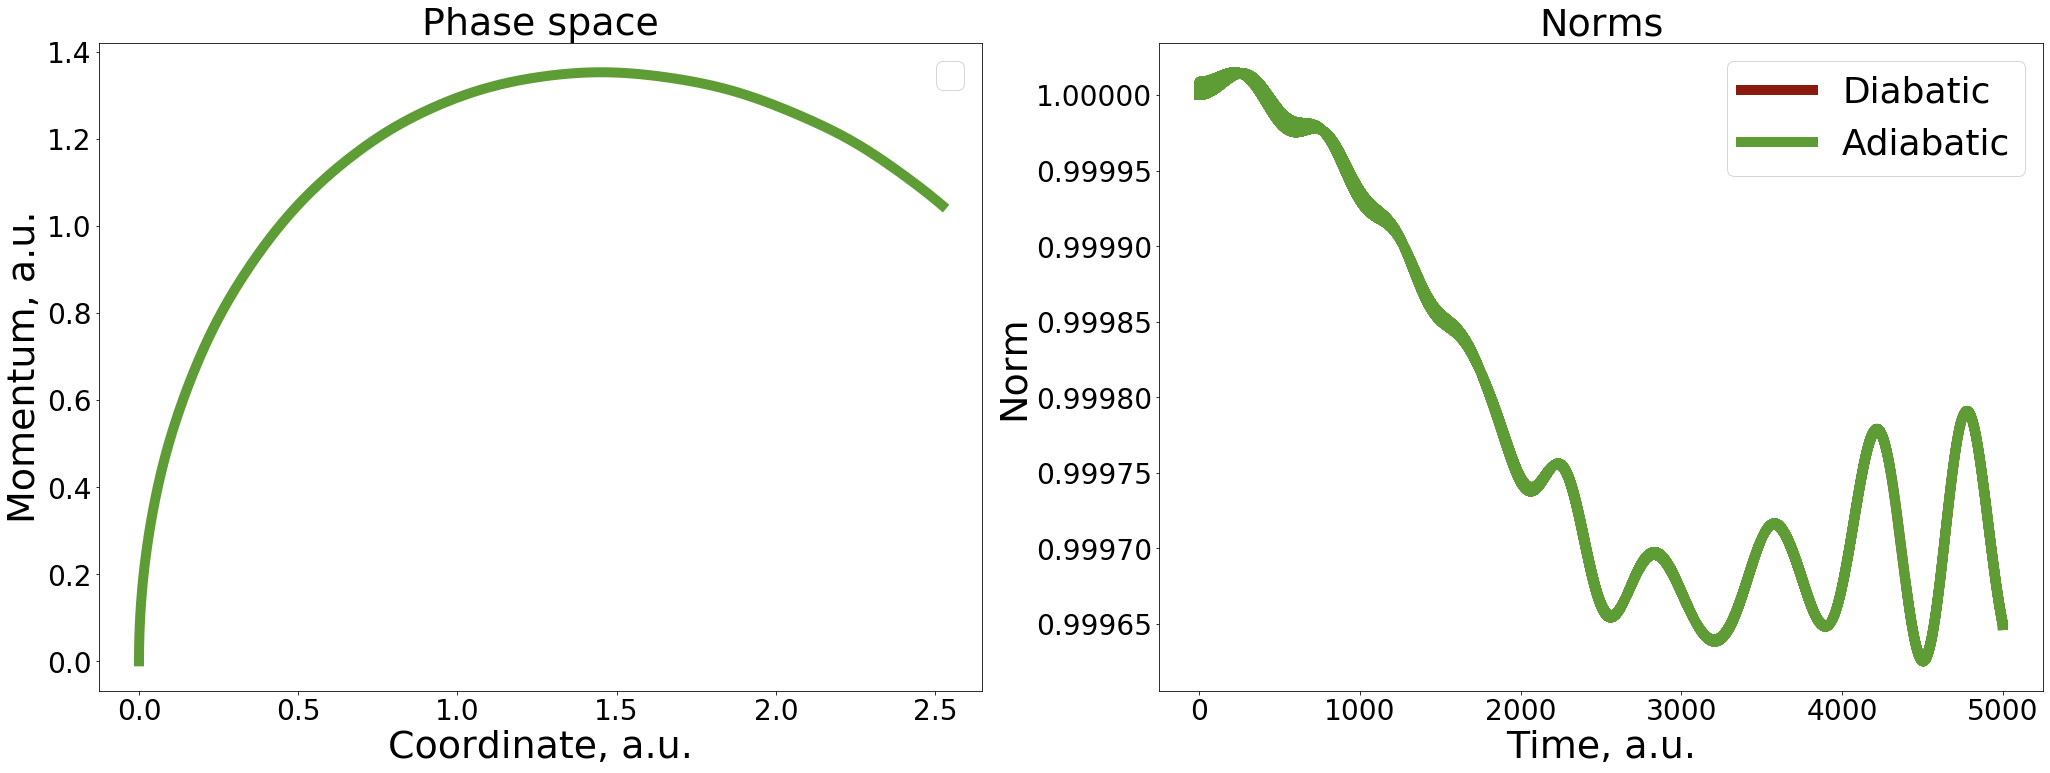

In [24]:
plot_mem(res, params1, model_params)

<a name="res-soft-colbert-miller"></a> [Back to TOC](#TOC)
### 4.6. SOFT integrator with the kinetic energy operator represented by the Colbert-Miller DVR in real space, in diabatic representation

In [25]:
params1 = dict(params)
params1.update({ "prefix":"case6-1",  "integrator":"Colbert_Miller_SOFT", "nsteps":500, "dt":10.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 500, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [0.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'Colbert_Miller_SOFT', 'prefix': 'case6-1', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.005}
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.00018012185796967037
Ekin (adi) =  0.00017677669529663636
Epot (dia) =  -0

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


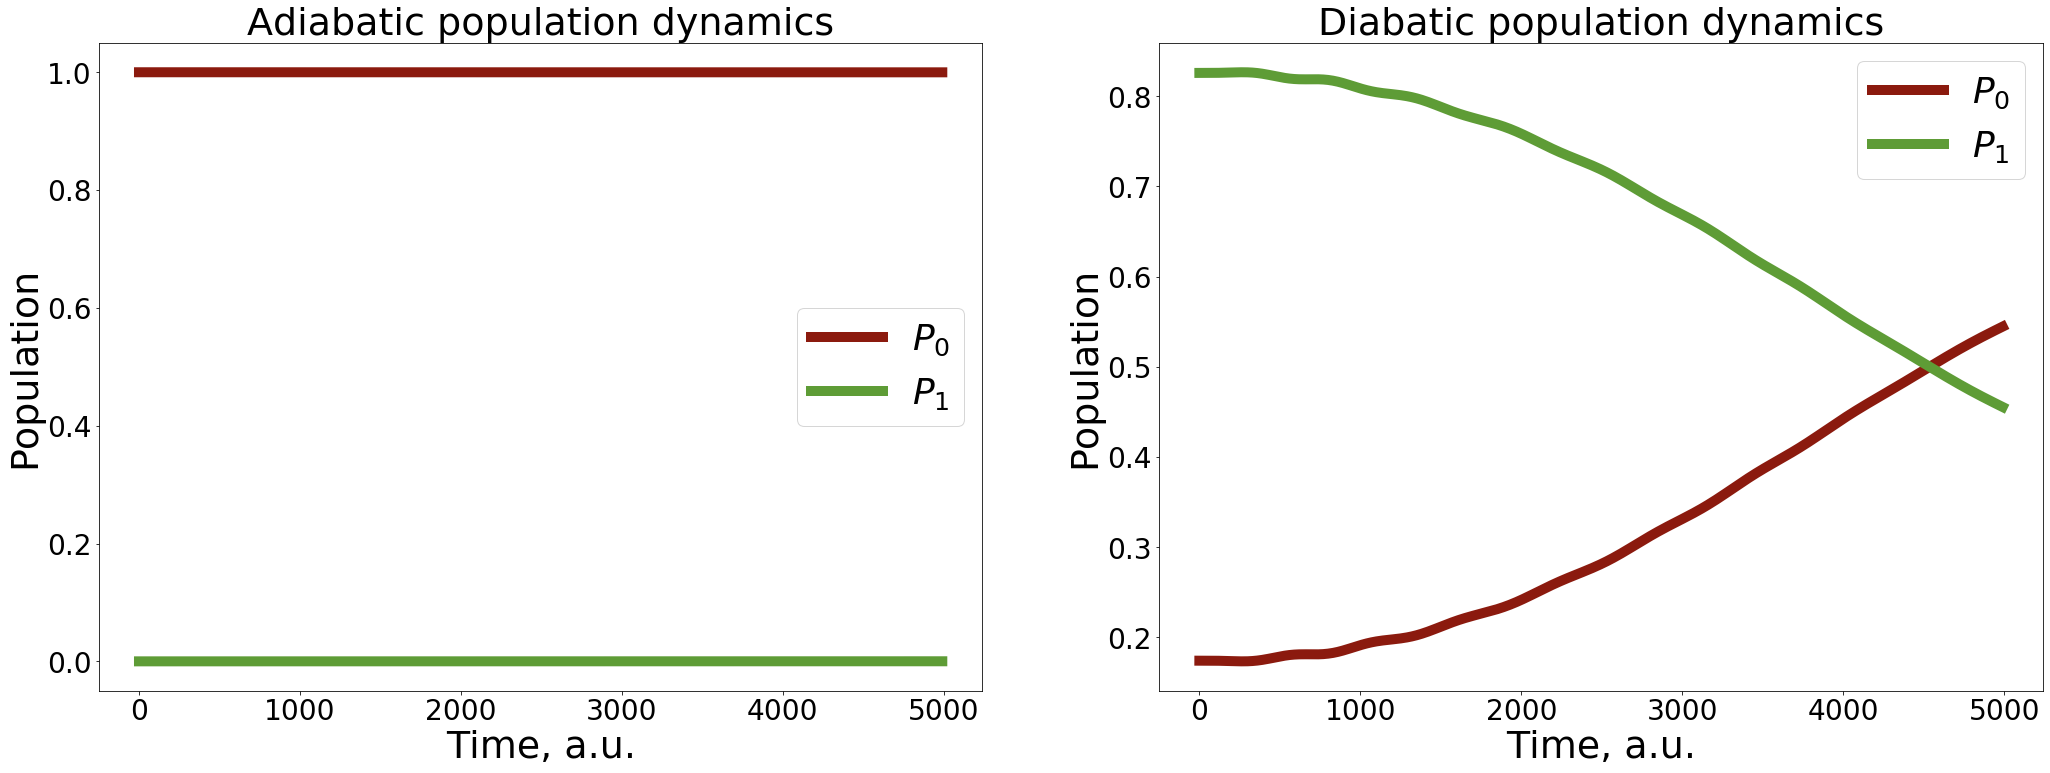

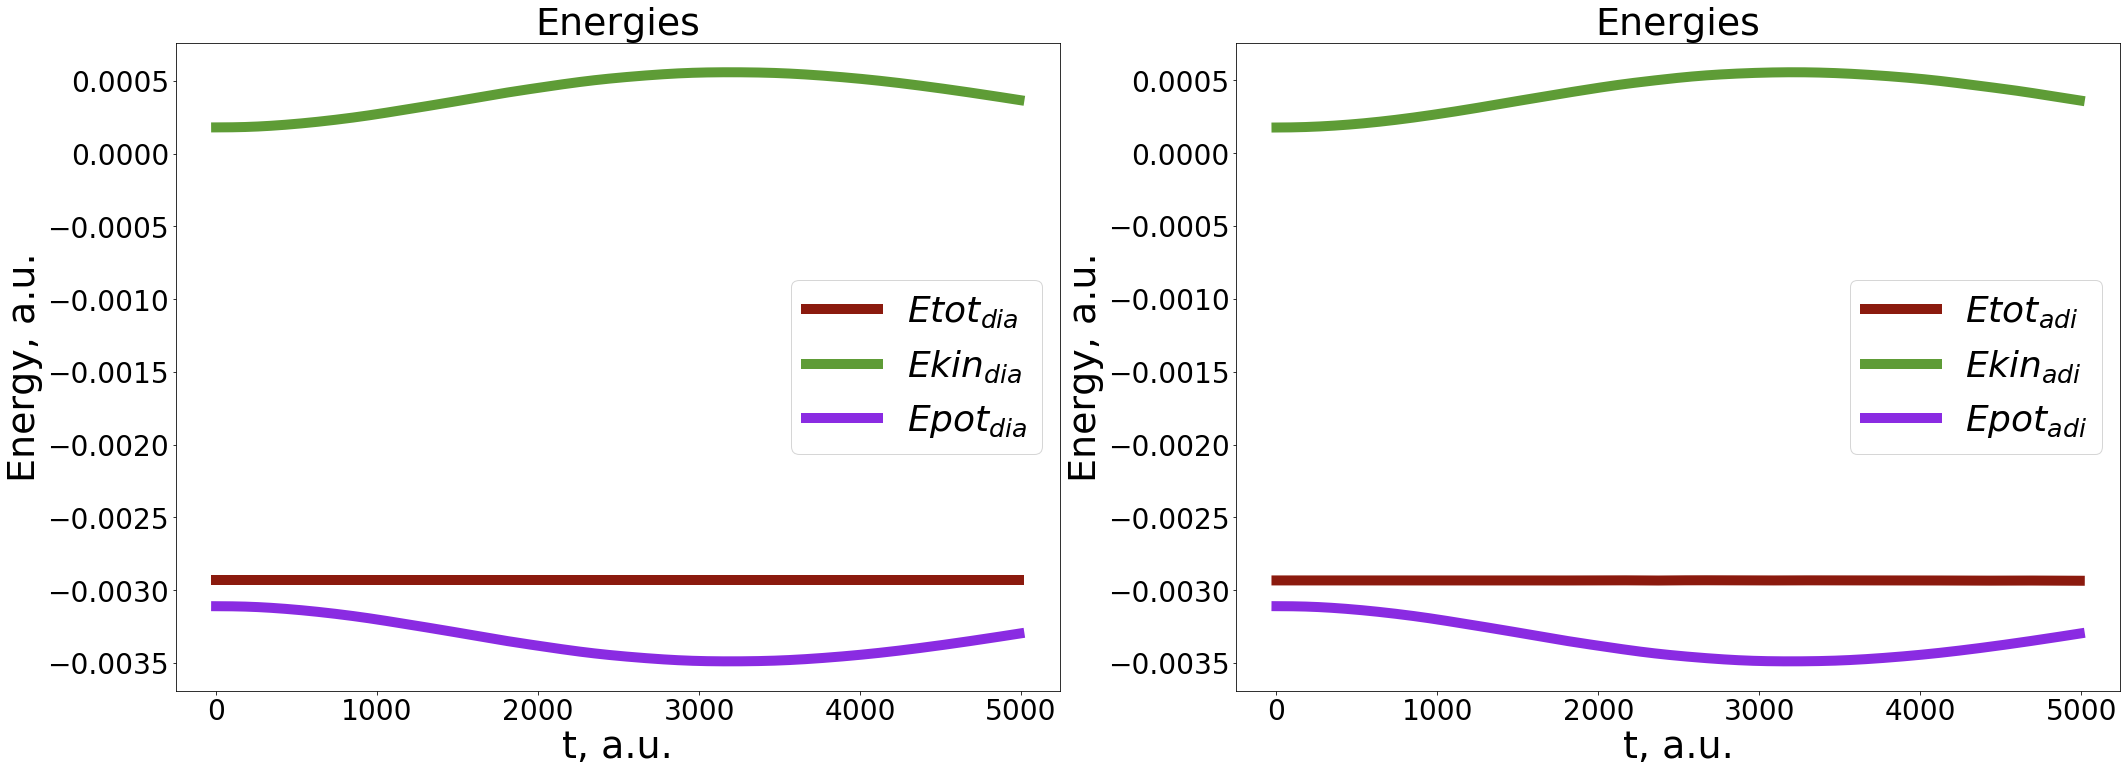

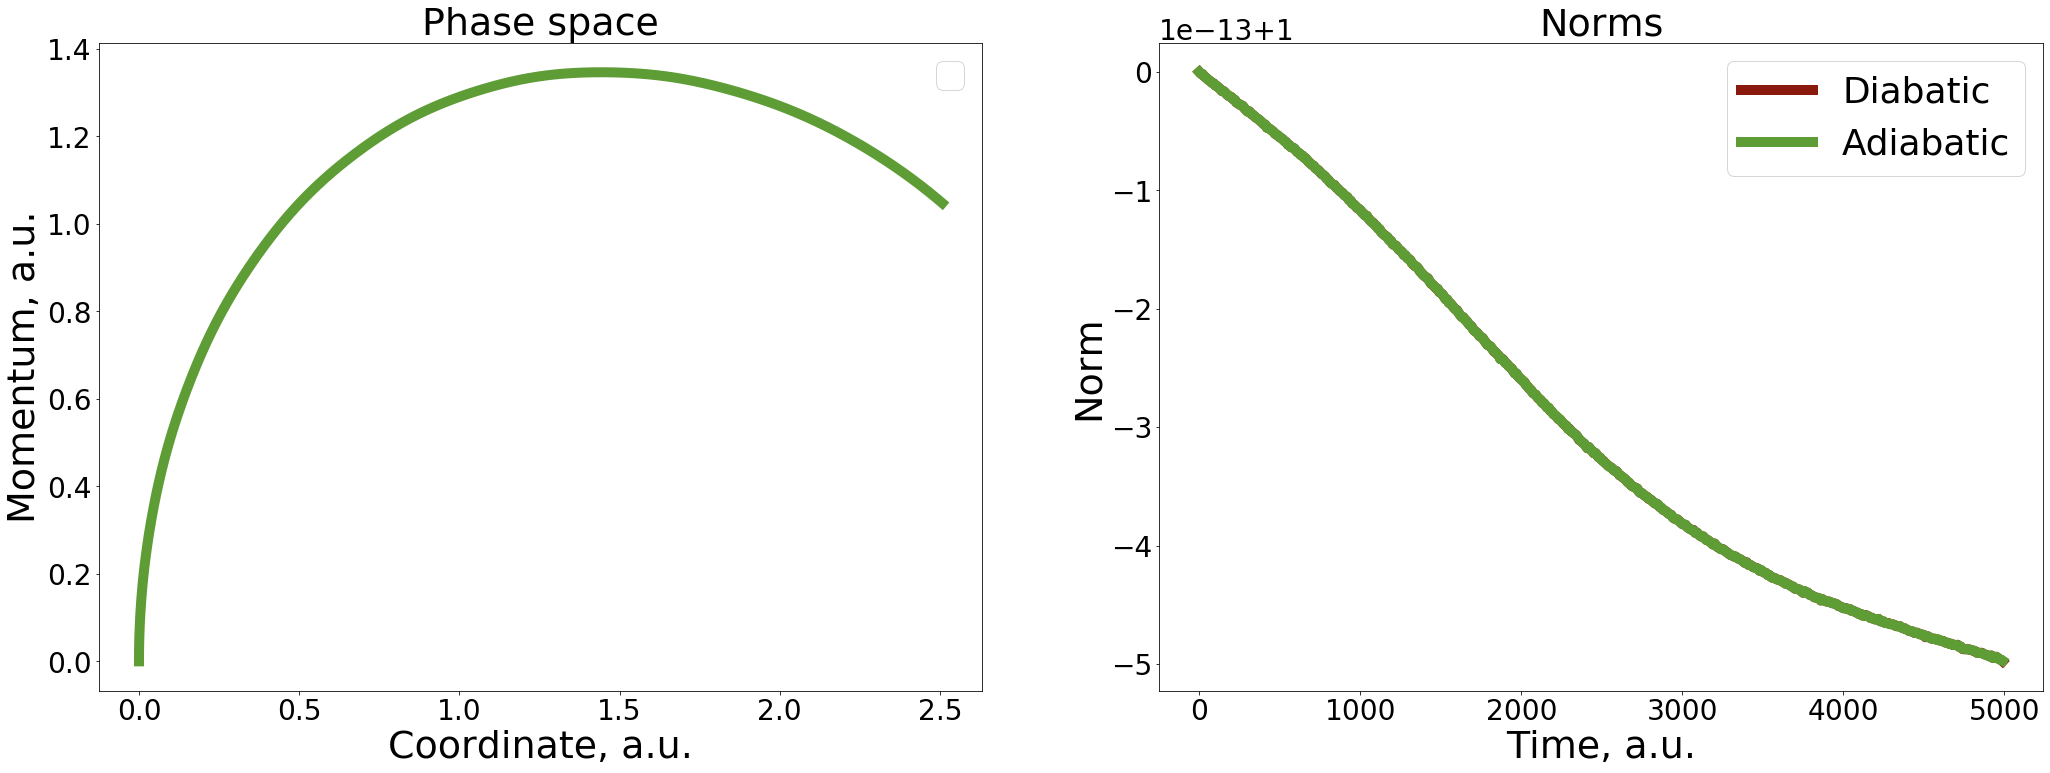

In [26]:
plot_mem(res, params1, model_params)

<a name="calcs-2"></a> [Back to TOC](#TOC)
## 5. Examples with greater non-adiabaticity

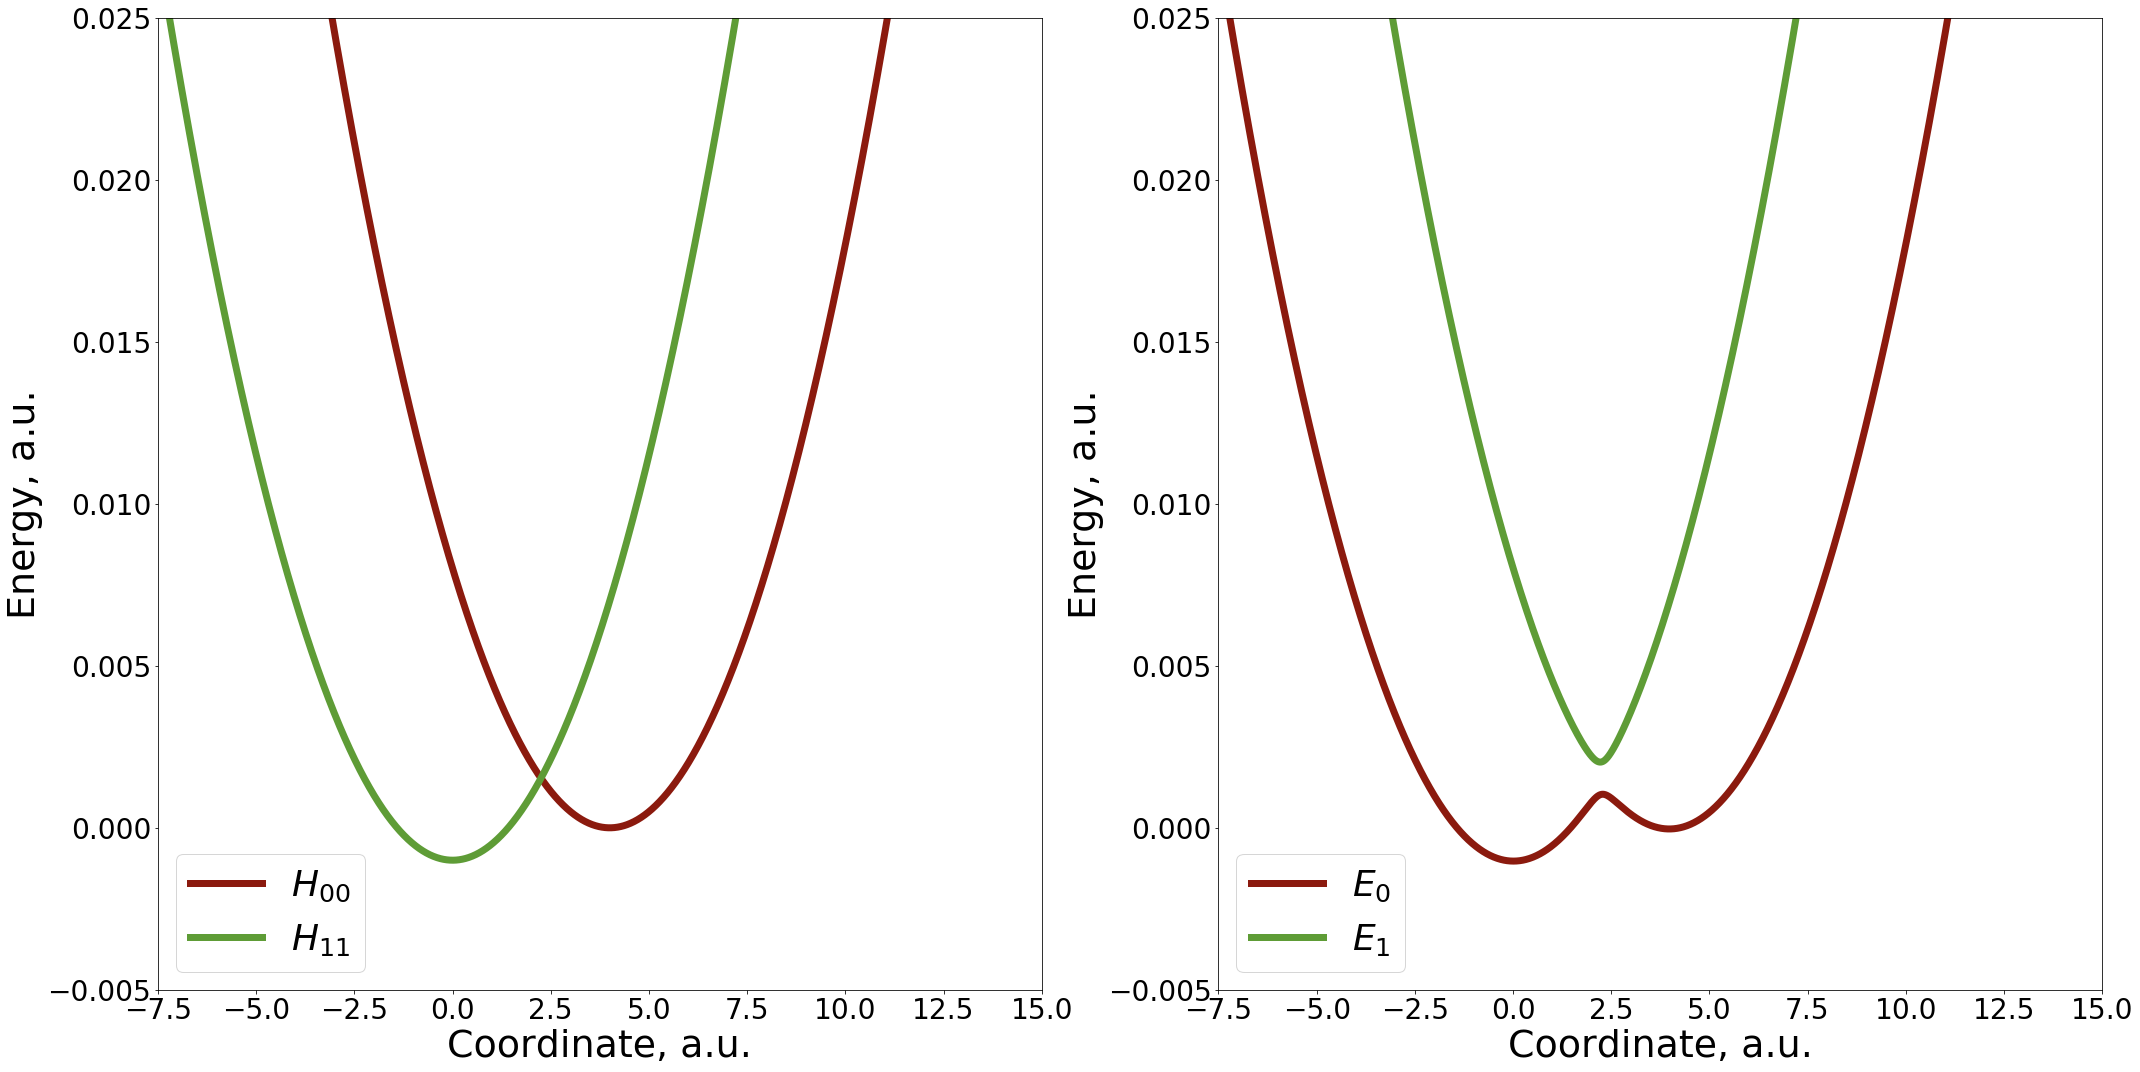

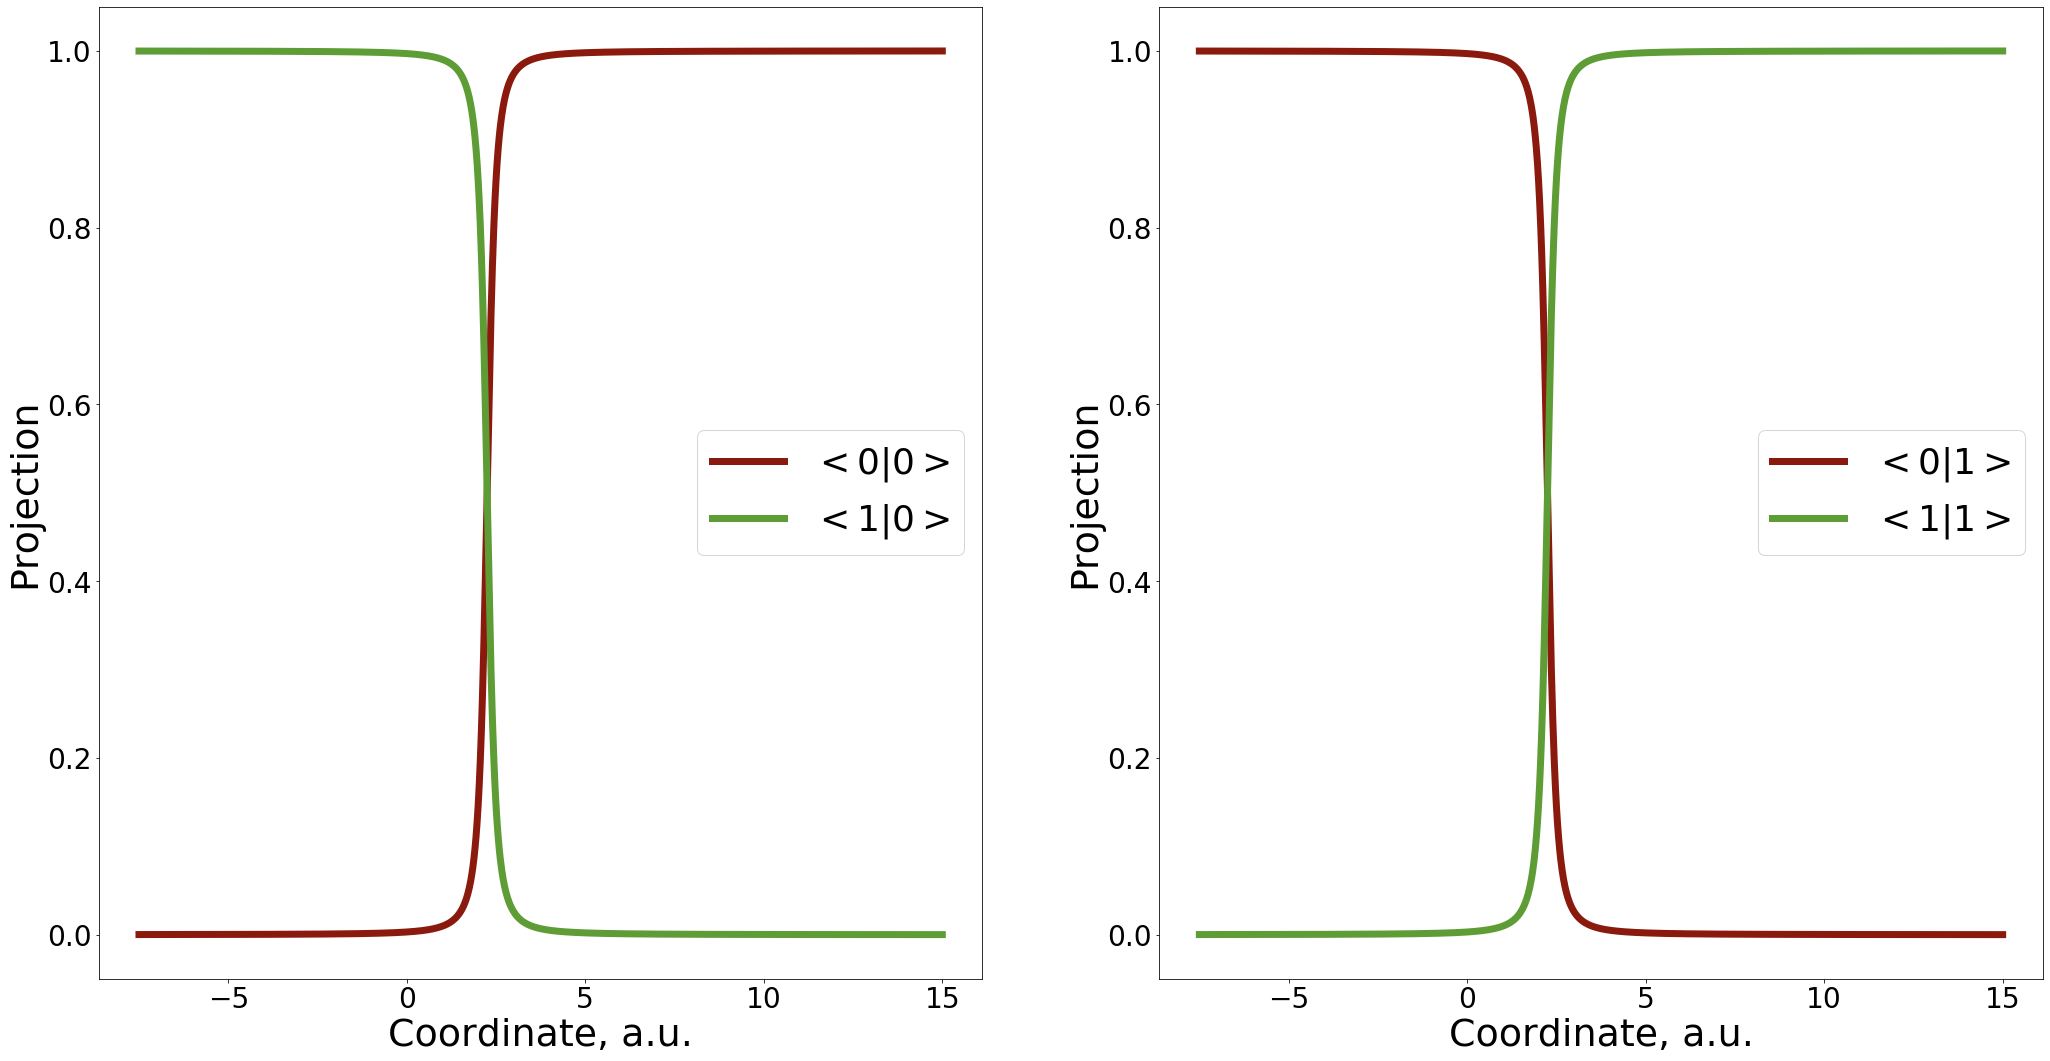

In [27]:
plot_surfaces(compute_model, [ param_sets[1] ], [0,1])

In [28]:
model_params = dict(param_sets[1])

properties_to_save = [ "timestep", "time", "Ekin_dia", "Ekin_adi", "Epot_dia", 
                       "Epot_adi", "Etot_dia", "Etot_adi", "norm_dia", "norm_adi",
                       "pop_dia", "pop_adi", "q_dia", "q_adi", "q2_dia", "q2_adi", 
                       "p_dia", "p_adi", "p2_dia", "p2_adi",
                       "denmat_dia", "denmat_adi", 
                       "PSI_dia", "PSI_adi", "reciPSI_dia", "reciPSI_adi" ] 

params = { "nsteps":500, "dt":10.0, "progress_frequency":0.1,
           "rmin":[-15.0], "rmax":[15.0], "dx":[0.1], "nstates":2,
           "x0":[-5.0], "p0":[0.0], "istate":[1,0], "masses":[2000.0], "k":[0.001],           
           "integrator":"SOFT",
          
           "prefix":"case1-2",
           "hdf5_output_level":0, "compression_level":[0,0,0], "use_compression":0,
           "mem_output_level":3, 
           "txt_output_level":0,
           "properties_to_save": properties_to_save
         }

<a name="res-soft-2"></a> [Back to TOC](#TOC)
### 5.1. SOFT

In [29]:
params1 = dict(params)
params1.update({ "prefix":"case1-2",  "integrator":"SOFT"   })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 500, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'SOFT', 'prefix': 'case1-2', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017677820768301536
Ekin (adi) =  0.00017677669529663644

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


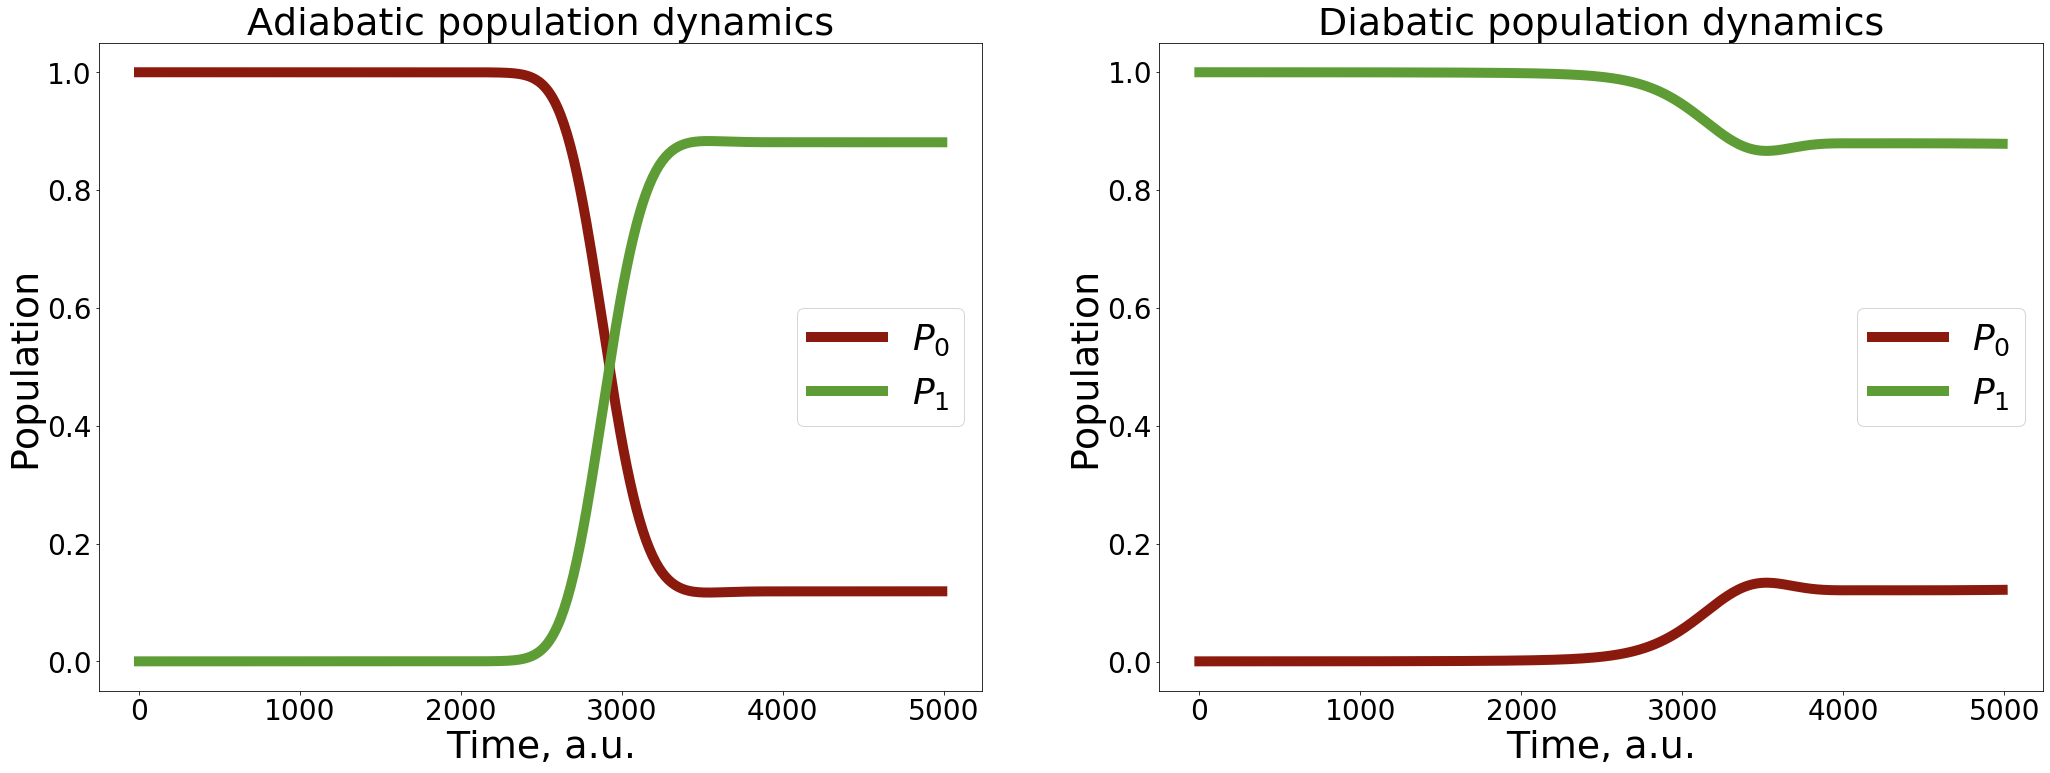

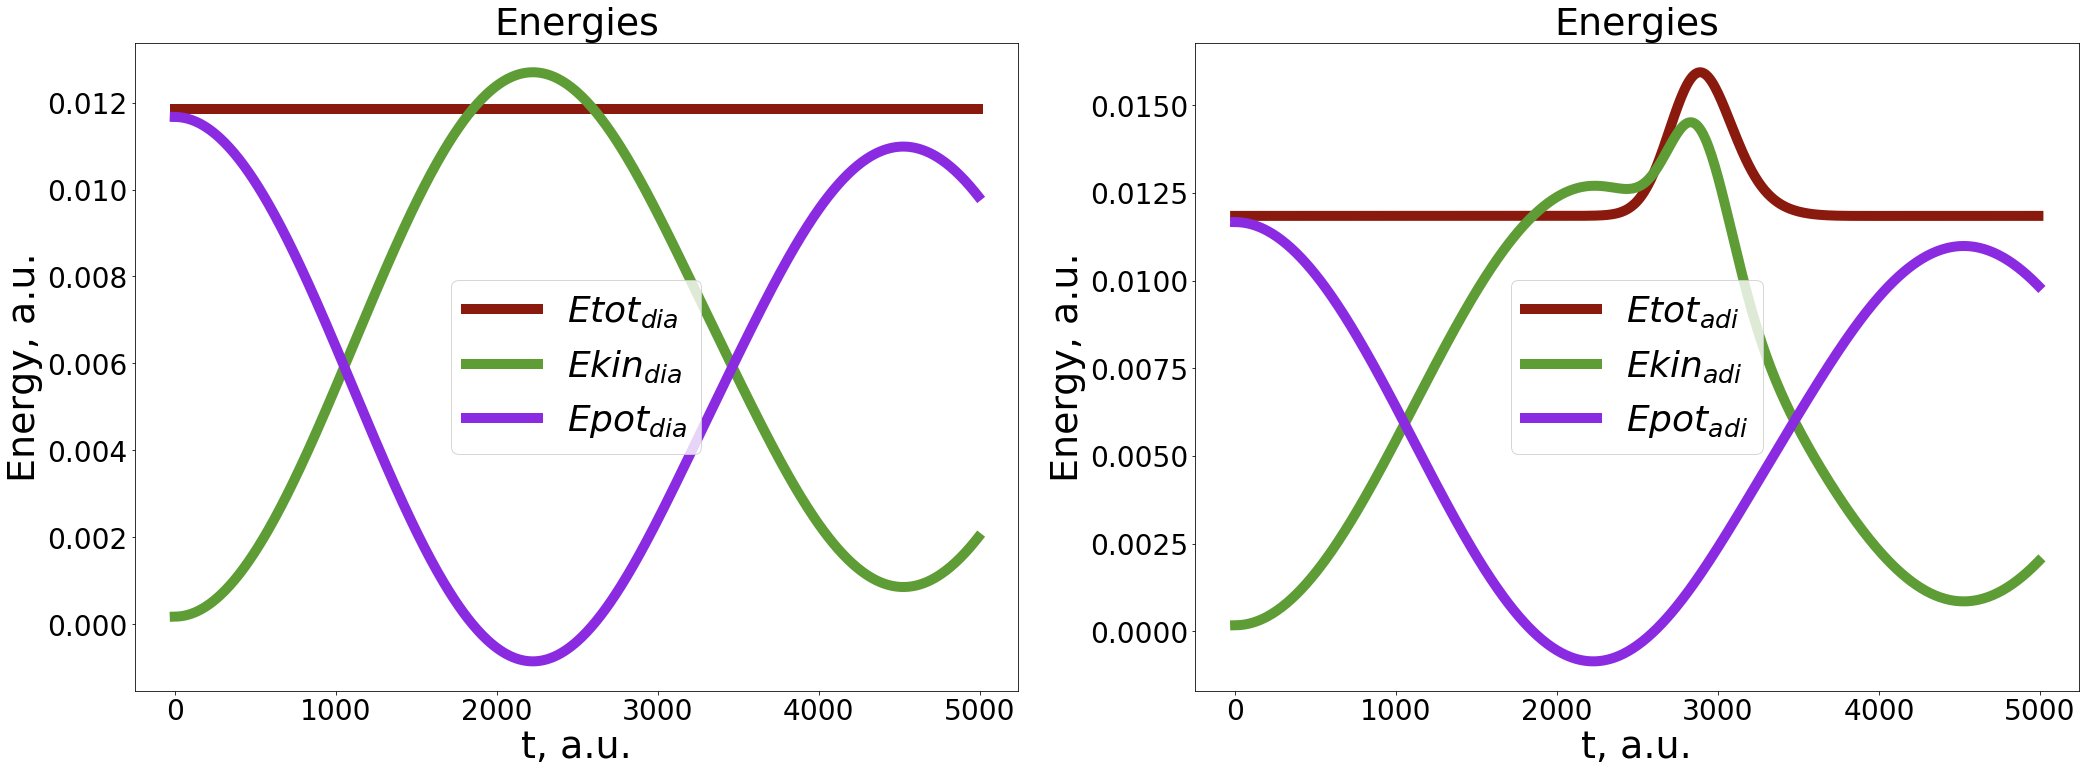

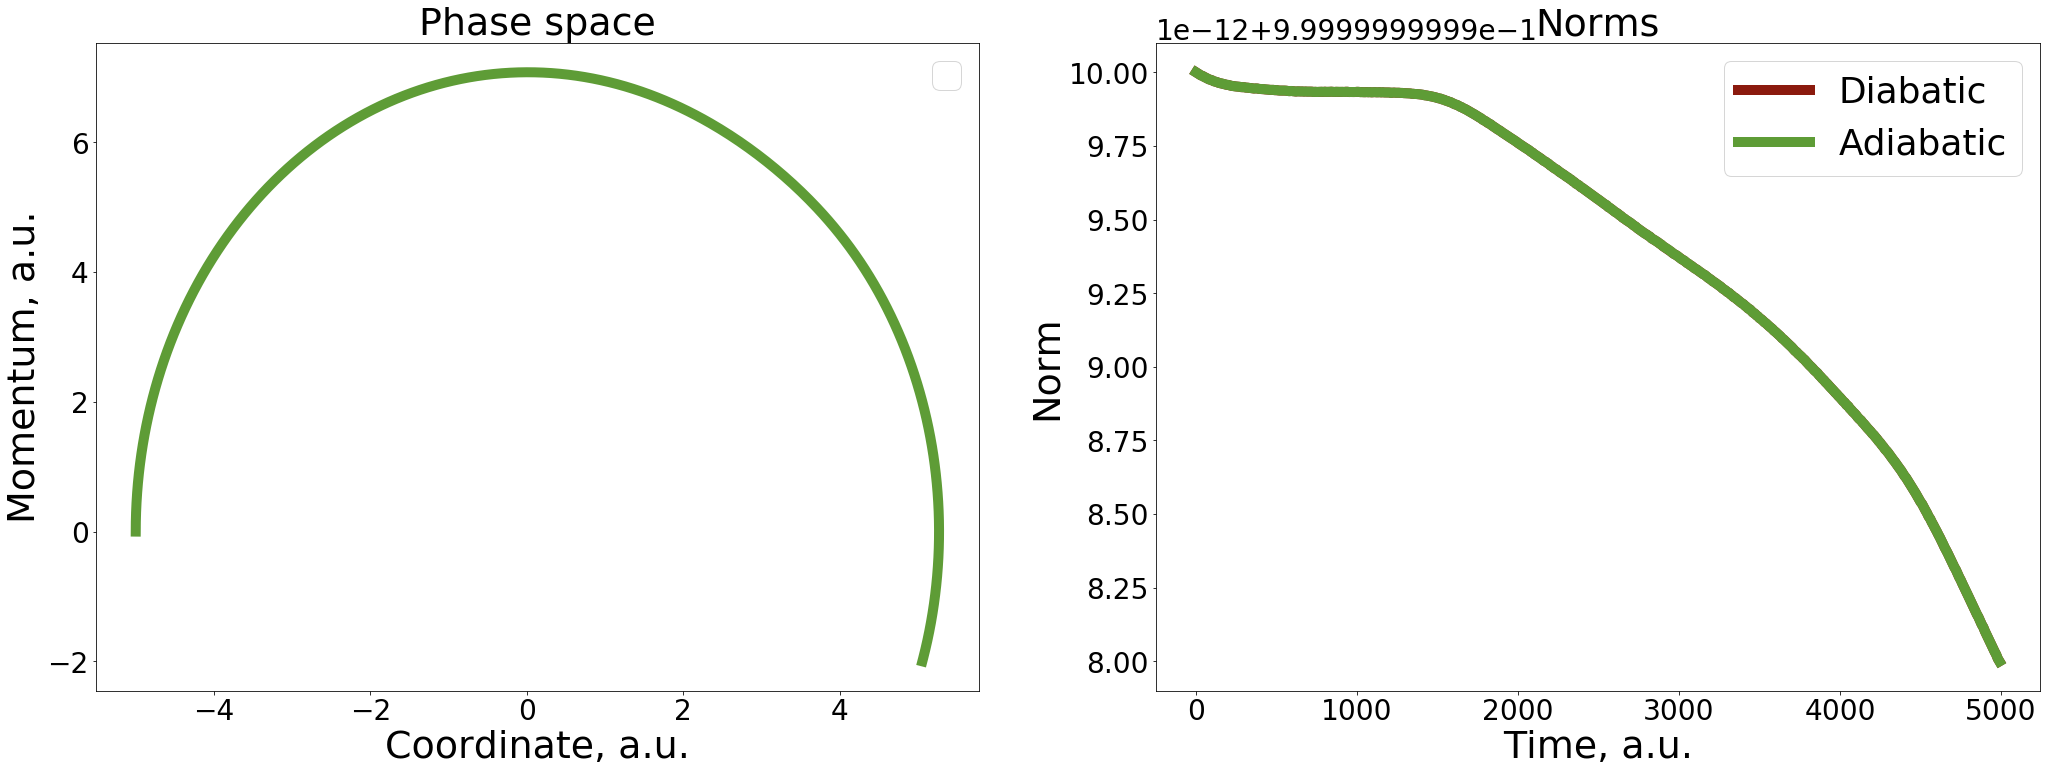

In [30]:
plot_mem(res, params1, model_params)

<a name="res-direct-dia-2"></a> [Back to TOC](#TOC)
### 5.2. Direct, Verlet-like, diabatic representation

In [31]:
params1 = dict(params)
params1.update({ "prefix":"case2-2",  "integrator":"direct_dia", "nsteps":5000, "dt":1.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 5000, 'dt': 1.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'direct_dia', 'prefix': 'case2-2', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017677820768301536
Ekin (adi) =  0.00017677669529

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


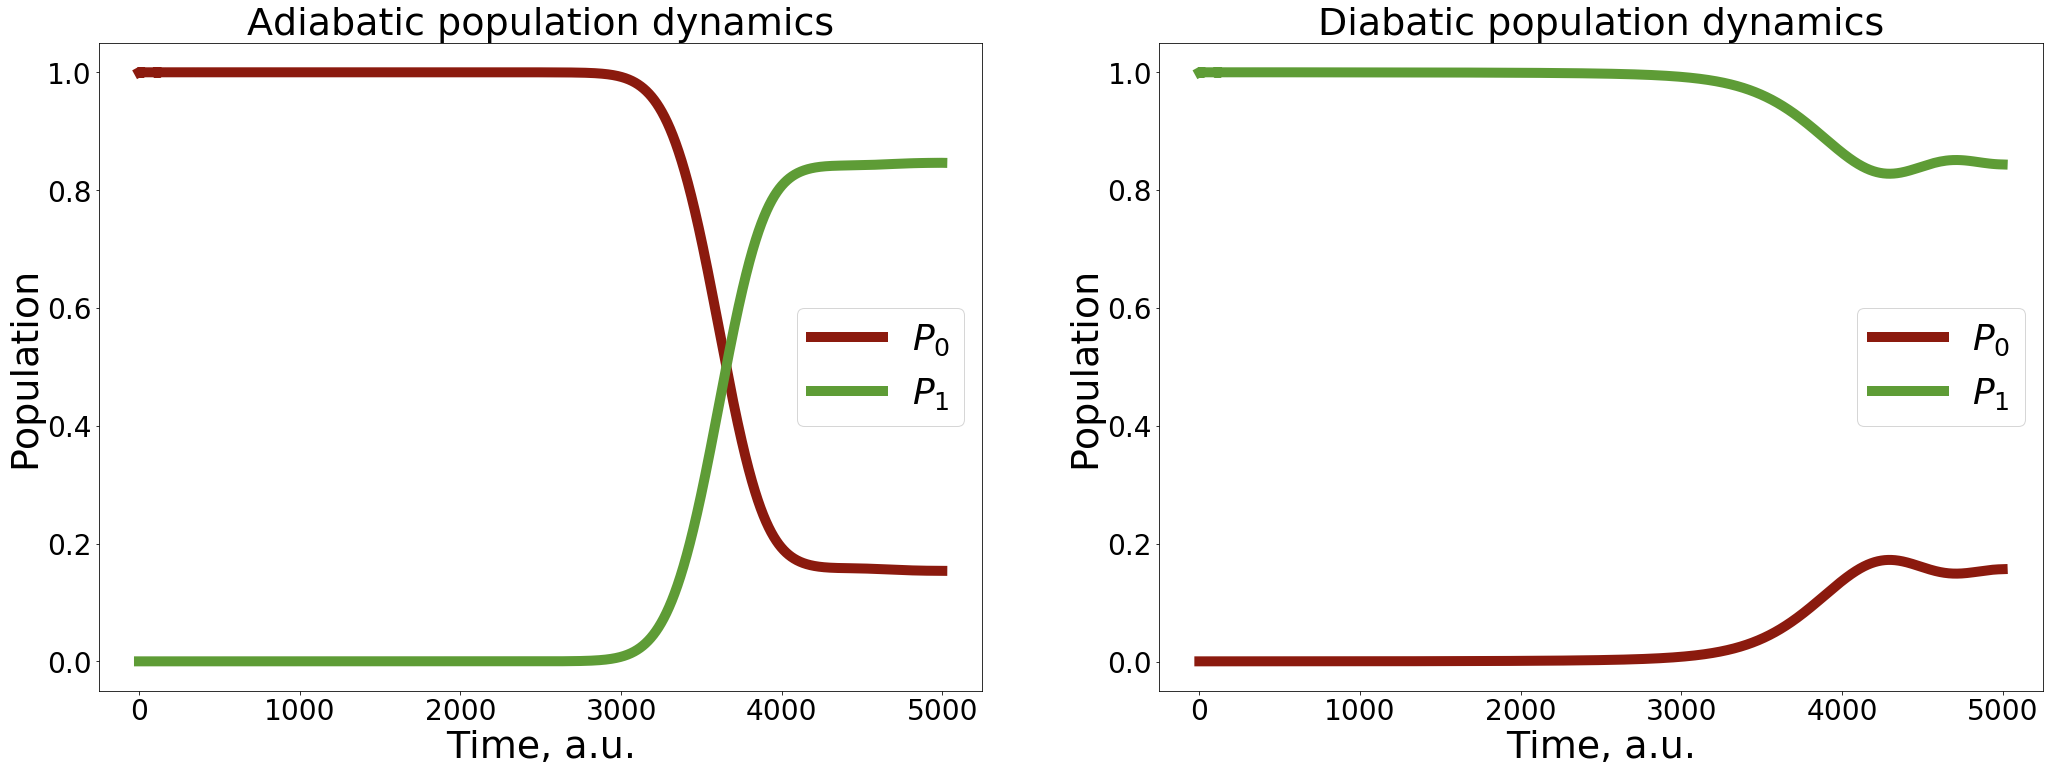

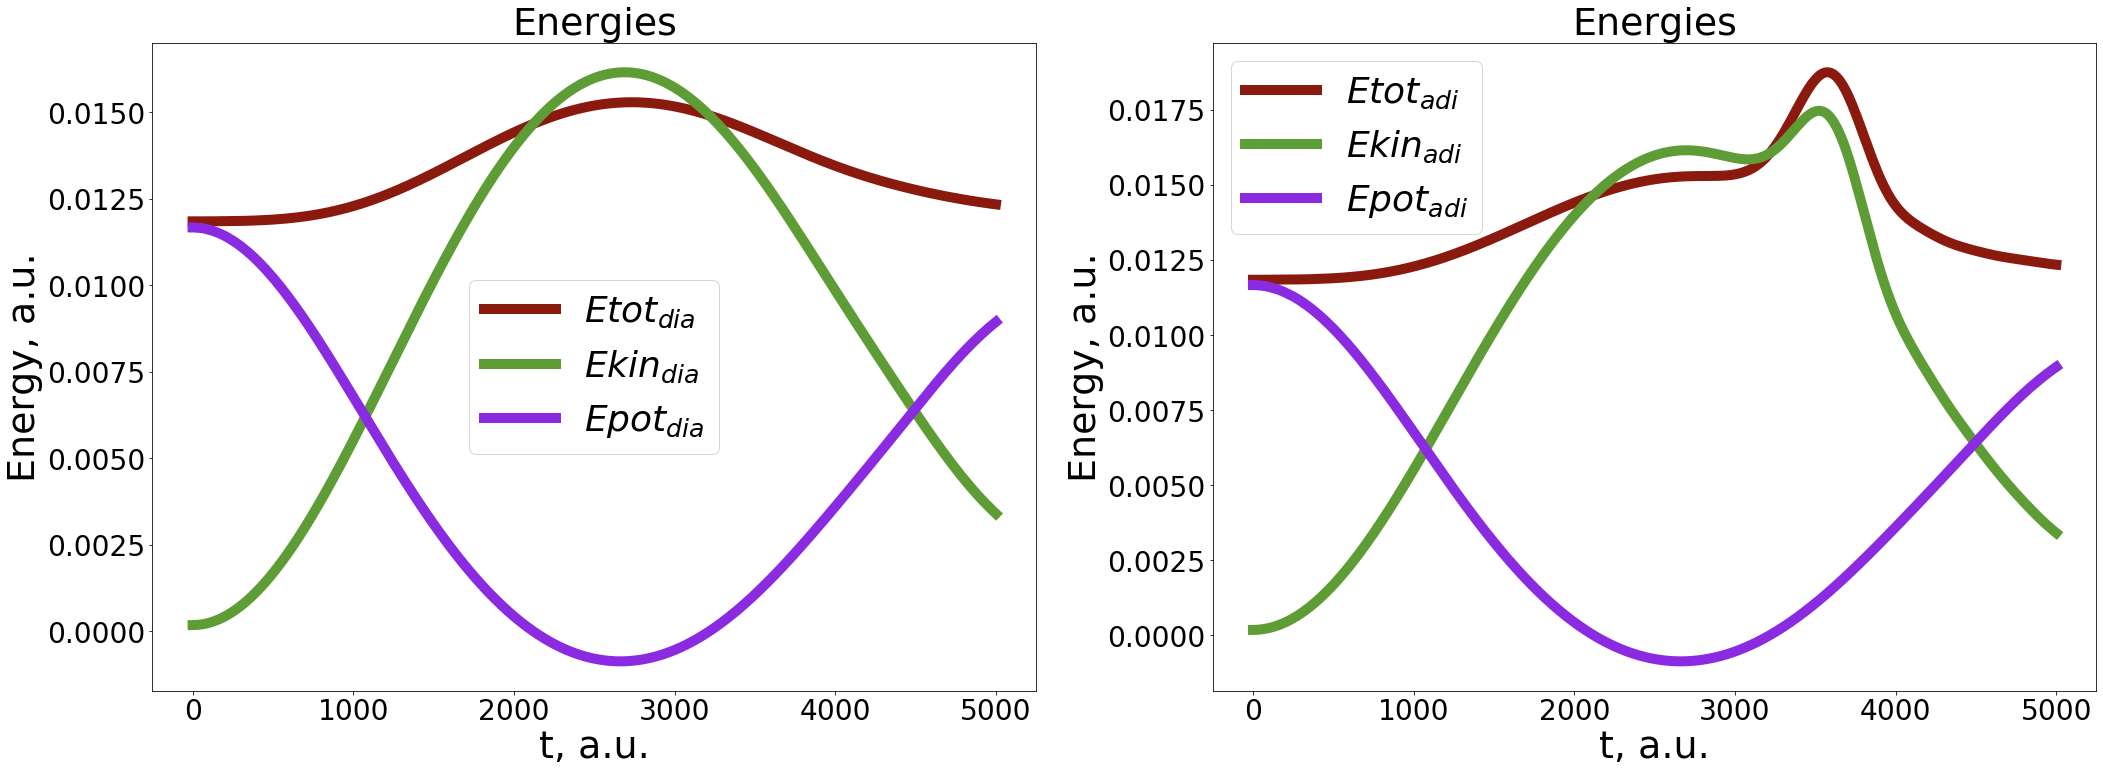

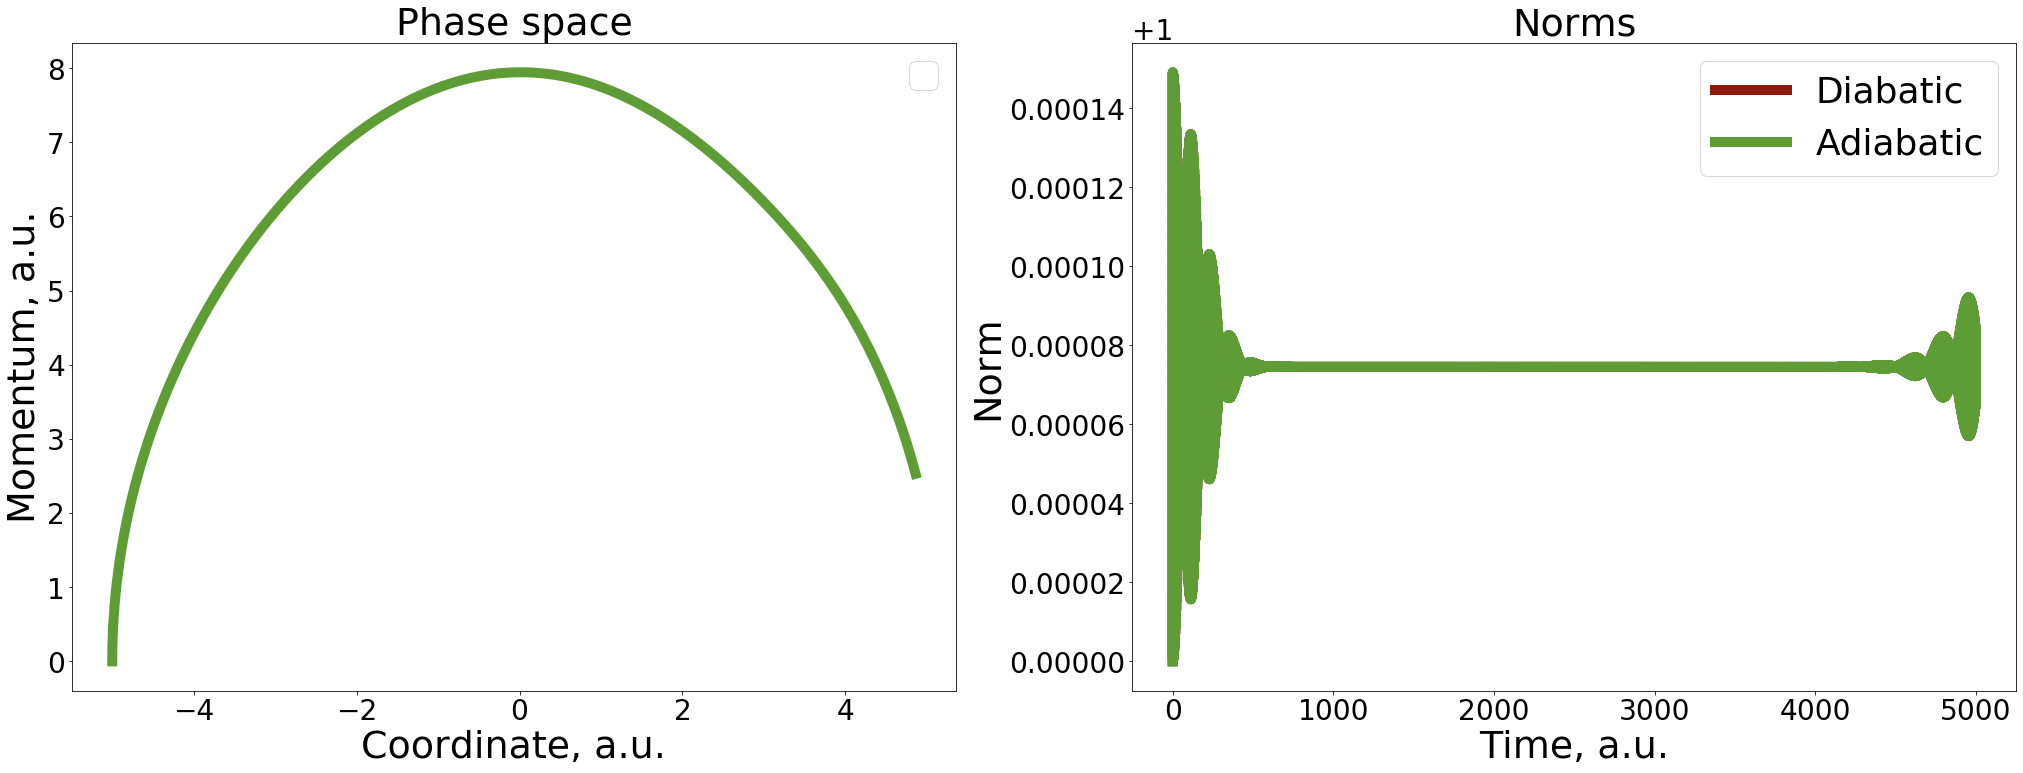

In [32]:
plot_mem(res, params1, model_params)

<a name="res-direct-adi-2"></a> [Back to TOC](#TOC)
### 5.3. Direct, Verlet-like, adiabatic representation

In [33]:
params1 = dict(params)
params1.update({ "prefix":"case3-2",  "integrator":"direct_adi", "nsteps":5000, "dt":1.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 5000, 'dt': 1.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'direct_adi', 'prefix': 'case3-2', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017677820768301536
Ekin (adi) =  0.00017677669529

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


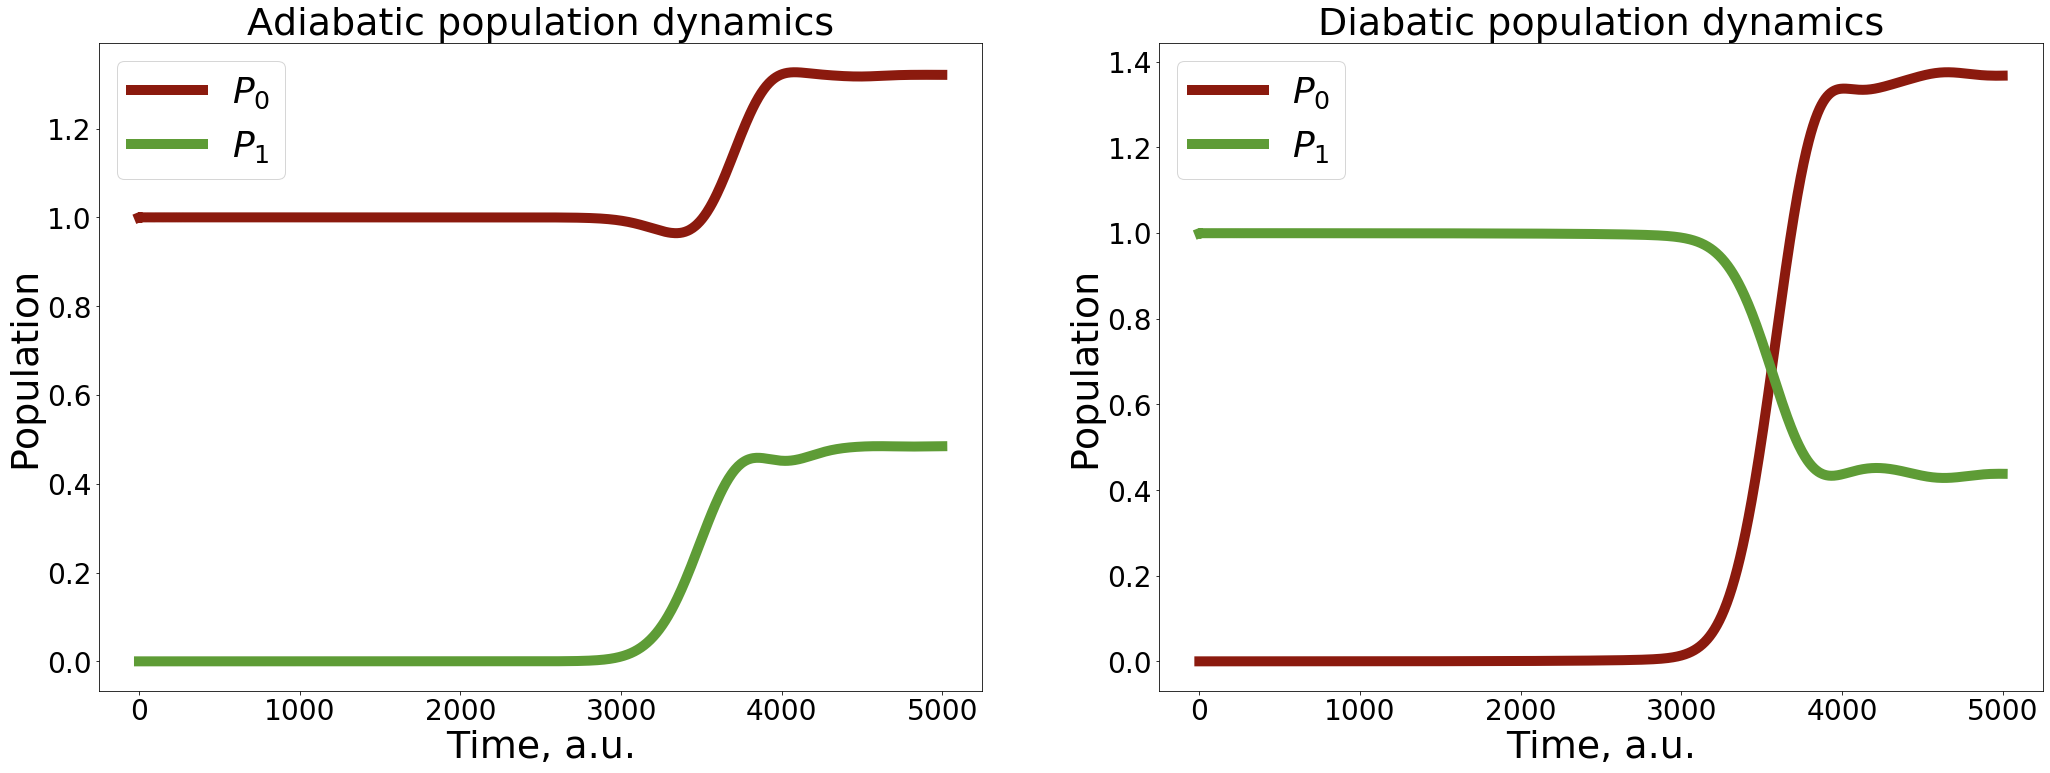

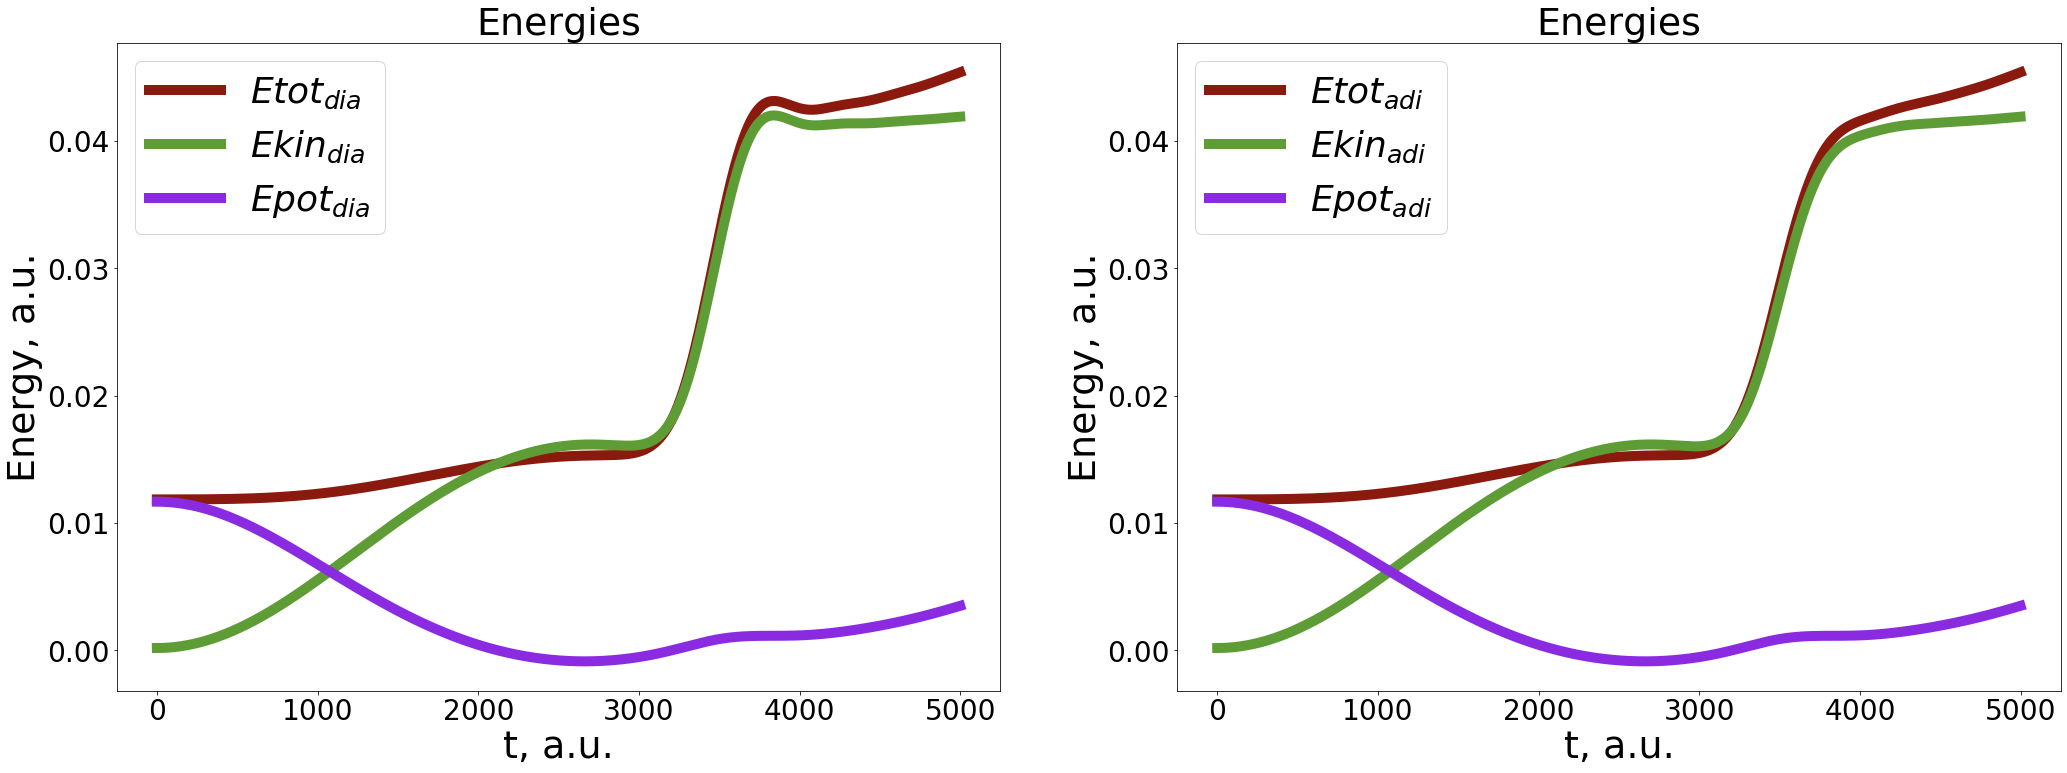

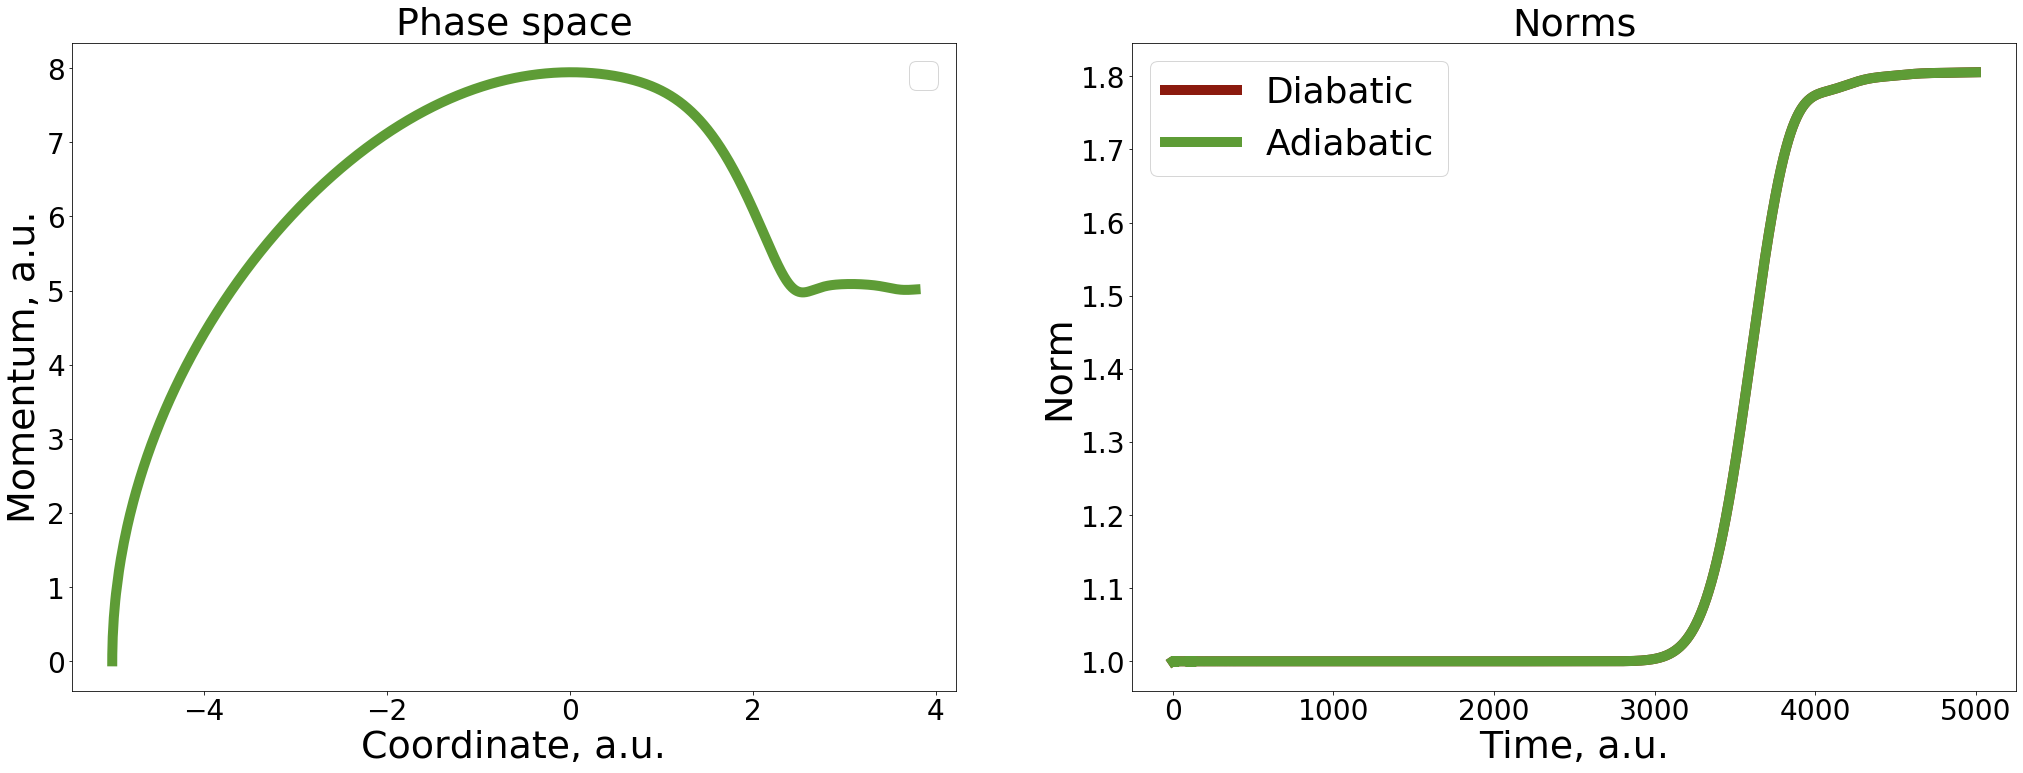

In [34]:
plot_mem(res, params1, model_params)

<a name="res-direct-colbert-miller-dia-2"></a> [Back to TOC](#TOC)
### 5.4. Direct, Verlet-like with Colbert-Miller DVR,  in diabatic representation

In [35]:
params1 = dict(params)
params1.update({ "prefix":"case4-2",  "integrator":"Colbert_Miller_dia", "nsteps":5000, "dt":1.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 5000, 'dt': 1.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'Colbert_Miller_dia', 'prefix': 'case4-2', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017677820768301536
Ekin (adi) =  0.000176

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


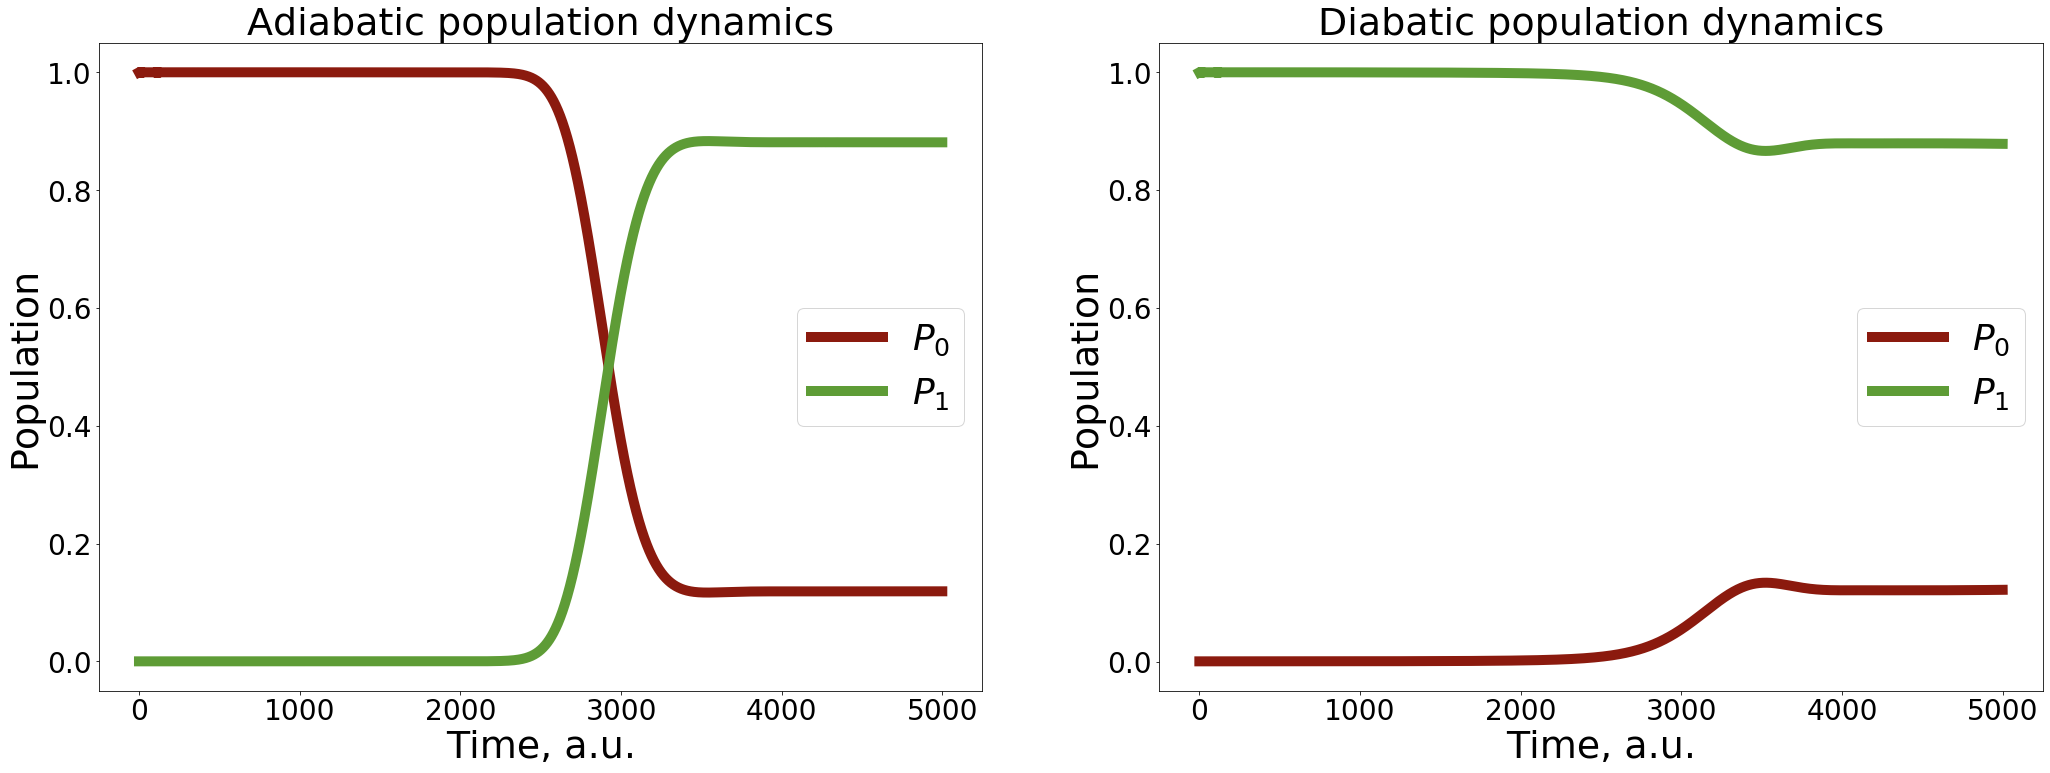

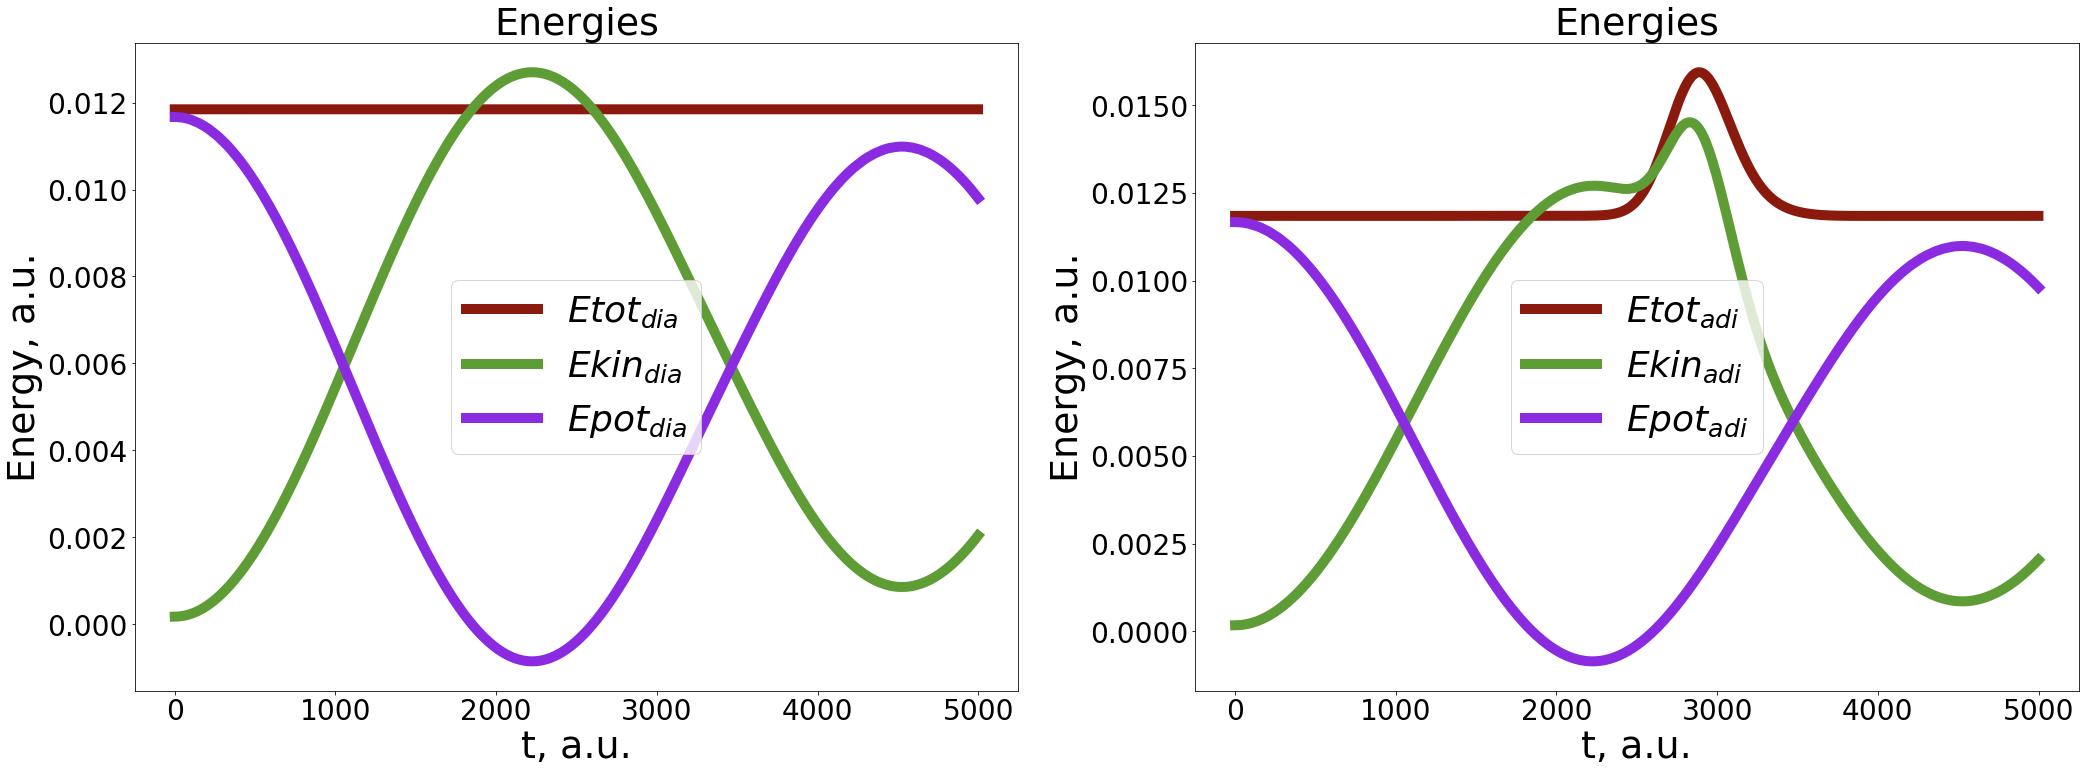

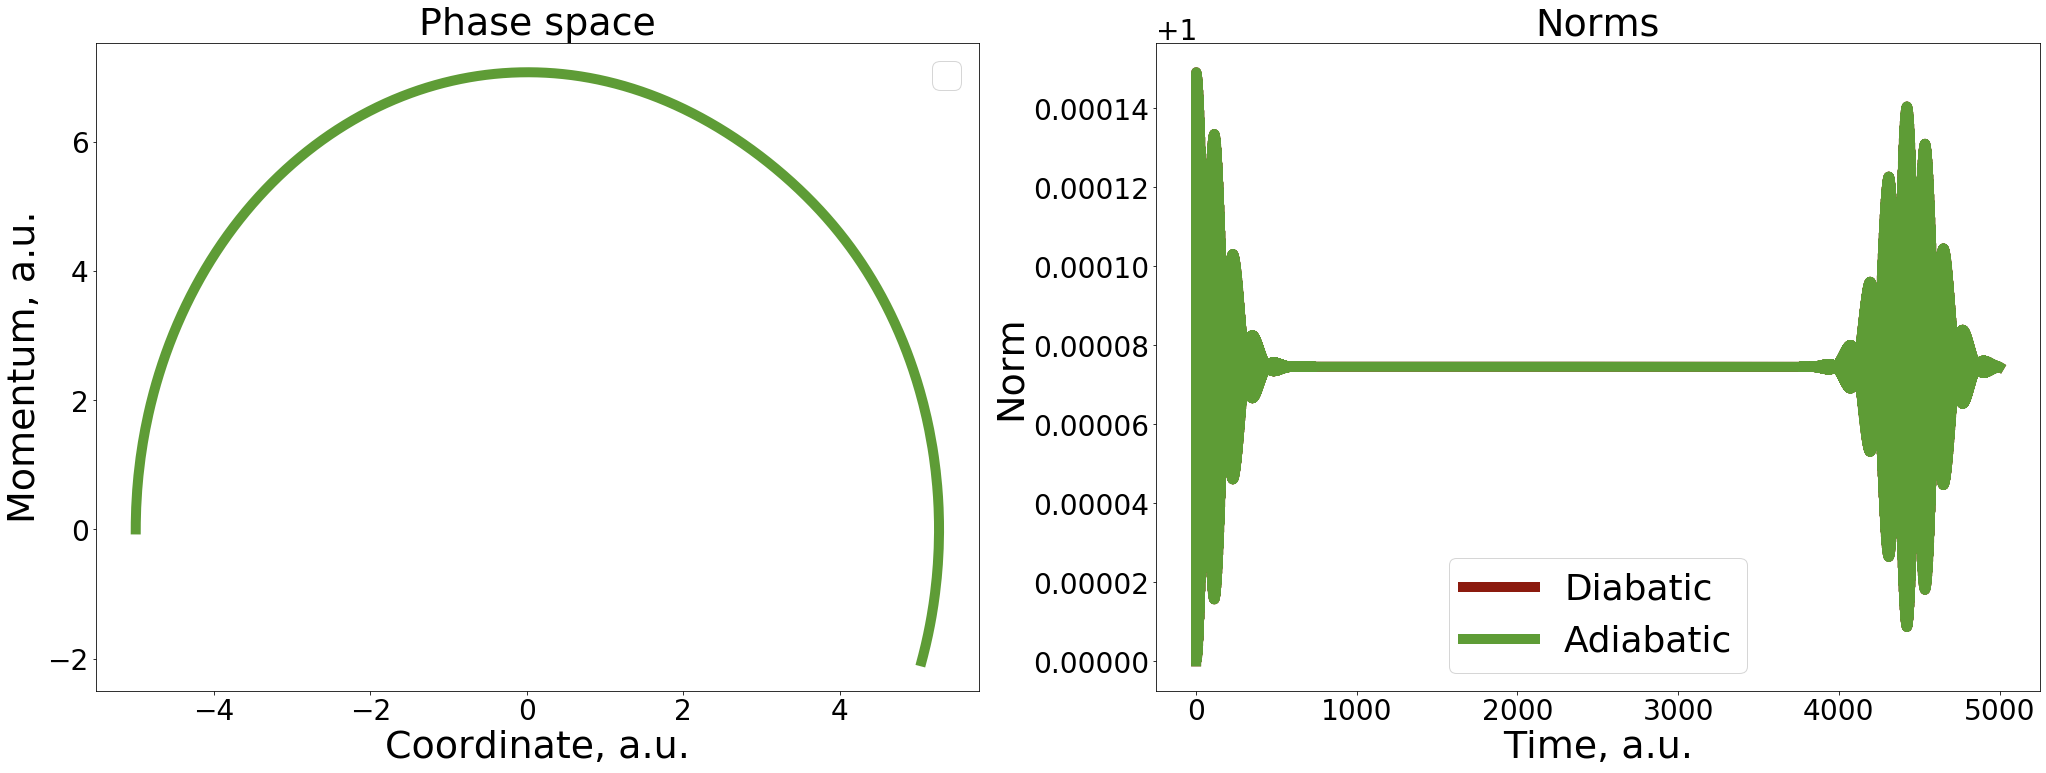

In [36]:
plot_mem(res, params1, model_params)

<a name="res-direct-colbert-miller-adi-2"></a> [Back to TOC](#TOC)
### 5.5. Direct, Verlet-like with Colbert-Miller DVR,  in adiabatic representation

In [37]:
params1 = dict(params)
params1.update({ "prefix":"case5-2",  "integrator":"Colbert_Miller_adi", "nsteps":5000, "dt":1.0  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 5000, 'dt': 1.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'Colbert_Miller_adi', 'prefix': 'case5-2', 'hdf5_output_level': 0, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017677820768301536
Ekin (adi) =  0.000176

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


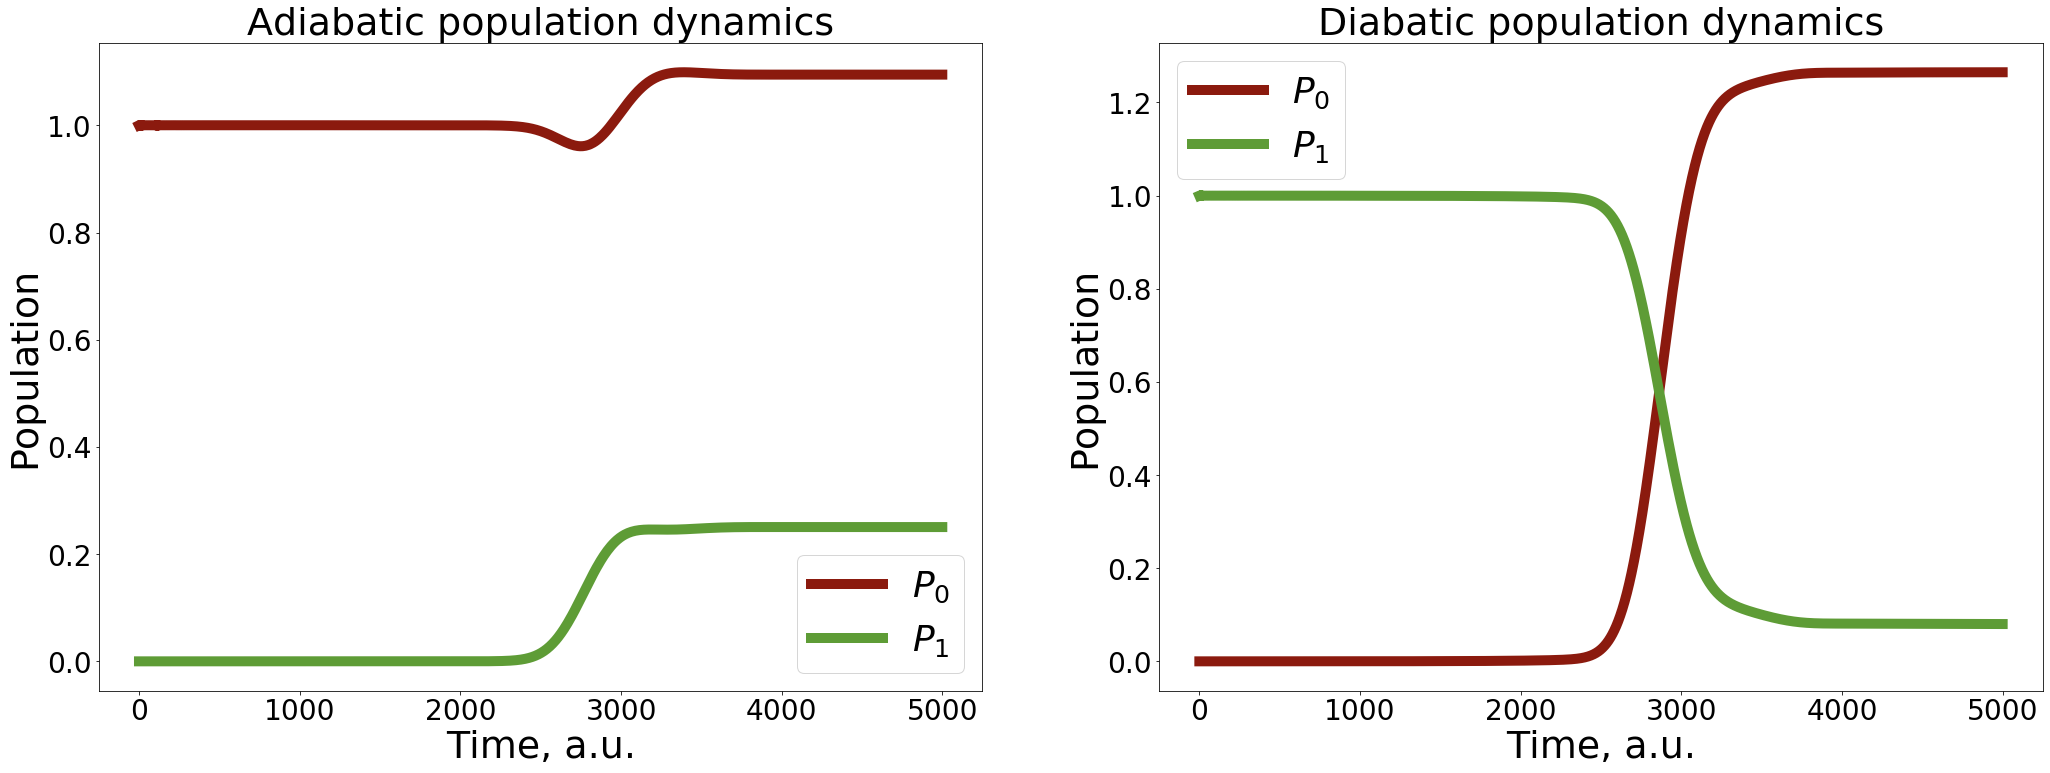

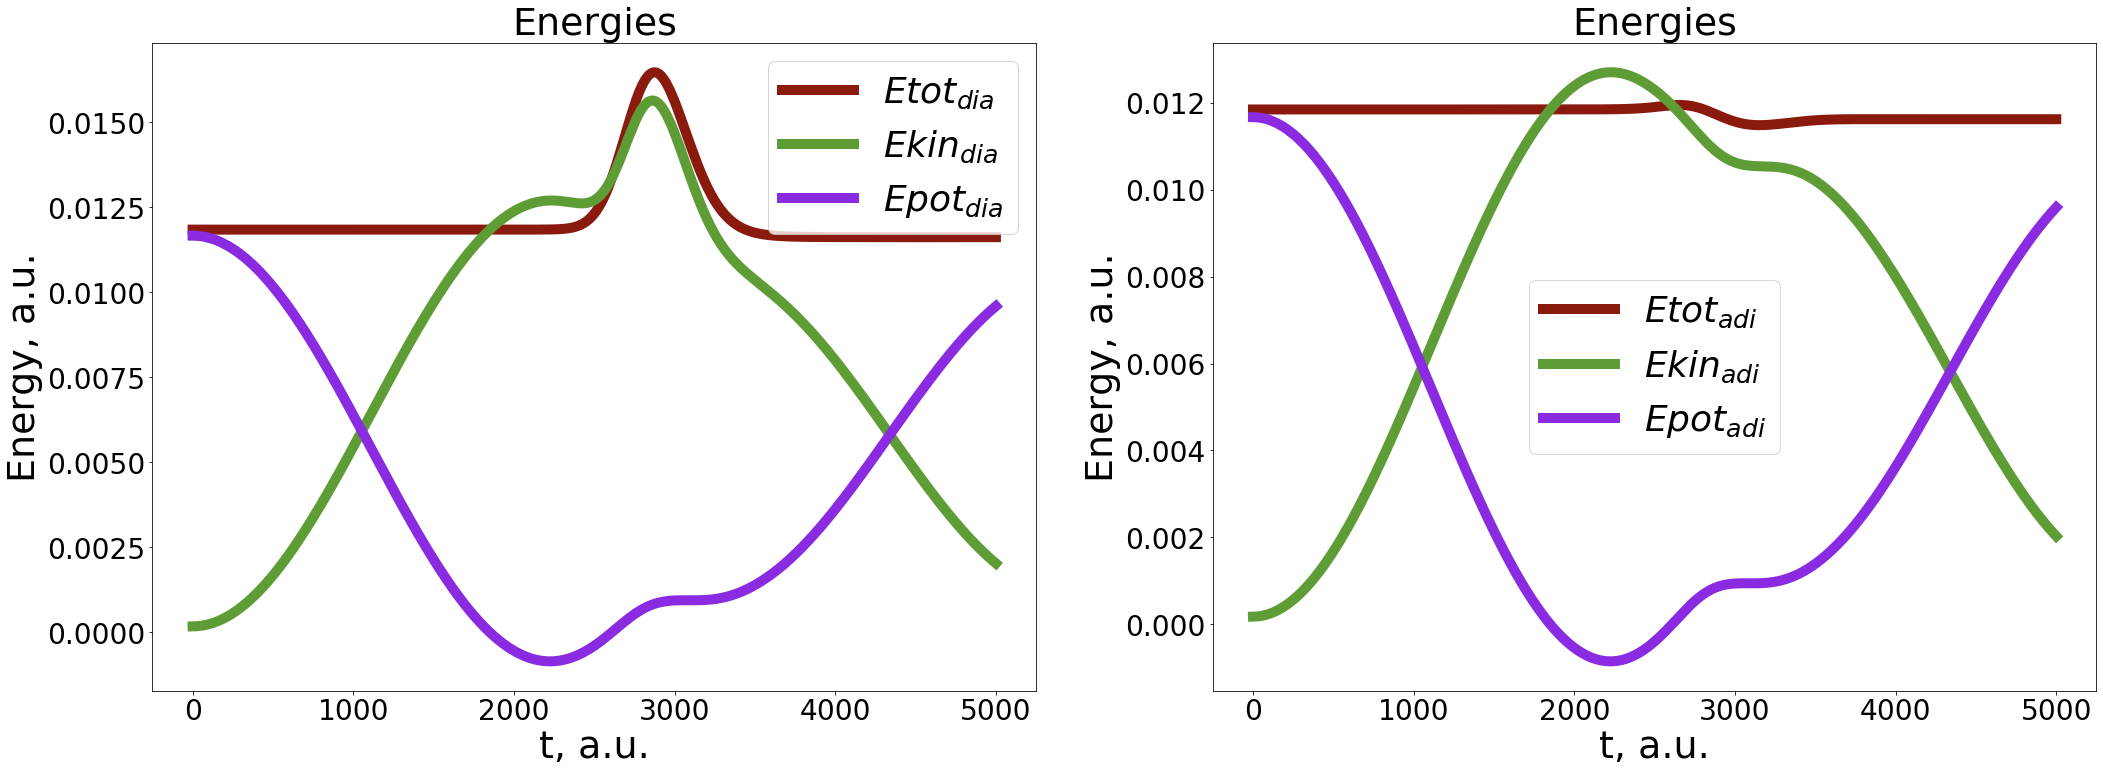

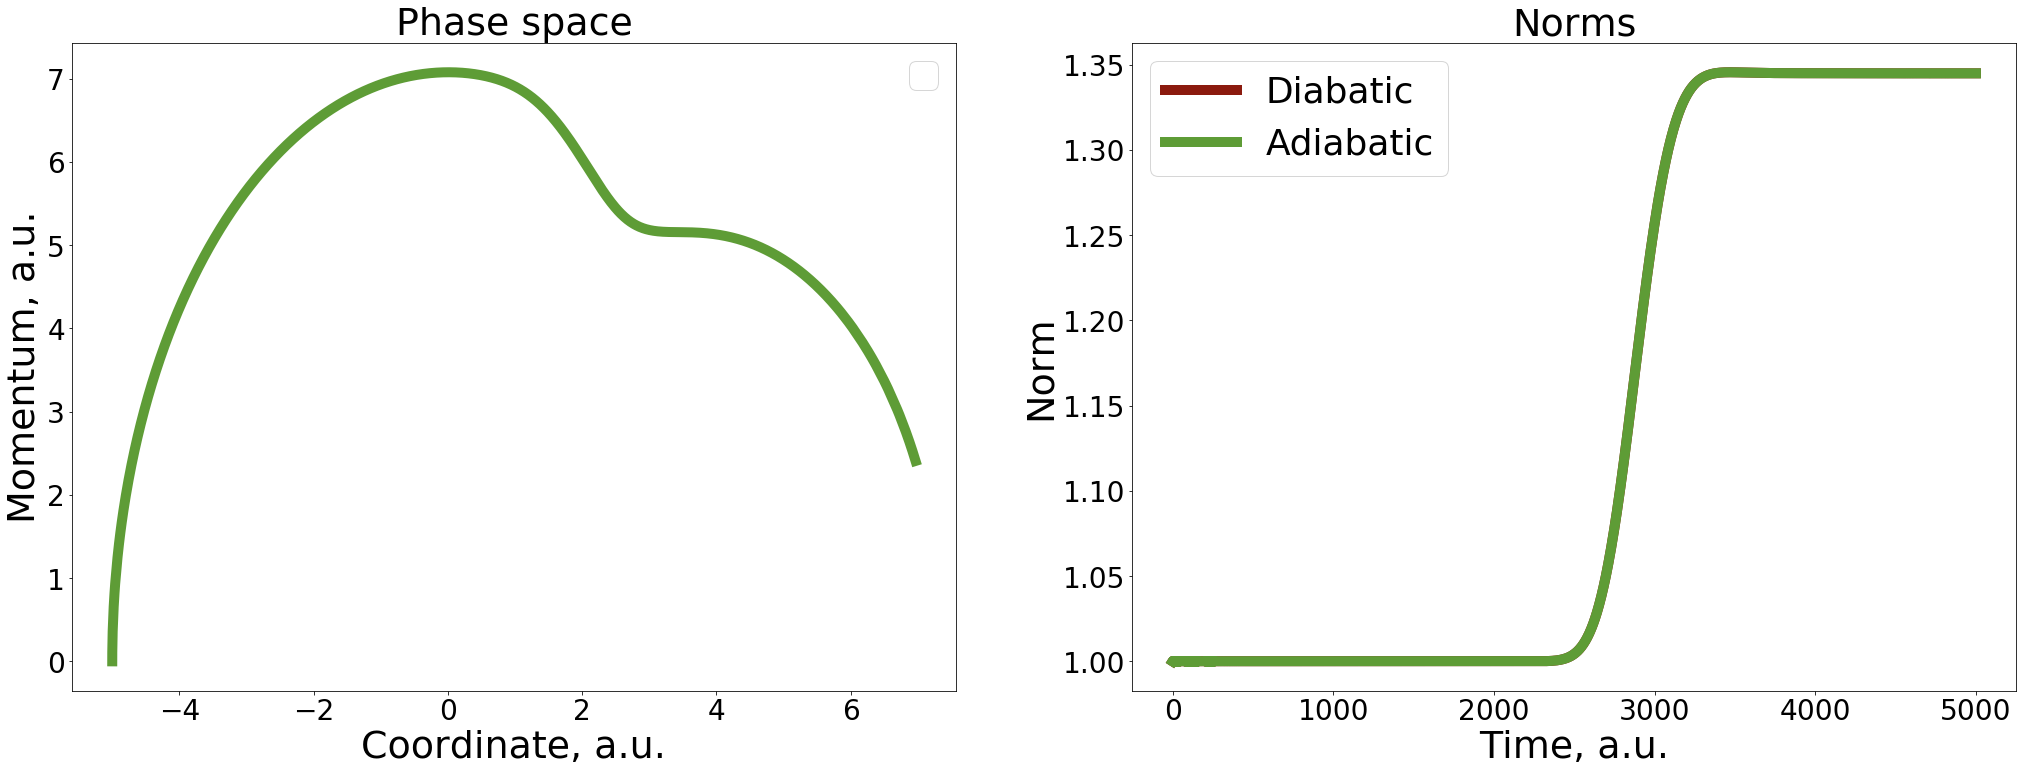

In [38]:
plot_mem(res, params1, model_params)

<a name="res-soft-colbert-miller-2"></a> [Back to TOC](#TOC)
### 5.6. SOFT integrator with the kinetic energy operator represented by the Colbert-Miller DVR in real space, in diabatic representation

In [43]:
params1 = dict(params)
params1.update({ "prefix":"case6-2",  "integrator":"Colbert_Miller_SOFT", "nsteps":500, "dt":10.0, 
                 "hdf5_output_level":3  })
res = run_case( params1, potential, model_params )

Run calculations with the dynamical parameters  {'nsteps': 500, 'dt': 10.0, 'progress_frequency': 0.1, 'rmin': [-15.0], 'rmax': [15.0], 'dx': [0.1], 'nstates': 2, 'x0': [-5.0], 'p0': [0.0], 'istate': [1, 0], 'masses': [2000.0], 'k': [0.001], 'integrator': 'Colbert_Miller_SOFT', 'prefix': 'case6-2', 'hdf5_output_level': 3, 'compression_level': [0, 0, 0], 'use_compression': 0, 'mem_output_level': 3, 'txt_output_level': 0, 'properties_to_save': ['timestep', 'time', 'Ekin_dia', 'Ekin_adi', 'Epot_dia', 'Epot_adi', 'Etot_dia', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'q2_dia', 'q2_adi', 'p_dia', 'p_adi', 'p2_dia', 'p2_adi', 'denmat_dia', 'denmat_adi', 'PSI_dia', 'PSI_adi', 'reciPSI_dia', 'reciPSI_adi']}
Run calculations with the model parameters  {'model': 1, 'E_n': [0.0, -0.001], 'x_n': [4.0, 0.0], 'k_n': [0.001, 0.001], 'V': 0.0005}
Norm (dia) =  0.9999999999999999
Norm (adi) =  0.9999999999999997
Ekin (dia) =  0.00017677820768301536
Ekin (adi) =  0.00017

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


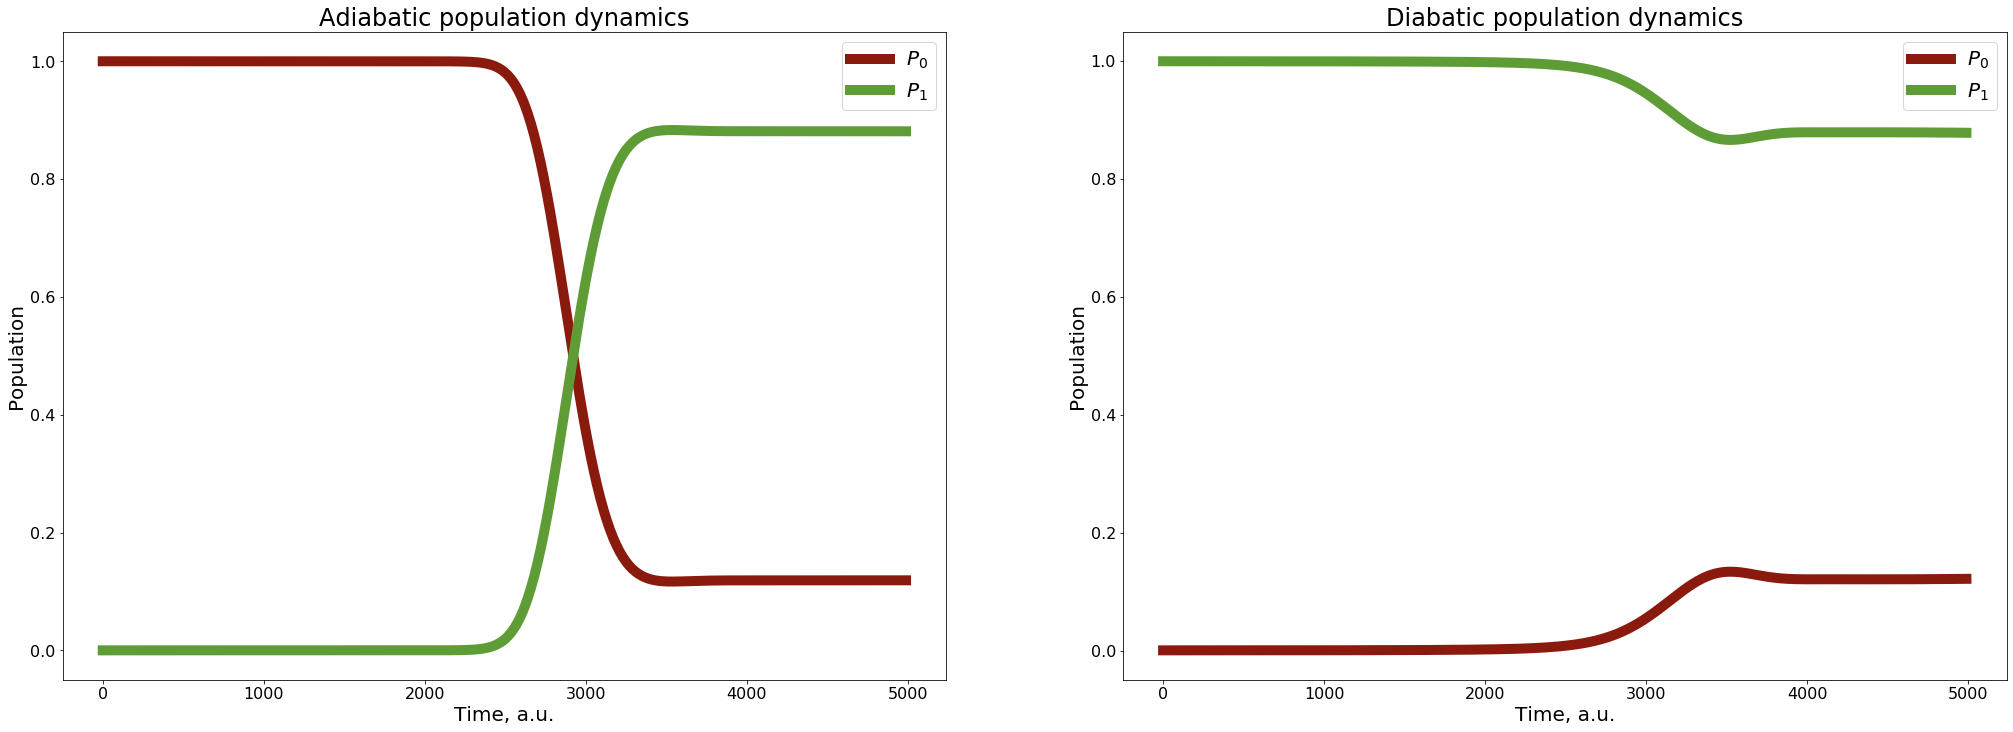

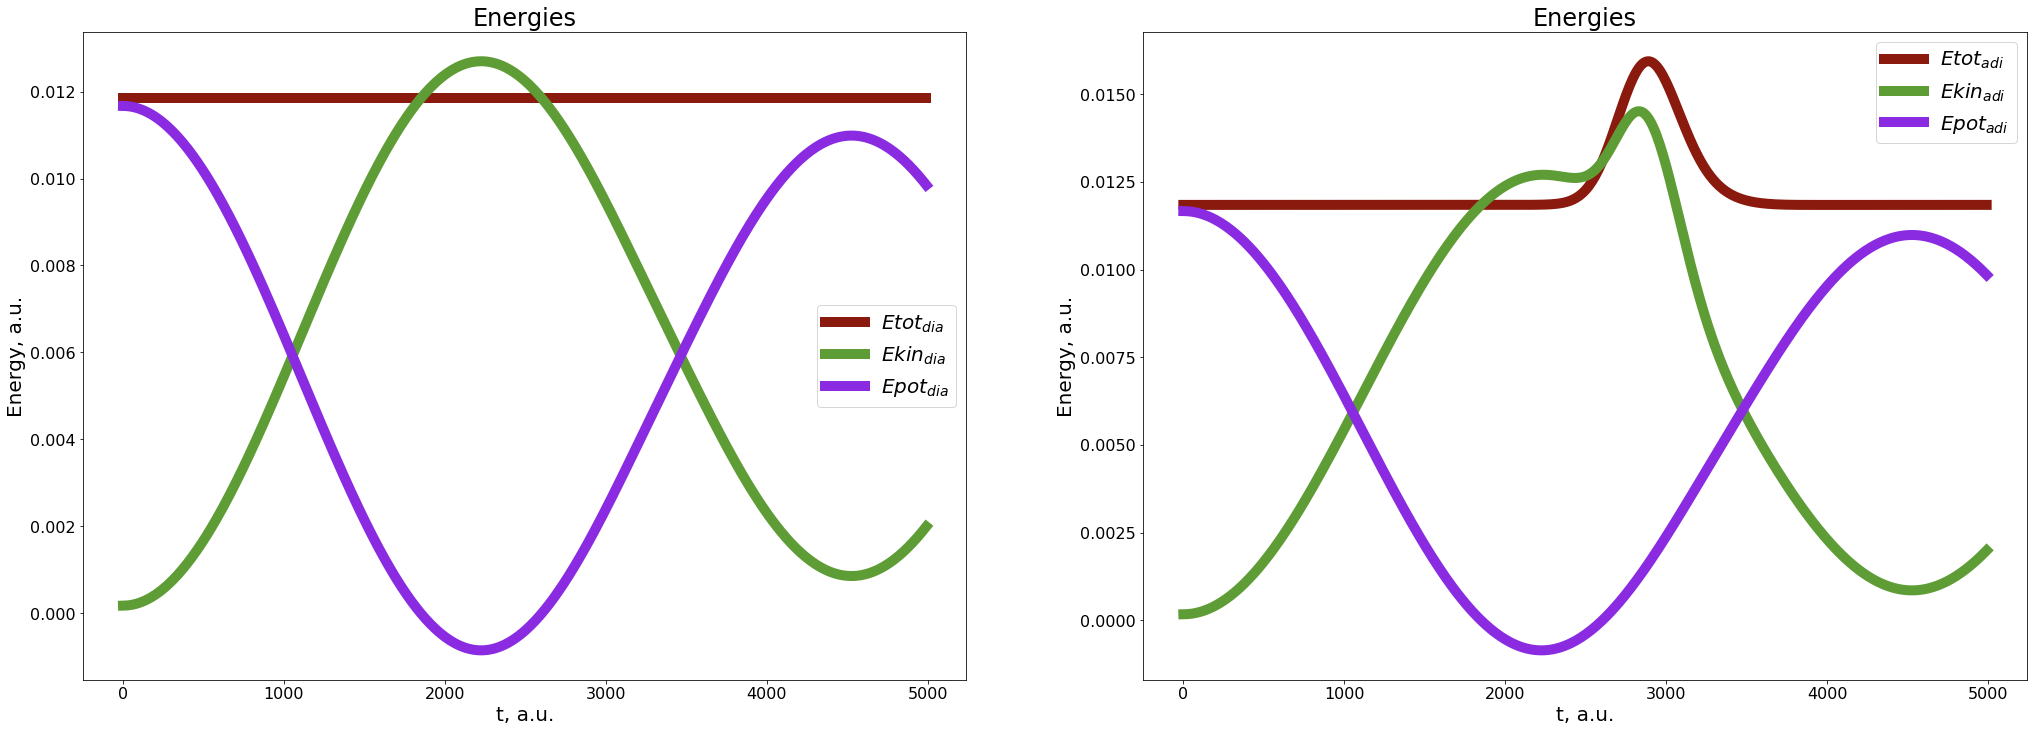

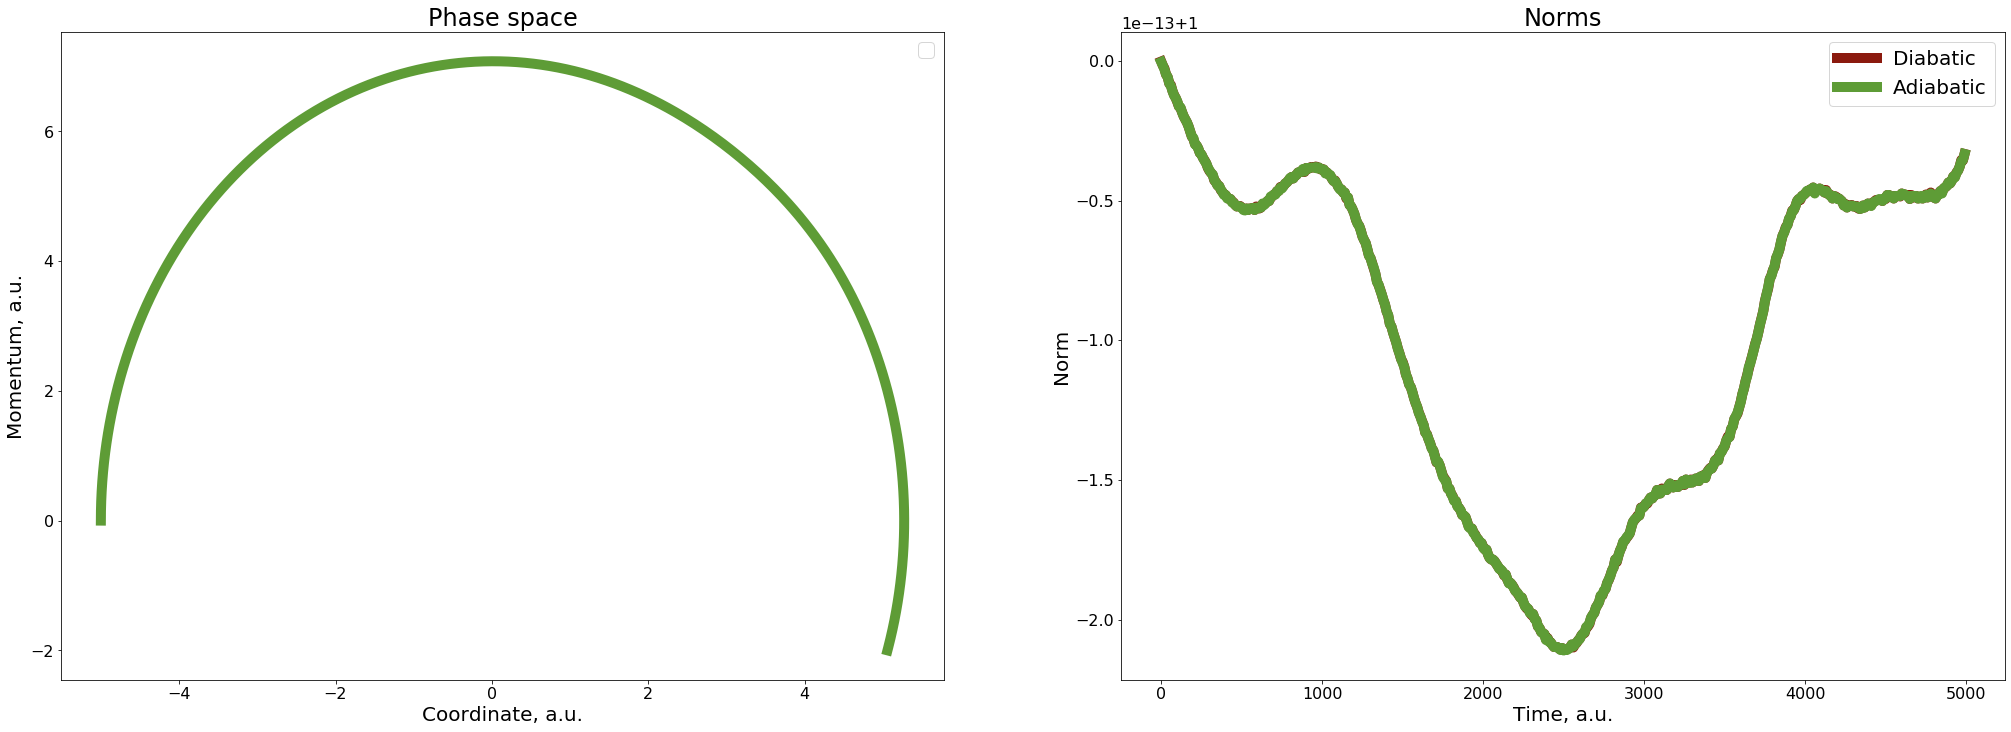

In [44]:
plot_mem(res, params1, model_params)

<a name="hdf5_plotting"></a> [Back to TOC](#TOC)
## 6. HDF5 plotting

Here, we develop a function to plot the same figures as before, but just using the HDF5 data files stored

In [45]:
def plot_dyn_exact(plot_params):
    """
    This function is meant to plot the results stored in the hdf files generated by the exact dynamics runs

    Args:

        prefix ( string ): the name of the directory containing the input HDF5 file
            This directory will also be used to output the generated picture files [ default : "out"]
        filename ( string ): name of the HDF5 file to read [ default: "data.hdf"]
        output_level ( int ): the level of info contained in the HDF5 file [ default : 3]        
        which_adi_states ( list of ints ) : indices of the adiabatic states to print [ default: [0] ]
        which_dia_states ( list of ints ) : indices of the diabatic states to print [ default: [0] ]
        colors ( dictionary ): the definition of the colors to use
        clrs_index ( list of strings ) : defines the mapping of the colors on integers and vice versa 
    

    """
    
    plt.rc('axes', titlesize=24)      # fontsize of the axes title
    plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
    plt.rc('legend', fontsize=20)     # legend fontsize
    plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

    plt.rc('figure.subplot', left=0.2)
    plt.rc('figure.subplot', right=0.95)
    plt.rc('figure.subplot', bottom=0.13)
    plt.rc('figure.subplot', top=0.88)


    colors = {}

    colors.update({"11": "#8b1a0e"})  # red       
    colors.update({"12": "#FF4500"})  # orangered 
    colors.update({"13": "#B22222"})  # firebrick 
    colors.update({"14": "#DC143C"})  # crimson   

    colors.update({"21": "#5e9c36"})  # green
    colors.update({"22": "#006400"})  # darkgreen  
    colors.update({"23": "#228B22"})  # forestgreen
    colors.update({"24": "#808000"})  # olive      

    colors.update({"31": "#8A2BE2"})  # blueviolet
    colors.update({"32": "#00008B"})  # darkblue  

    colors.update({"41": "#2F4F4F"})  # darkslategray

    clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]



    # Parameters and dimensions
    critical_params = [  ] 
    default_params = {  "prefix":"out", "filename":"data.hdf", "hdf5_output_level":3,
                        "which_dofs":[0], "which_adi_states":[0], "which_dia_states":[0],
                        "colors":colors, "clrs_index":clrs_index,
                        "properties_to_save": 
                          [ "timestep", "time", "Ekin_dia", "Ekin_adi", "Epot_dia", 
                            "Epot_adi", "Etot_dia", "Etot_adi", "norm_dia", "norm_adi",
                            "pop_dia", "pop_adi", "q_dia", "q_adi", "q2_dia", "q2_adi", 
                            "p_dia", "p_adi", "p2_dia", "p2_adi",
                            "denmat_dia", "denmat_adi", 
                            "PSI_dia", "PSI_adi", "reciPSI_dia", "reciPSI_adi" ] 
                     }
    comn.check_input(plot_params, default_params, critical_params)
        

            
    filename = plot_params["filename"]
    prefix = plot_params["prefix"]
    hdf5_output_level = plot_params["hdf5_output_level"]    
    which_dofs = plot_params["which_dofs"]
    which_adi_states = plot_params["which_adi_states"]
    which_dia_states = plot_params["which_dia_states"]
    colors = plot_params["colors"]
    clrs_index = plot_params["clrs_index"]
    properties_to_save = plot_params["properties_to_save"]

    out_prefix = prefix
    

    with h5py.File(F"{prefix}/{filename}", 'r') as f:
    
        t = None
        if "time" in properties_to_save:                        
            t = list(f["time/data"][:])
    
        #=============== Populations ======================
    
        plt.figure(1, figsize=(36, 12)) # dpi=300, frameon=False)    
        plt.subplot(1, 2, 1)
        plt.title('Adiabatic population dynamics' )
        plt.xlabel('Time, a.u.')
        plt.ylabel('Population')
    
        if "pop_adi" in properties_to_save and t != None:
            nstates = f["pop_adi/data"].shape[1] #.attrs['dim'][1]                        
            for i in range(nstates):        
                if i in which_adi_states:
                    Pi = list(f["pop_adi/data"][:, i, 0])                
                    plt.plot(t, Pi, label='$P_%i$' % (i), linewidth=10, color = colors[clrs_index[i]])   
                    plt.legend()
    
    
        plt.subplot(1, 2, 2)
        plt.title('Diabatic population dynamics' )
        plt.xlabel('Time, a.u.')
        plt.ylabel('Population')
    
        if "pop_dia" in properties_to_save and t != None:
            nstates = f["pop_dia/data"].shape[1] #.attrs['dim'][1]                        
            for i in range(nstates):
                if i in which_dia_states:
                    Pi = list(f["pop_dia/data"][:, i, 0])                            
                    plt.plot(t, Pi, label='$P_%i$' % (i), linewidth=10, color = colors[clrs_index[i]])   
                    plt.legend()
            
        plt.savefig("%s/Fig1.png" % (prefix), dpi=300)
        plt.savefig("%s/Fig1.pdf" % (prefix), dpi=300)
            
                
        #============= Energies =====================
        plt.figure(2, figsize=(36, 12)) # dpi=300, frameon=False)           
    
        plt.subplot(1, 2, 1)
        plt.title('Energies' )
        plt.xlabel('t, a.u.')
        plt.ylabel('Energy, a.u.')
        if "Ekin_dia" in properties_to_save \
           and "Epot_dia" in properties_to_save \
           and "Etot_dia" in properties_to_save \
           and t != None:
        
            Ekin_dia =  list(f["Ekin_dia/data"][:])                             
            Epot_dia =  list(f["Epot_dia/data"][:])                             
            Etot_dia =  list(f["Etot_dia/data"][:])                             
        
            plt.plot(t, Etot_dia, label='$Etot_{dia}$', linewidth=10, color = colors["11"])   
            plt.plot(t, Ekin_dia, label='$Ekin_{dia}$', linewidth=10, color = colors["21"])   
            plt.plot(t, Epot_dia, label='$Epot_{dia}$', linewidth=10, color = colors["31"])   
            plt.legend()
    
    
        plt.subplot(1, 2, 2)
        plt.title('Energies' )
        plt.xlabel('t, a.u.')
        plt.ylabel('Energy, a.u.')
    
        if "Ekin_adi" in properties_to_save \
           and "Epot_adi" in properties_to_save \
           and "Etot_adi" in properties_to_save \
           and t != None:
        
            Ekin_adi =  list(f["Ekin_adi/data"][:])                             
            Epot_adi =  list(f["Epot_adi/data"][:])                             
            Etot_adi =  list(f["Etot_adi/data"][:])                             
        
            plt.plot(t, Etot_adi, label='$Etot_{adi}$', linewidth=10, color = colors["11"])   
            plt.plot(t, Ekin_adi, label='$Ekin_{adi}$', linewidth=10, color = colors["21"])   
            plt.plot(t, Epot_adi, label='$Epot_{adi}$', linewidth=10, color = colors["31"])   
            plt.legend()

        plt.savefig("%s/Fig2.png" % (prefix), dpi=300)
        plt.savefig("%s/Fig2.pdf" % (prefix), dpi=300)
    
  
        #============= Phase spaces & Norms  =====================
        plt.figure(3, figsize=(36, 12)) # dpi=300, frameon=False)           
                
        plt.subplot(1, 2, 1)
        plt.title('Phase space' )
        plt.xlabel('Coordinate, a.u.')
        plt.ylabel('Momentum, a.u.')   
    
        if "q_dia" in properties_to_save and "p_dia" in properties_to_save:                                
            ndof = f["q_dia/data"].shape[1] #.attrs['dim'][1]                        
    
            for idof in range(ndof):
                if idof in which_dofs:
                    qi =  list(f["q_dia/data"][:, idof, 0])                             
                    pi =  list(f["p_dia/data"][:, idof, 0])                                         
    
                    plt.plot(qi, pi, label='', linewidth=10, color = colors[clrs_index[i]])   
                    plt.legend()
                    
                
        plt.subplot(1, 2, 2)
        plt.title('Norms' )
        plt.xlabel('Time, a.u.')
        plt.ylabel('Norm')
    
        if "norm_dia" in properties_to_save and "norm_adi" in properties_to_save and t != None:
        
            nrm_dia = list(f["norm_dia/data"][:])                             
            nrm_adi = list(f["norm_adi/data"][:])                                     
                
            plt.plot(t, nrm_dia, label='Diabatic', linewidth=10, color = colors["11"])   
            plt.plot(t, nrm_adi, label='Adiabatic', linewidth=10, color = colors["21"])   
            plt.legend()

        plt.savefig("%s/Fig3.png" % (prefix), dpi=300)
        plt.savefig("%s/Fig3.pdf" % (prefix), dpi=300)
    
        
        plt.show()
        plt.close()
        



/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


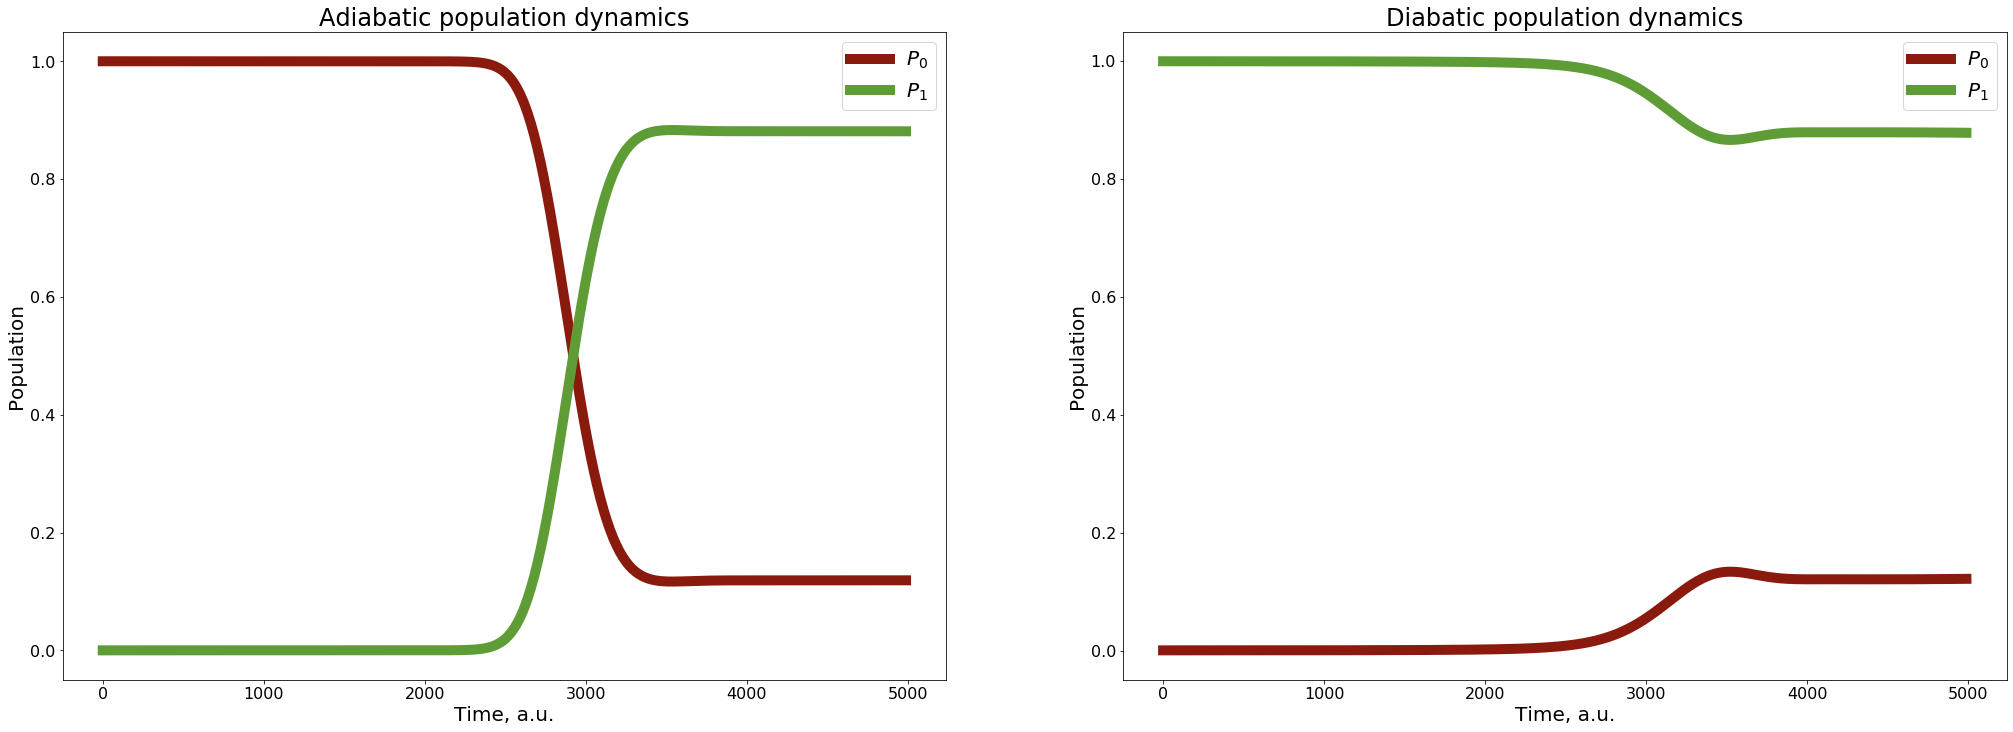

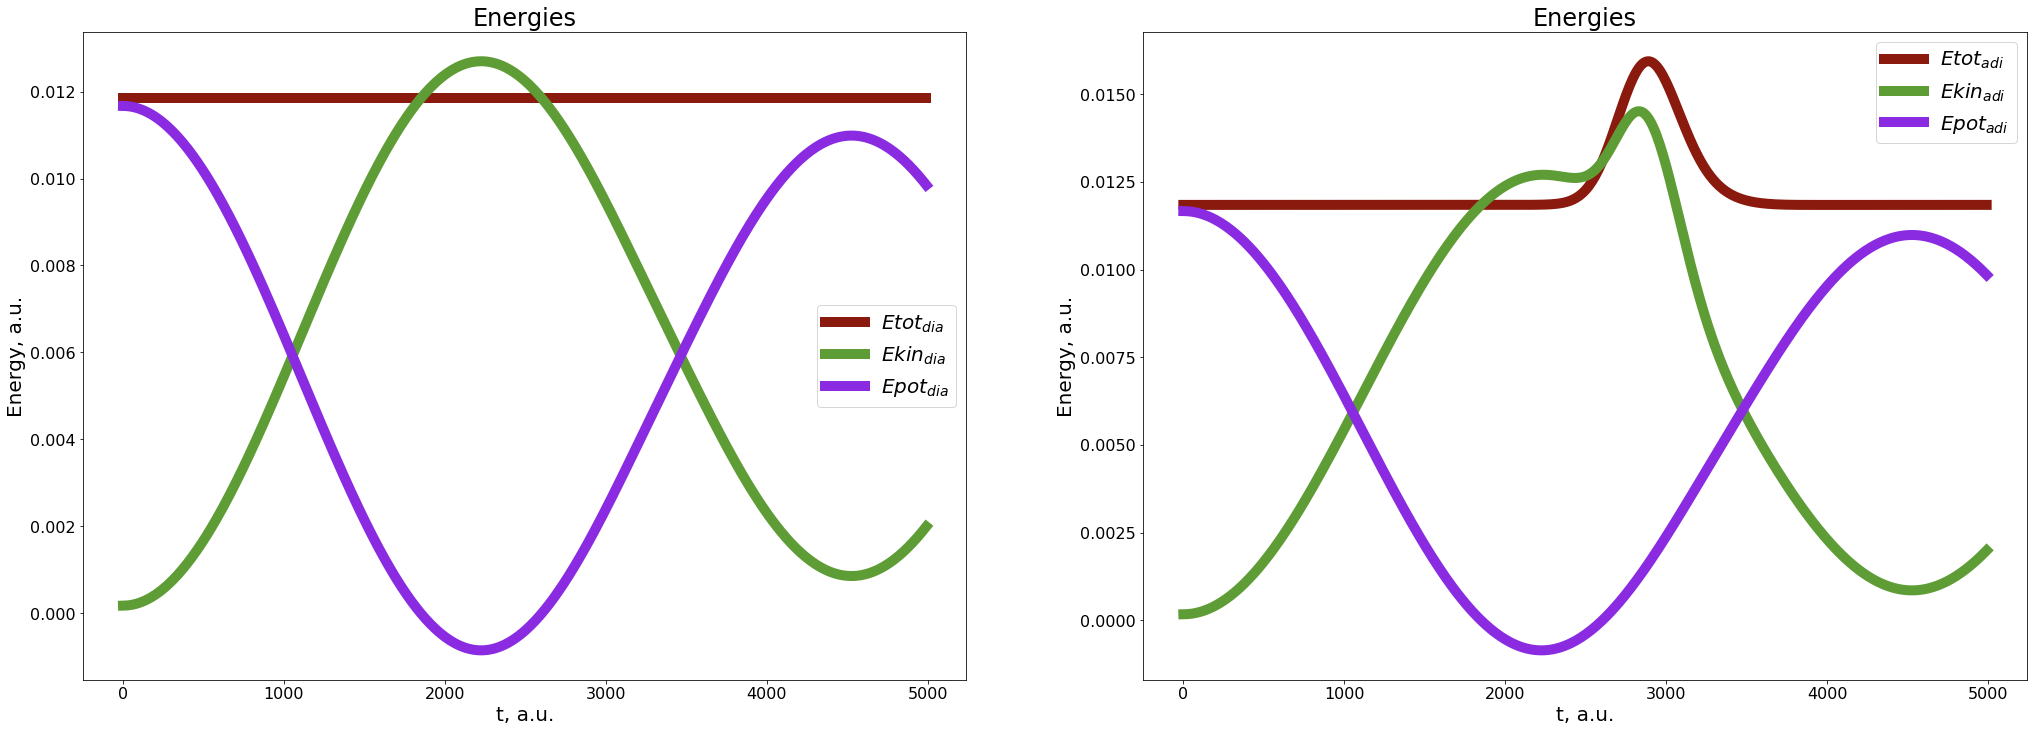

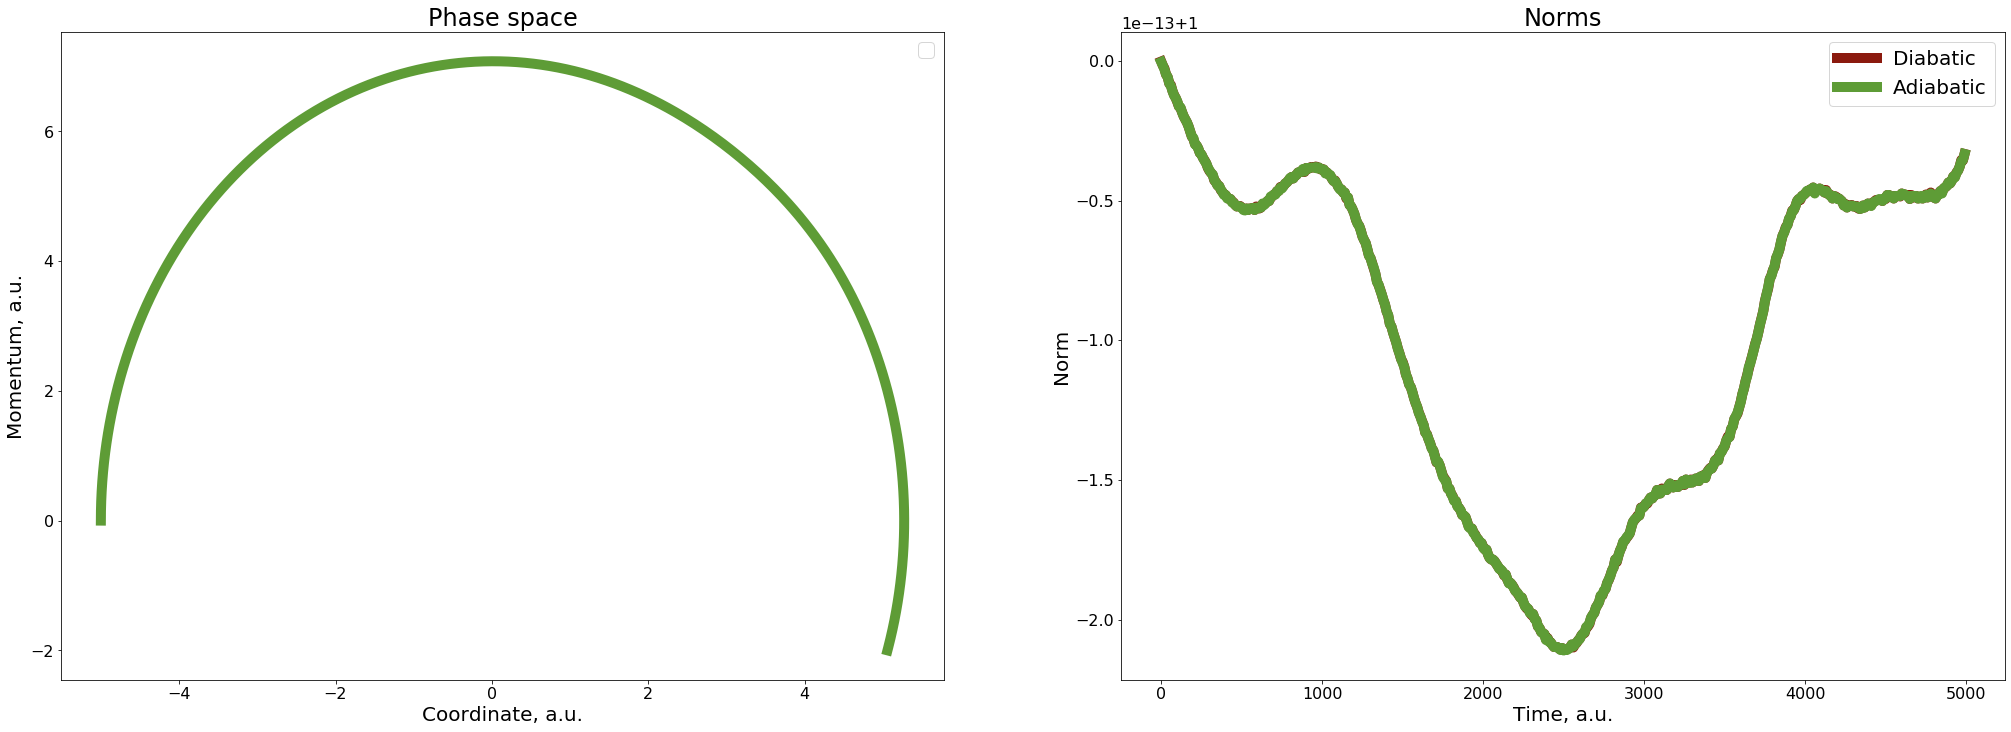

In [46]:
plot_params = {"prefix":"case6-2", "filename":"data.hdf", "hdf5_output_level":3,
                "which_dofs":[0],  "which_adi_states":[0, 1], "which_dia_states":[0, 1],                
                "properties_to_save": 
                          [ "timestep", "time", "Ekin_dia", "Ekin_adi", "Epot_dia", 
                            "Epot_adi", "Etot_dia", "Etot_adi", "norm_dia", "norm_adi",
                            "pop_dia", "pop_adi", "q_dia", "q_adi", "q2_dia", "q2_adi", 
                            "p_dia", "p_adi", "p2_dia", "p2_adi",
                            "denmat_dia", "denmat_adi", 
                            "PSI_dia", "PSI_adi", "reciPSI_dia", "reciPSI_adi" ] 
              }


plot_dyn_exact(plot_params)